In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import RidgeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV

In [4]:
dt=pd.read_csv("D:\Final project 4th sem\mp.csv")

In [5]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154675 entries, 0 to 154674
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        154675 non-null  int64  
 1   submission_count  154675 non-null  int64  
 2   problem_solved    154675 non-null  int64  
 3   follower_count    154675 non-null  int64  
 4   max_rating        154675 non-null  float64
 5   rating            154675 non-null  float64
 6   rank              154675 non-null  object 
 7   problem_id        154675 non-null  object 
 8   attempts_range    154675 non-null  int64  
 9   level_type        154675 non-null  object 
 10  points            154675 non-null  float64
 11  tags              154675 non-null  object 
 12  days              154675 non-null  float64
dtypes: float64(4), int64(5), object(4)
memory usage: 15.3+ MB


In [6]:
dt.head(3)

,Unnamed: 0,submission_count,problem_solved,follower_count,max_rating,rating,rank,problem_id,attempts_range,level_type,points,tags,days
0,0,47,40,4,348.337,330.849,intermediate,prob_75,1,A,500.0,implementation,433.162141
1,1,107,99,11,304.186,203.842,beginner,prob_75,2,A,500.0,implementation,755.097593
2,2,735,715,9,419.438,353.211,intermediate,prob_75,2,A,500.0,implementation,722.582164


In [7]:
#Dropping some unwanted columns
dt.drop(['Unnamed: 0','problem_id'],axis=1,inplace=True)

#### Cleaning tags for vectorization

In [8]:
def clean_catgry(rnk):
    point=rnk.split(",")
    for i in range(len(point)):
        resplit=point[i].split()
        if len(resplit)>1:
            point[i]="_".join(resplit)
    rnk=" ".join(point).lower()
    return rnk

In [9]:
#tags column before cleaning
dt['tags'][154671]

'data structures,divide and conquer'

In [10]:
#applying cleaning function
dt['tags']=dt['tags'].apply(lambda x : clean_catgry(x))

In [11]:
#tags columns after cleaning
dt['tags'][154671]

'data_structures divide_and_conquer'

In [12]:
x=dt.drop(["attempts_range"],axis=1)
y=dt['attempts_range']

In [13]:
x.head(5)

,submission_count,problem_solved,follower_count,max_rating,rating,rank,level_type,points,tags,days
0,47,40,4,348.337,330.849,intermediate,A,500.0,implementation,433.162141
1,107,99,11,304.186,203.842,beginner,A,500.0,implementation,755.097593
2,735,715,9,419.438,353.211,intermediate,A,500.0,implementation,722.582164
3,169,159,2,345.757,345.757,intermediate,A,500.0,implementation,886.118113
4,113,95,7,314.220,89.163,beginner,A,500.0,implementation,288.147743


In [14]:
#Splitting data into train test
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=5,shuffle=True,stratify=y)

In [15]:
print("CHecking shapes of train split")
print(x_train.shape)
print(y_train.shape)

CHecking shapes of train split
(116006, 10)
(116006,)


In [16]:
print("Checking shapes of test split")
print(y_test.shape)
print(x_test.shape)

Checking shapes of test split
(38669,)
(38669, 10)


In [17]:
y_train.value_counts()

1    61857
2    35351
3    10561
4     4109
6     2265
5     1863
Name: attempts_range, dtype: int64

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
vec=CountVectorizer()

In [19]:
x_train_tags=vec.fit_transform(x_train['tags'].values)
x_test_tags=vec.transform(x_test['tags'].values)

In [20]:
print(x_train_tags.shape)
print(x_test_tags.shape)

(116006, 40)
(38669, 40)


In [21]:
#Ordinal encoding rank
from sklearn.preprocessing import OrdinalEncoder
enc=OrdinalEncoder(categories=[['beginner','intermediate','advanced','expert']])
x_train_rank=enc.fit_transform(x_train['rank'].values.reshape(-1,1))
x_test_rank=enc.transform(x_test['rank'].values.reshape(-1,1))
print(x_train_rank.shape)
print(x_test_rank.shape)


(116006, 1)
(38669, 1)


In [22]:
encoder=OrdinalEncoder()
x_train_type=encoder.fit_transform(x_train['level_type'].values.reshape(-1,1))
x_test_type=encoder.transform(x_test['level_type'].values.reshape(-1,1))
print(x_train_type.shape)
print(x_test_type.shape)

(116006, 1)
(38669, 1)


##### Standardising numeric column

In [23]:
# Standardising numeric columns
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()


In [24]:
#submision_count
sc.fit(x_train['submission_count'].values.reshape(-1,1))
x_train_sbmsn=sc.transform(x_train['submission_count'].values.reshape(-1,1))
x_test_sbmsn=sc.transform(x_test['submission_count'].values.reshape(-1,1))
x_train_sbmsn.shape

(116006, 1)

In [25]:
#problem solved
sc.fit(x_train['problem_solved'].values.reshape(-1,1))
x_train_solved=sc.transform(x_train['problem_solved'].values.reshape(-1,1))
x_test_solved=sc.transform(x_test['problem_solved'].values.reshape(-1,1))
x_train_solved.shape

(116006, 1)

In [26]:
#folowercount
sc.fit(x_train['follower_count'].values.reshape(-1,1))
x_train_flwr=sc.transform(x_train['follower_count'].values.reshape(-1,1))
x_test_flwr=sc.transform(x_test['follower_count'].values.reshape(-1,1))
x_train_flwr.shape

(116006, 1)

In [27]:
#Max rating
sc.fit(x_train['follower_count'].values.reshape(-1,1))
x_train_maxrating=sc.transform(x_train['follower_count'].values.reshape(-1,1))
x_test_maxrating=sc.transform(x_test['follower_count'].values.reshape(-1,1))
x_train_maxrating.shape

(116006, 1)

In [28]:
#RAting
sc.fit(x_train['rating'].values.reshape(-1,1))
x_train_rating=sc.transform(x_train['rating'].values.reshape(-1,1))
x_test_rating=sc.transform(x_test['rating'].values.reshape(-1,1))
x_train_rating.shape

(116006, 1)

In [29]:
#Points
sc.fit(x_train['points'].values.reshape(-1,1))
x_train_points=sc.transform(x_train['points'].values.reshape(-1,1))
x_test_points=sc.transform(x_test['points'].values.reshape(-1,1))
x_train_points.shape

(116006, 1)

In [30]:
#days
sc.fit(x_train['days'].values.reshape(-1,1))
x_train_days=sc.transform(x_train['days'].values.reshape(-1,1))
x_test_days=sc.transform(x_test['days'].values.reshape(-1,1))
x_train_days.shape

(116006, 1)

### Joining all features

In [31]:
from scipy.sparse import hstack

In [32]:
x_trn=hstack((x_train_tags,x_train_rank,x_train_type,x_train_sbmsn,x_train_solved,x_train_flwr,x_train_maxrating,x_train_rating,x_train_points,x_train_days)).tocsr()
x_tst=hstack((x_test_tags,x_test_rank,x_test_type,x_test_sbmsn,x_test_solved,x_test_flwr,x_test_maxrating,x_test_rating,x_test_points,x_test_days)).tocsr()


In [33]:
print(x_trn.shape , y_train.shape)
print(x_tst.shape , y_test.shape)

(116006, 49) (116006,)
(38669, 49) (38669,)


In [34]:
from sklearn.preprocessing import OrdinalEncoder
enc=OrdinalEncoder()
y_trn=enc.fit_transform(y_train.values.reshape(-1,1))
y_tst=enc.transform(y_test.values.reshape(-1,1))

C:\Users\shraj\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='count'>

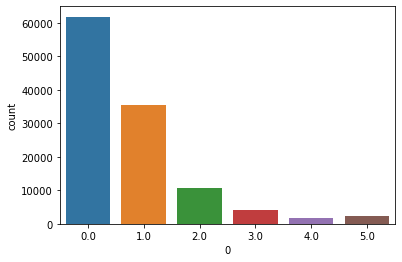

In [33]:
import seaborn as sns
sns.countplot(pd.DataFrame(y_trn).iloc[:,0])

C:\Users\shraj\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='count'>

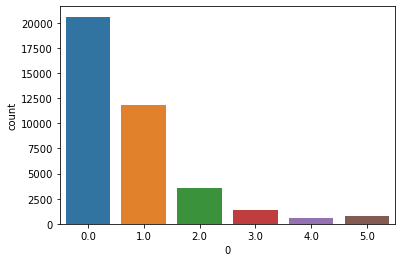

In [119]:
import seaborn as sns
sns.countplot(pd.DataFrame(y_tst).iloc[:,0])

### Model building

In [43]:
#Multi nomial regression

In [44]:
#defining model
model = LogisticRegression(multi_class='multinomial')
# defining cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, x_trn, y_train, scoring='f1_micro' , cv=cv, n_jobs=-1)


In [45]:
model = LogisticRegression(multi_class='multinomial')

model.fit(x_trn,y_trn)

C:\Users\shraj\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [46]:
y_test_prdct=model.predict(x_tst)
y_train_prdct=model.predict(x_trn)

In [37]:
print("Test accuracy",f1_score(y_test_prdct,y_tst,average='micro').round(4))
print("Train accuracy",f1_score(y_train_prdct,y_trn , average='micro').round(4))

Test accuracy 0.5332
Train accuracy 0.5348


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shraj\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shraj\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report               precision    recall  f1-score   support

         0.0       0.56      0.93      0.70     61857
         1.0       0.35      0.13      0.19     35351
         2.0       0.06      0.00      0.00     10561
         3.0       0.00      0.00      0.00      4109
         4.0       0.00      0.00      0.00      1863
         5.0       0.11      0.00      0.00      2265

    accuracy                           0.53    116006
   macro avg       0.18      0.18      0.15    116006
weighted avg       0.41      0.53      0.43    116006

accuracy 0.5347654431667328
precision 0.5347654431667328
recall 0.5347654431667328


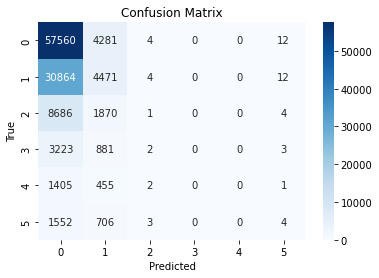

In [38]:
print("Classification report",classification_report(y_trn,y_train_prdct))
print('accuracy',accuracy_score(y_trn,y_train_prdct))
print("precision",precision_score(y_trn,y_train_prdct,average="micro"))
print("recall",recall_score(y_trn,y_train_prdct,average="micro"))

cm = confusion_matrix(y_trn, y_train_prdct)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [45]:
def analysis(y_trn,y_train_prdct):
        print("Classification report",classification_report(y_trn,y_train_prdct))
        print('accuracy',accuracy_score(y_trn,y_train_prdct))
        print("precision",precision_score(y_trn,y_train_prdct,average="micro"))
        print("recall",recall_score(y_trn,y_train_prdct,average="micro"))
        cm = confusion_matrix(y_trn, y_train_prdct)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

C:\Users\shraj\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shraj\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shraj\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report               precision    recall  f1-score   support

         0.0       0.56      0.93      0.70     20619
         1.0       0.34      0.12      0.18     11784
         2.0       0.00      0.00      0.00      3521
         3.0       0.00      0.00      0.00      1369
         4.0       0.00      0.00      0.00       621
         5.0       0.08      0.00      0.00       755

    accuracy                           0.53     38669
   macro avg       0.16      0.18      0.15     38669
weighted avg       0.40      0.53      0.43     38669

accuracy 0.533243683570819
precision 0.533243683570819
recall 0.533243683570819


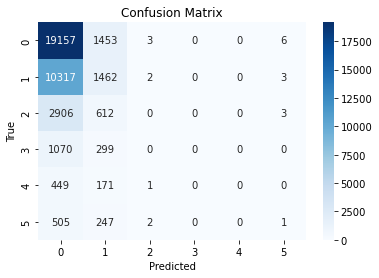

In [40]:
analysis(y_tst,y_test_prdct)

### decision tree

In [36]:
model1=DecisionTreeClassifier()
# defining cross validation


In [ ]:
cv1 = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores1 = cross_val_score(model1, x_trn, y_trn, scoring='f1_micro' , cv=cv1, n_jobs=-1)

In [37]:
model1.fit(x_trn,y_trn)

DecisionTreeClassifier()

In [35]:
y_test_prdct1=model1.predict(x_tst)
y_train_prdct1=model1.predict(x_trn)

In [68]:
#print("Cross validtn accuracy",np.mean(n_scores1).round(4))
print("Train acrcy",f1_score(y_train_prdct1,y_trn,average='micro').round(4))
print("Test acrcy",f1_score(y_test_prdct1,y_tst,average='micro').round(4))


Train acrcy 0.9477
Test acrcy 0.5574


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

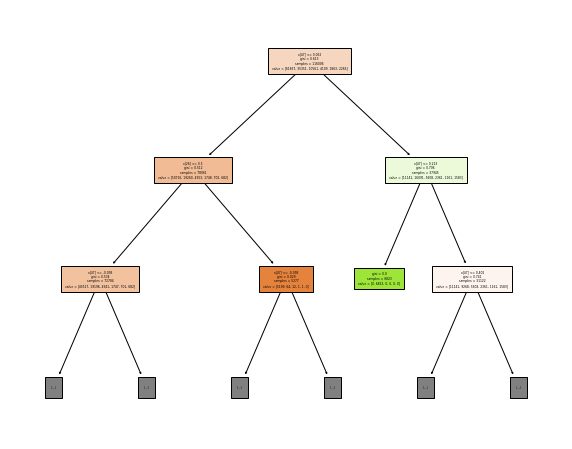

In [53]:
from sklearn import tree
import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize=(10,8))
tree.plot_tree(model1,ax=ax,filled=True,max_depth=2,fontsize=3)
plt.xticks(rotation='vertical')

Object `tree.plot.tree` not found.


for train
Classification report               precision    recall  f1-score   support

         0.0       0.92      0.99      0.96     61857
         1.0       0.97      0.89      0.93     35351
         2.0       0.99      0.89      0.94     10561
         3.0       1.00      0.91      0.95      4109
         4.0       1.00      0.93      0.96      1863
         5.0       1.00      0.95      0.97      2265

    accuracy                           0.95    116006
   macro avg       0.98      0.93      0.95    116006
weighted avg       0.95      0.95      0.95    116006

accuracy 0.9477096012275227
precision 0.9477096012275227
recall 0.9477096012275227


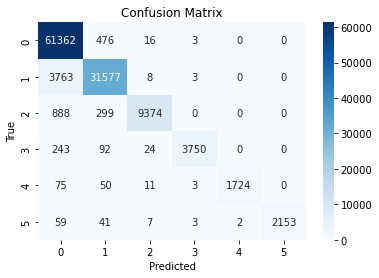

In [69]:
print("for train")
analysis(y_trn,y_train_prdct1)

Classification report               precision    recall  f1-score   support

         0.0       0.67      0.70      0.69     20619
         1.0       0.47      0.44      0.46     11784
         2.0       0.32      0.31      0.32      3521
         3.0       0.28      0.28      0.28      1369
         4.0       0.26      0.25      0.25       621
         5.0       0.32      0.30      0.31       755

    accuracy                           0.56     38669
   macro avg       0.39      0.38      0.38     38669
weighted avg       0.55      0.56      0.55     38669

accuracy 0.5573715379244356
precision 0.5573715379244356
recall 0.5573715379244356


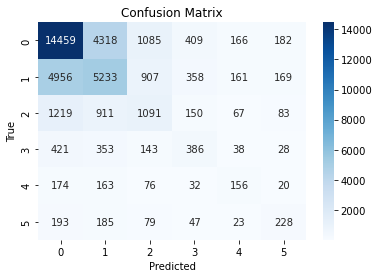

In [70]:
analysis(y_tst,y_test_prdct1)

### Random forest


In [42]:
model2=RandomForestClassifier()

In [ ]:
# defining cross validation
cv2 = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores2 = cross_val_score(model2, x_trn, y_train, scoring='f1_micro' , cv=cv2, n_jobs=-1)

In [43]:
model2.fit(x_trn,y_trn)

C:\Users\shraj\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier()

In [71]:
y_test_prdct2=model2.predict(x_tst)
y_train_prdct2=model2.predict(x_trn)

In [72]:

print("Train acrcy",f1_score(y_trn,y_train_prdct2,average='micro').round(4))
print("Test acrcy",f1_score(y_tst,y_test_prdct2,average='micro').round(4))


Train acrcy 0.9477
Test acrcy 0.6055


Train
Classification report               precision    recall  f1-score   support

         0.0       0.94      0.98      0.96     61857
         1.0       0.95      0.91      0.93     35351
         2.0       0.98      0.90      0.94     10561
         3.0       0.98      0.93      0.95      4109
         4.0       0.99      0.94      0.96      1863
         5.0       0.99      0.96      0.97      2265

    accuracy                           0.95    116006
   macro avg       0.97      0.94      0.95    116006
weighted avg       0.95      0.95      0.95    116006

accuracy 0.9477096012275227
precision 0.9477096012275227
recall 0.9477096012275227


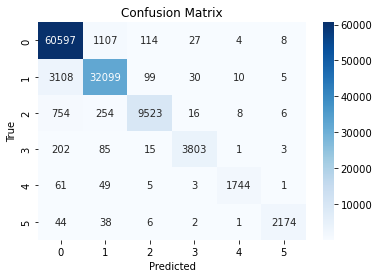

In [73]:
print("Train")
analysis(y_trn,y_train_prdct2)

Test
Classification report               precision    recall  f1-score   support

         0.0       0.65      0.82      0.73     20619
         1.0       0.50      0.43      0.47     11784
         2.0       0.52      0.25      0.33      3521
         3.0       0.56      0.22      0.31      1369
         4.0       0.37      0.08      0.14       621
         5.0       0.46      0.15      0.23       755

    accuracy                           0.61     38669
   macro avg       0.51      0.33      0.37     38669
weighted avg       0.58      0.61      0.58     38669

accuracy 0.605549665106416
precision 0.605549665106416
recall 0.605549665106416


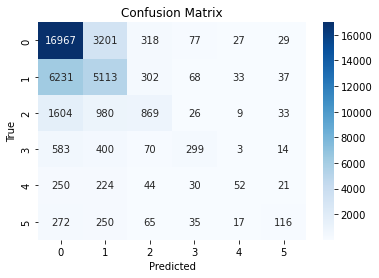

In [74]:
print("Test")
analysis(y_tst,y_test_prdct2)

In [46]:
print("For test data / Random forest")
print()
print(classification_report(y_tst,y_test_prdct2))

For test data / Random forest

              precision    recall  f1-score   support

         0.0       0.65      0.82      0.73     20619
         1.0       0.50      0.43      0.46     11784
         2.0       0.52      0.25      0.34      3521
         3.0       0.58      0.22      0.32      1369
         4.0       0.43      0.11      0.18       621
         5.0       0.46      0.16      0.24       755

    accuracy                           0.60     38669
   macro avg       0.53      0.33      0.38     38669
weighted avg       0.58      0.60      0.58     38669



In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [150],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'class_weight': [None, 'balanced'],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'min_impurity_decrease': [0.0, 0.1, 0.2],
    
    'oob_score': [False, True],
    'random_state': [42]  
}

# Create the random forest classifier
rf_classifier = RandomForestClassifier()

# Perform grid search using cross-validation
grid_search = RandomizedSearchCV(rf_classifier, param_grid, scoring='f1_micro', cv=5 ,n_jobs=-1)
grid_search.fit(x_trn, y_trn)  

# Print the best parameters and corresponding F1 score
print("Best parameters found: ", grid_search.best_params_)
print("Best F1 score: ", grid_search.best_score_)


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\shraj\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shraj\anaconda3\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\shraj\anaconda3\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\shraj\anaconda3\lib\site-packages\

Best parameters found:  {'random_state': 42, 'oob_score': False, 'min_samples_split': 150, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.2, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini', 'class_weight': None, 'bootstrap': False}
Best F1 score:  0.5332224194655921


In [55]:
#bst model from hyper parameter
hyprfrst=RandomForestClassifier(random_state= 42, oob_score= False, min_samples_split= 150, min_samples_leaf= 2, min_impurity_decrease= 0.2, max_features= 'sqrt', max_depth= 10, criterion='gini',class_weight= None, bootstrap= False)

In [56]:
hyprfrst.fit(x_trn,y_trn)

C:\Users\shraj\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(bootstrap=False, max_depth=10, min_impurity_decrease=0.2,
                       min_samples_leaf=2, min_samples_split=150,
                       random_state=42)

In [57]:
y_trn_prdct=hyprfrst.predict(x_trn)
y_tst_prdct=hyprfrst.predict(x_tst)

C:\Users\shraj\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shraj\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shraj\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report               precision    recall  f1-score   support

         0.0       0.53      1.00      0.70     61857
         1.0       0.00      0.00      0.00     35351
         2.0       0.00      0.00      0.00     10561
         3.0       0.00      0.00      0.00      4109
         4.0       0.00      0.00      0.00      1863
         5.0       0.00      0.00      0.00      2265

    accuracy                           0.53    116006
   macro avg       0.09      0.17      0.12    116006
weighted avg       0.28      0.53      0.37    116006

accuracy 0.5332224195300244
precision 0.5332224195300244
recall 0.5332224195300244


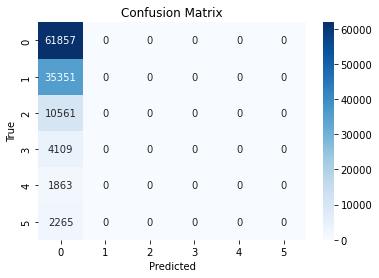

In [60]:
analysis(y_trn,y_trn_prdct)

C:\Users\shraj\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shraj\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shraj\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report               precision    recall  f1-score   support

         0.0       0.53      1.00      0.70     20619
         1.0       0.00      0.00      0.00     11784
         2.0       0.00      0.00      0.00      3521
         3.0       0.00      0.00      0.00      1369
         4.0       0.00      0.00      0.00       621
         5.0       0.00      0.00      0.00       755

    accuracy                           0.53     38669
   macro avg       0.09      0.17      0.12     38669
weighted avg       0.28      0.53      0.37     38669

accuracy 0.5332178230624014
precision 0.5332178230624014
recall 0.5332178230624014


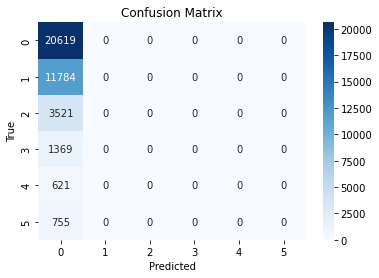

In [61]:
analysis(y_tst,y_tst_prdct)

In [ ]:
#print("Cross validtn accuracy",np.mean(n_scores2).round(4))

### Xgboost

In [ ]:
pip install xgboost

In [76]:
from xgboost import XGBClassifier

In [77]:
modelxg=XGBClassifier()

In [78]:
modelxg.fit(x_trn , y_trn)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [79]:
y_train_pred=modelxg.predict(x_trn)
y_test_pred=modelxg.predict(x_tst)

In [80]:
print("Train acrcy",f1_score(y_train_pred,y_trn,average='micro').round(4))
print("Test acrcy",f1_score(y_test_pred,y_tst,average='micro').round(4))


Train acrcy 0.6757
Test acrcy 0.6373


Train
Classification report               precision    recall  f1-score   support

         0.0       0.66      0.95      0.78     61857
         1.0       0.66      0.41      0.51     35351
         2.0       0.98      0.24      0.39     10561
         3.0       1.00      0.24      0.39      4109
         4.0       0.99      0.29      0.45      1863
         5.0       0.95      0.38      0.54      2265

    accuracy                           0.68    116006
   macro avg       0.87      0.42      0.51    116006
weighted avg       0.71      0.68      0.64    116006

accuracy 0.67568056824647
precision 0.67568056824647
recall 0.67568056824647


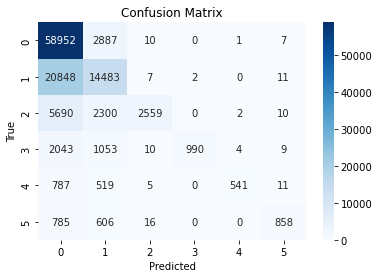

In [81]:
print("Train")
analysis(y_trn,y_train_pred)

Test
Classification report               precision    recall  f1-score   support

         0.0       0.64      0.92      0.76     20619
         1.0       0.57      0.35      0.44     11784
         2.0       0.92      0.21      0.35      3521
         3.0       0.96      0.23      0.37      1369
         4.0       0.89      0.22      0.35       621
         5.0       0.83      0.28      0.42       755

    accuracy                           0.64     38669
   macro avg       0.80      0.37      0.45     38669
weighted avg       0.66      0.64      0.59     38669

accuracy 0.6372805089348057
precision 0.6372805089348057
recall 0.6372805089348057


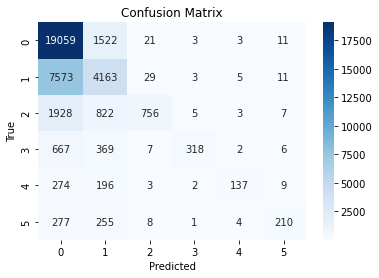

In [82]:
print("Test")
analysis(y_tst,y_test_pred)

### Trying out lgbm model

In [38]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [83]:
from lightgbm import LGBMClassifier
modellgbm=LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
modellgbm.fit(x_trn,y_trn)

C:\Users\shraj\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\shraj\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1624
[LightGBM] [Info] Number of data points in the train set: 116006, number of used features: 49
[LightGBM] [Info] Start training from score -0.628817
[LightGBM] [Info] Start training from score -1.188315
[LightGBM] [Info] Start training from score -2.396474
[LightGBM] [Info] Start training from score -3.340462
[LightGBM] [Info] Start training from score -4.131454
[LightGBM] [Info] Start training from score -3.936067


LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)

In [49]:
y_test_predct=modellgbm.predict(x_tst)
y_train_predct=modellgbm.predict(x_trn)

NameError: name 'modellgbm' is not defined

In [85]:
print("Train acrcy",f1_score(y_train_predct,y_trn,average='micro').round(4))
print("Test acrcy",f1_score(y_test_predct,y_tst,average='micro').round(4))

Train acrcy 0.6583
Test acrcy 0.6353


In [48]:
analysis(y_trn,y_train_predct)

NameError: name 'y_train_predct' is not defined

Classification report               precision    recall  f1-score   support

         0.0       0.63      0.94      0.75     20619
         1.0       0.58      0.33      0.42     11784
         2.0       0.98      0.21      0.35      3521
         3.0       0.98      0.23      0.37      1369
         4.0       0.87      0.22      0.35       621
         5.0       0.89      0.28      0.42       755

    accuracy                           0.64     38669
   macro avg       0.82      0.37      0.45     38669
weighted avg       0.67      0.64      0.59     38669

accuracy 0.6353151102950684
precision 0.6353151102950684
recall 0.6353151102950684


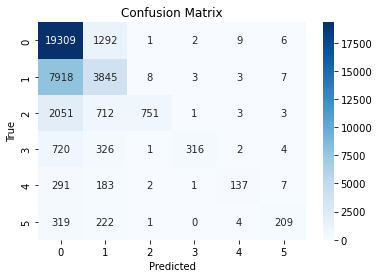

In [87]:
analysis(y_tst,y_test_predct)

##### looking feature importance for random forest

In [64]:
model2.feature_importances_

array([8.59554567e-03, 2.93420765e-03, 1.85064484e-02, 1.33660053e-04,
       3.58828885e-03, 1.09711994e-02, 7.08949131e-03, 5.20682978e-03,
       1.75113025e-03, 8.50745005e-03, 2.62656537e-03, 1.02697013e-03,
       2.78944225e-04, 5.32798244e-04, 3.29799771e-03, 4.50708075e-03,
       7.73058833e-04, 4.67386564e-03, 1.51919909e-02, 2.03791346e-03,
       1.44384633e-02, 1.65130259e-04, 1.56736208e-02, 8.97279423e-04,
       1.62595984e-04, 1.70781934e-04, 7.92080588e-03, 7.00404714e-03,
       1.73215789e-03, 4.55736596e-04, 2.27046527e-04, 2.31977545e-03,
       1.21082638e-02, 9.26396915e-04, 6.15519358e-04, 9.97971544e-03,
       7.89449874e-04, 1.63270240e-04, 3.55934175e-03, 4.72197130e-03,
       1.34813640e-02, 3.48962475e-02, 1.02386282e-01, 1.02374438e-01,
       8.12560404e-02, 8.14213609e-02, 1.11304592e-01, 1.77250003e-01,
       1.09366866e-01])

In [65]:
# for lgbm
modellgbm.feature_importances_

array([ 290,   72,  369,    6,  117,  321,  255,  162,   52,  270,   79,
         42,   19,   30,   94,  105,   30,  110,  339,   99,  349,   22,
        358,   45,    0,    0,  112,  226,  113,   34,   35,  105,  217,
          0,   53,  183,   47,    0,  162,  115,   50,  581, 1741, 1485,
       1945,    0, 2827, 1894, 2440])

In [67]:
# xgboost
modelxg.feature_importances_

array([0.01271489, 0.01029357, 0.01392211, 0.00271378, 0.00916146,
       0.0167577 , 0.01141618, 0.01336447, 0.01157193, 0.01218472,
       0.01185636, 0.00776694, 0.00579187, 0.00822789, 0.01123867,
       0.01144283, 0.00810216, 0.00889812, 0.01553998, 0.00952964,
       0.01446996, 0.0103112 , 0.01336076, 0.0075591 , 0.        ,
       0.        , 0.27052474, 0.02241143, 0.01861151, 0.01011346,
       0.00340925, 0.01158286, 0.01114496, 0.        , 0.01147345,
       0.01186338, 0.00983256, 0.        , 0.01391326, 0.01097024,
       0.00652548, 0.0190882 , 0.00883721, 0.0095265 , 0.00883322,
       0.        , 0.01430945, 0.25939474, 0.0094378 ], dtype=float32)

In [36]:
pip install pip-upgrader

  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13724 sha256=13437c113db4264511ce792d5ecdfdf0ba2595a80ede962cd9ea6b9ca10d618e
  Stored in directory: c:\users\shraj\appdata\local\pip\cache\wheels\70\4a\46\1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt
Note: you may need to restart the kernel to use updated packages.


In [37]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [38]:
from platform import python_version

print(python_version())

3.9.7


In [39]:
pip install FLAML

Note: you may need to restart the kernel to use updated packages.


In [41]:
from flaml import AutoML

In [42]:
automl =AutoML()
automl.fit(x_trn,y_trn,task='classification',time_budget=300)

[flaml.automl.logger: 07-22 10:30:24] {1693} INFO - task = classification
[flaml.automl.logger: 07-22 10:30:24] {1700} INFO - Data split method: stratified
[flaml.automl.logger: 07-22 10:30:24] {1703} INFO - Evaluation method: holdout
[flaml.automl.logger: 07-22 10:30:24] {1801} INFO - Minimizing error metric: log_loss
[flaml.automl.logger: 07-22 10:30:24] {1911} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 07-22 10:30:24] {2221} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 07-22 10:30:24] {2347} INFO - Estimated sufficient time budget=6524s. Estimated necessary time budget=150s.
[flaml.automl.logger: 07-22 10:30:24] {2394} INFO -  at 0.2s,	estimator lgbm's best error=1.0275,	best estimator lgbm's best error=1.0275
[flaml.automl.logger: 07-22 10:30:24] {2221} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 07-22 10:30:24] {2394} INFO -  at 0.2s,	estimator lgbm's best er

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:30:24] {2394} INFO -  at 0.7s,	estimator extra_tree's best error=1.1727,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-22 10:30:24] {2221} INFO - iteration 12, current learner extra_tree
[flaml.automl.logger: 07-22 10:30:24] {2394} INFO -  at 0.7s,	estimator extra_tree's best error=1.1620,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-22 10:30:24] {2221} INFO - iteration 13, current learner rf
[flaml.automl.logger: 07-22 10:30:24] {2394} INFO -  at 0.8s,	estimator rf's best error=1.1623,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-22 10:30:24] {2221} INFO - iteration 14, current learner rf
[flaml.automl.logger: 07-22 10:30:25] {2394} INFO -  at 0.9s,	estimator rf's best error=1.1123,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-22 10:30:25] {2221} INFO - iteration 15, current learner xgboost
[flaml.automl.logger: 07-22 10:30:25] {2394} INFO -  at 1.0s,	estimator xgboost's best 

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:30:25] {2394} INFO -  at 1.2s,	estimator lgbm's best error=0.9235,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-22 10:30:25] {2221} INFO - iteration 19, current learner xgboost
[flaml.automl.logger: 07-22 10:30:25] {2394} INFO -  at 1.3s,	estimator xgboost's best error=0.9357,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-22 10:30:25] {2221} INFO - iteration 20, current learner xgboost
[flaml.automl.logger: 07-22 10:30:25] {2394} INFO -  at 1.4s,	estimator xgboost's best error=0.9293,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-22 10:30:25] {2221} INFO - iteration 21, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:30:25] {2394} INFO -  at 1.5s,	estimator xgboost's best error=0.9257,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-22 10:30:25] {2221} INFO - iteration 22, current learner lgbm
[flaml.automl.logger: 07-22 10:30:25] {2394} INFO -  at 1.7s,	estimator lgbm's best error=0.9008,	best estimator lgbm's best error=0.9008
[flaml.automl.logger: 07-22 10:30:25] {2221} INFO - iteration 23, current learner lgbm
[flaml.automl.logger: 07-22 10:30:25] {2394} INFO -  at 1.9s,	estimator lgbm's best error=0.9008,	best estimator lgbm's best error=0.9008
[flaml.automl.logger: 07-22 10:30:25] {2221} INFO - iteration 24, current learner xgboost
[flaml.automl.logger: 07-22 10:30:26] {2394} INFO -  at 2.0s,	estimator xgboost's best error=0.9244,	best estimator lgbm's best error=0.9008
[flaml.automl.logger: 07-22 10:30:26] {2221} INFO - iteration 25, current learner extra_tree
[flaml.automl.logger: 07-22 10:30:26] {2394} INFO -  at 2.0s,	estimator extra_tree's 

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:30:26] {2394} INFO -  at 2.7s,	estimator lgbm's best error=0.8824,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:30:26] {2221} INFO - iteration 27, current learner rf
[flaml.automl.logger: 07-22 10:30:26] {2394} INFO -  at 2.8s,	estimator rf's best error=1.1123,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:30:26] {2221} INFO - iteration 28, current learner xgboost
[flaml.automl.logger: 07-22 10:30:27] {2394} INFO -  at 2.9s,	estimator xgboost's best error=0.9219,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:30:27] {2221} INFO - iteration 29, current learner xgboost
[flaml.automl.logger: 07-22 10:30:27] {2394} INFO -  at 3.0s,	estimator xgboost's best error=0.9219,	best estimator lgbm's best error=0.8824


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:30:27] {2221} INFO - iteration 30, current learner lgbm
[flaml.automl.logger: 07-22 10:30:28] {2394} INFO -  at 4.0s,	estimator lgbm's best error=0.8824,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:30:28] {2221} INFO - iteration 31, current learner lgbm
[flaml.automl.logger: 07-22 10:30:28] {2394} INFO -  at 4.5s,	estimator lgbm's best error=0.8824,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:30:28] {2221} INFO - iteration 32, current learner lgbm
[flaml.automl.logger: 07-22 10:30:29] {2394} INFO -  at 5.1s,	estimator lgbm's best error=0.8824,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:30:29] {2221} INFO - iteration 33, current learner xgboost
[flaml.automl.logger: 07-22 10:30:29] {2394} INFO -  at 5.2s,	estimator xgboost's best error=0.9219,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:30:29] {2221} INFO - iteration 34, current learner lgbm


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:30:30] {2394} INFO -  at 6.1s,	estimator lgbm's best error=0.8824,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:30:30] {2221} INFO - iteration 35, current learner rf
[flaml.automl.logger: 07-22 10:30:30] {2394} INFO -  at 6.2s,	estimator rf's best error=1.0410,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:30:30] {2221} INFO - iteration 36, current learner extra_tree
[flaml.automl.logger: 07-22 10:30:30] {2394} INFO -  at 6.3s,	estimator extra_tree's best error=1.1596,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:30:30] {2221} INFO - iteration 37, current learner rf
[flaml.automl.logger: 07-22 10:30:30] {2394} INFO -  at 6.5s,	estimator rf's best error=1.0410,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:30:30] {2221} INFO - iteration 38, current learner rf
[flaml.automl.logger: 07-22 10:30:30] {2394} INFO -  at 6.6s,	estimator rf's best error=1.0349,	be

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:30:32] {2394} INFO -  at 8.4s,	estimator xgb_limitdepth's best error=0.9445,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:30:32] {2221} INFO - iteration 41, current learner xgb_limitdepth
[flaml.automl.logger: 07-22 10:30:32] {2394} INFO -  at 8.6s,	estimator xgb_limitdepth's best error=0.9445,	best estimator lgbm's best error=0.8824


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:30:32] {2221} INFO - iteration 42, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:30:32] {2394} INFO -  at 8.8s,	estimator xgb_limitdepth's best error=0.9445,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:30:32] {2221} INFO - iteration 43, current learner lgbm
[flaml.automl.logger: 07-22 10:30:33] {2394} INFO -  at 9.4s,	estimator lgbm's best error=0.8824,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:30:33] {2221} INFO - iteration 44, current learner xgb_limitdepth
[flaml.automl.logger: 07-22 10:30:33] {2394} INFO -  at 9.6s,	estimator xgb_limitdepth's best error=0.9425,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:30:33] {2221} INFO - iteration 45, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:30:33] {2394} INFO -  at 9.8s,	estimator xgb_limitdepth's best error=0.9425,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:30:33] {2221} INFO - iteration 46, current learner xgboost
[flaml.automl.logger: 07-22 10:30:34] {2394} INFO -  at 10.0s,	estimator xgboost's best error=0.9219,	best estimator lgbm's best error=0.8824


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:30:34] {2221} INFO - iteration 47, current learner lgbm
[flaml.automl.logger: 07-22 10:30:35] {2394} INFO -  at 11.2s,	estimator lgbm's best error=0.8816,	best estimator lgbm's best error=0.8816
[flaml.automl.logger: 07-22 10:30:35] {2221} INFO - iteration 48, current learner xgboost
[flaml.automl.logger: 07-22 10:30:35] {2394} INFO -  at 11.3s,	estimator xgboost's best error=0.9219,	best estimator lgbm's best error=0.8816
[flaml.automl.logger: 07-22 10:30:35] {2221} INFO - iteration 49, current learner lgbm


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:30:36] {2394} INFO -  at 12.0s,	estimator lgbm's best error=0.8816,	best estimator lgbm's best error=0.8816
[flaml.automl.logger: 07-22 10:30:36] {2221} INFO - iteration 50, current learner lgbm
[flaml.automl.logger: 07-22 10:30:36] {2394} INFO -  at 12.5s,	estimator lgbm's best error=0.8816,	best estimator lgbm's best error=0.8816
[flaml.automl.logger: 07-22 10:30:36] {2221} INFO - iteration 51, current learner extra_tree
[flaml.automl.logger: 07-22 10:30:36] {2394} INFO -  at 12.6s,	estimator extra_tree's best error=1.1518,	best estimator lgbm's best error=0.8816
[flaml.automl.logger: 07-22 10:30:36] {2221} INFO - iteration 52, current learner lgbm
[flaml.automl.logger: 07-22 10:30:40] {2394} INFO -  at 16.3s,	estimator lgbm's best error=0.8806,	best estimator lgbm's best error=0.8806
[flaml.automl.logger: 07-22 10:30:40] {2221} INFO - iteration 53, current learner lgbm
[flaml.automl.logger: 07-22 10:30:45] {2394} INFO -  at 21.4s,	estimator lgbm's best

C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-22 10:31:13] {2394} INFO -  at 49.2s,	estimator lrl1's best error=1.1520,	best estimator lgbm's best error=0.8792
[flaml.automl.logger: 07-22 10:31:13] {2221} INFO - iteration 61, current learner rf


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-22 10:31:13] {2394} INFO -  at 49.4s,	estimator rf's best error=1.0092,	best estimator lgbm's best error=0.8792
[flaml.automl.logger: 07-22 10:31:13] {2221} INFO - iteration 62, current learner lrl1
[flaml.automl.logger: 07-22 10:31:15] {2394} INFO -  at 51.0s,	estimator lrl1's best error=1.1520,	best estimator lgbm's best error=0.8792
[flaml.automl.logger: 07-22 10:31:15] {2221} INFO - iteration 63, current learner rf
[flaml.automl.logger: 07-22 10:31:15] {2394} INFO -  at 51.1s,	estimator rf's best error=1.0092,	best estimator lgbm's best error=0.8792
[flaml.automl.logger: 07-22 10:31:15] {2221} INFO - iteration 64, current learner lrl1


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-22 10:31:30] {2394} INFO -  at 66.7s,	estimator lrl1's best error=1.1363,	best estimator lgbm's best error=0.8792
[flaml.automl.logger: 07-22 10:31:30] {2221} INFO - iteration 65, current learner rf


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-22 10:31:31] {2394} INFO -  at 67.2s,	estimator rf's best error=1.0092,	best estimator lgbm's best error=0.8792
[flaml.automl.logger: 07-22 10:31:31] {2221} INFO - iteration 66, current learner lgbm
[flaml.automl.logger: 07-22 10:31:39] {2394} INFO -  at 75.8s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:31:39] {2221} INFO - iteration 67, current learner rf
[flaml.automl.logger: 07-22 10:31:40] {2394} INFO -  at 76.2s,	estimator rf's best error=1.0092,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:31:40] {2221} INFO - iteration 68, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:31:40] {2394} INFO -  at 76.4s,	estimator xgboost's best error=0.9210,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:31:40] {2221} INFO - iteration 69, current learner rf
[flaml.automl.logger: 07-22 10:31:41] {2394} INFO -  at 77.3s,	estimator rf's best error=0.9930,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:31:41] {2221} INFO - iteration 70, current learner lgbm
[flaml.automl.logger: 07-22 10:31:45] {2394} INFO -  at 81.5s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:31:45] {2221} INFO - iteration 71, current learner xgboost
[flaml.automl.logger: 07-22 10:31:45] {2394} INFO -  at 81.6s,	estimator xgboost's best error=0.9210,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:31:45] {2221} INFO - iteration 72, current learner extra_tree
[flaml.automl.logger: 07-22 10:31:45] {2394} INFO -  at 81.7s,	estimator extra_tree's

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:31:45] {2221} INFO - iteration 73, current learner extra_tree
[flaml.automl.logger: 07-22 10:31:45] {2394} INFO -  at 81.8s,	estimator extra_tree's best error=1.1413,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:31:45] {2221} INFO - iteration 74, current learner xgb_limitdepth
[flaml.automl.logger: 07-22 10:31:45] {2394} INFO -  at 81.8s,	estimator xgb_limitdepth's best error=0.9425,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:31:45] {2221} INFO - iteration 75, current learner extra_tree
[flaml.automl.logger: 07-22 10:31:46] {2394} INFO -  at 81.9s,	estimator extra_tree's best error=1.1396,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:31:46] {2221} INFO - iteration 76, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:31:46] {2394} INFO -  at 82.5s,	estimator xgb_limitdepth's best error=0.9425,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:31:46] {2221} INFO - iteration 77, current learner lgbm
[flaml.automl.logger: 07-22 10:31:47] {2394} INFO -  at 83.4s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:31:47] {2221} INFO - iteration 78, current learner lgbm
[flaml.automl.logger: 07-22 10:31:48] {2394} INFO -  at 84.2s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:31:48] {2221} INFO - iteration 79, current learner extra_tree
[flaml.automl.logger: 07-22 10:31:48] {2394} INFO -  at 84.3s,	estimator extra_tree's best error=1.1396,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:31:48] {2221} INFO - iteration 80, current learner rf
[flaml.automl.logger: 07-22 10:31:49] {2394} INFO -  at 85.0s,	estimator rf'

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:32:05] {2394} INFO -  at 101.6s,	estimator xgb_limitdepth's best error=0.8910,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:32:05] {2221} INFO - iteration 83, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:32:06] {2394} INFO -  at 102.8s,	estimator xgb_limitdepth's best error=0.8910,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:32:06] {2221} INFO - iteration 84, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:32:07] {2394} INFO -  at 103.6s,	estimator xgb_limitdepth's best error=0.8910,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:32:07] {2221} INFO - iteration 85, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:32:09] {2394} INFO -  at 105.1s,	estimator xgb_limitdepth's best error=0.8889,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:32:09] {2221} INFO - iteration 86, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:32:10] {2394} INFO -  at 106.2s,	estimator xgb_limitdepth's best error=0.8889,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:32:10] {2221} INFO - iteration 87, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:32:10] {2394} INFO -  at 106.7s,	estimator xgboost's best error=0.9210,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:32:10] {2221} INFO - iteration 88, current learner extra_tree
[flaml.automl.logger: 07-22 10:32:10] {2394} INFO -  at 106.8s,	estimator extra_tree's best error=1.1282,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:32:10] {2221} INFO - iteration 89, current learner extra_tree
[flaml.automl.logger: 07-22 10:32:10] {2394} INFO -  at 106.8s,	estimator extra_tree's best error=1.1282,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:32:10] {2221} INFO - iteration 90, current learner rf
[flaml.automl.logger: 07-22 10:32:12] {2394} INFO -  at 108.5s,	estimator rf's best error=0.9805,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:32:12] {2221} INFO - iteration 91, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:32:13] {2394} INFO -  at 109.2s,	estimator xgb_limitdepth's best error=0.8889,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:32:13] {2221} INFO - iteration 92, current learner extra_tree
[flaml.automl.logger: 07-22 10:32:13] {2394} INFO -  at 109.3s,	estimator extra_tree's best error=1.1117,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:32:13] {2221} INFO - iteration 93, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:32:16] {2394} INFO -  at 112.0s,	estimator xgb_limitdepth's best error=0.8855,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:32:16] {2221} INFO - iteration 94, current learner extra_tree
[flaml.automl.logger: 07-22 10:32:16] {2394} INFO -  at 112.1s,	estimator extra_tree's best error=1.0771,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:32:16] {2221} INFO - iteration 95, current learner extra_tree
[flaml.automl.logger: 07-22 10:32:16] {2394} INFO -  at 112.3s,	estimator extra_tree's best error=1.0771,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:32:16] {2221} INFO - iteration 96, current learner rf
[flaml.automl.logger: 07-22 10:32:17] {2394} INFO -  at 113.7s,	estimator rf's best error=0.9428,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:32:17] {2221} INFO - iteration 97, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:32:18] {2394} INFO -  at 114.8s,	estimator xgb_limitdepth's best error=0.8855,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:32:18] {2221} INFO - iteration 98, current learner extra_tree
[flaml.automl.logger: 07-22 10:32:19] {2394} INFO -  at 115.0s,	estimator extra_tree's best error=1.0771,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:32:19] {2221} INFO - iteration 99, current learner extra_tree
[flaml.automl.logger: 07-22 10:32:19] {2394} INFO -  at 115.1s,	estimator extra_tree's best error=1.0771,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:32:19] {2221} INFO - iteration 100, current learner rf
[flaml.automl.logger: 07-22 10:32:21] {2394} INFO -  at 117.0s,	estimator rf's best error=0.9428,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:32:21] {2221} INFO - iteration 101, current learner rf
[flaml.automl.logger: 07-22 10:32:23] {2394} INFO -  at 119.5s

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:32:32] {2394} INFO -  at 128.3s,	estimator xgb_limitdepth's best error=0.8855,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:32:32] {2221} INFO - iteration 103, current learner extra_tree
[flaml.automl.logger: 07-22 10:32:32] {2394} INFO -  at 128.9s,	estimator extra_tree's best error=1.0771,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:32:32] {2221} INFO - iteration 104, current learner lgbm
[flaml.automl.logger: 07-22 10:32:33] {2394} INFO -  at 129.9s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:32:33] {2221} INFO - iteration 105, current learner extra_tree
[flaml.automl.logger: 07-22 10:32:34] {2394} INFO -  at 130.4s,	estimator extra_tree's best error=1.0771,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:32:34] {2221} INFO - iteration 106, current learner rf
[flaml.automl.logger: 07-22 10:32:35] {2394} INFO -  at 

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:32:39] {2394} INFO -  at 134.9s,	estimator xgb_limitdepth's best error=0.8855,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:32:39] {2221} INFO - iteration 109, current learner rf
[flaml.automl.logger: 07-22 10:32:40] {2394} INFO -  at 136.3s,	estimator rf's best error=0.9351,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:32:40] {2221} INFO - iteration 110, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:32:47] {2394} INFO -  at 143.3s,	estimator xgb_limitdepth's best error=0.8855,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:32:47] {2221} INFO - iteration 111, current learner extra_tree
[flaml.automl.logger: 07-22 10:32:48] {2394} INFO -  at 144.3s,	estimator extra_tree's best error=1.0771,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:32:48] {2221} INFO - iteration 112, current learner lgbm
[flaml.automl.logger: 07-22 10:32:51] {2394} INFO -  at 147.4s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:32:51] {2221} INFO - iteration 113, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:32:53] {2394} INFO -  at 149.0s,	estimator xgb_limitdepth's best error=0.8855,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:32:53] {2221} INFO - iteration 114, current learner extra_tree
[flaml.automl.logger: 07-22 10:32:53] {2394} INFO -  at 149.4s,	estimator extra_tree's best error=1.0771,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:32:53] {2221} INFO - iteration 115, current learner lrl1
[flaml.automl.logger: 07-22 10:33:10] {2394} INFO -  at 166.2s,	estimator lrl1's best error=1.1363,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:33:10] {2221} INFO - iteration 116, current learner lgbm


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-22 10:33:12] {2394} INFO -  at 167.9s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:33:12] {2221} INFO - iteration 117, current learner lgbm
[flaml.automl.logger: 07-22 10:33:14] {2394} INFO -  at 170.2s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:33:14] {2221} INFO - iteration 118, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:33:26] {2394} INFO -  at 182.4s,	estimator xgb_limitdepth's best error=0.8839,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:33:26] {2221} INFO - iteration 119, current learner extra_tree
[flaml.automl.logger: 07-22 10:33:27] {2394} INFO -  at 183.4s,	estimator extra_tree's best error=1.0771,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:33:27] {2221} INFO - iteration 120, current learner lgbm
[flaml.automl.logger: 07-22 10:33:36] {2394} INFO -  at 192.8s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:33:36] {2221} INFO - iteration 121, current learner extra_tree
[flaml.automl.logger: 07-22 10:33:37] {2394} INFO -  at 193.5s,	estimator extra_tree's best error=1.0771,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:33:37] {2221} INFO - iteration 122, current learner extra_tree
[flaml.automl.logger: 07-22 10:33:38] {2394} INF

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:33:41] {2394} INFO -  at 197.2s,	estimator xgb_limitdepth's best error=0.8839,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:33:41] {2221} INFO - iteration 124, current learner extra_tree
[flaml.automl.logger: 07-22 10:33:42] {2394} INFO -  at 198.0s,	estimator extra_tree's best error=1.0742,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:33:42] {2221} INFO - iteration 125, current learner lgbm
[flaml.automl.logger: 07-22 10:33:42] {2394} INFO -  at 198.5s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:33:42] {2221} INFO - iteration 126, current learner lgbm
[flaml.automl.logger: 07-22 10:33:46] {2394} INFO -  at 202.8s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:33:46] {2221} INFO - iteration 127, current learner lgbm
[flaml.automl.logger: 07-22 10:33:47] {2394} INFO -  at 203.6s,	es

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:34:05] {2394} INFO -  at 221.7s,	estimator rf's best error=0.9043,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:34:05] {2221} INFO - iteration 132, current learner rf
[flaml.automl.logger: 07-22 10:34:14] {2394} INFO -  at 230.4s,	estimator rf's best error=0.8929,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:34:14] {2221} INFO - iteration 133, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:34:15] {2394} INFO -  at 231.1s,	estimator xgboost's best error=0.9210,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:34:15] {2221} INFO - iteration 134, current learner lgbm
[flaml.automl.logger: 07-22 10:34:15] {2394} INFO -  at 231.5s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:34:15] {2221} INFO - iteration 135, current learner rf
[flaml.automl.logger: 07-22 10:34:19] {2394} INFO -  at 235.8s,	estimator rf's best error=0.8929,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:34:19] {2221} INFO - iteration 136, current learner rf
[flaml.automl.logger: 07-22 10:34:27] {2394} INFO -  at 243.6s,	estimator rf's best error=0.8929,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:34:27] {2221} INFO - iteration 137, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:34:53] {2394} INFO -  at 269.5s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:34:53] {2221} INFO - iteration 138, current learner rf
[flaml.automl.logger: 07-22 10:35:00] {2394} INFO -  at 276.5s,	estimator rf's best error=0.8929,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:35:00] {2221} INFO - iteration 139, current learner lgbm
[flaml.automl.logger: 07-22 10:35:13] {2394} INFO -  at 289.3s,	estimator lgbm's best error=0.8775,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-22 10:35:13] {2221} INFO - iteration 140, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:35:14] {2394} INFO -  at 290.8s,	estimator xgboost's best error=0.9045,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-22 10:35:14] {2221} INFO - iteration 141, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:35:15] {2394} INFO -  at 291.5s,	estimator xgboost's best error=0.9045,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-22 10:35:15] {2221} INFO - iteration 142, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:35:21] {2394} INFO -  at 297.9s,	estimator xgboost's best error=0.8792,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-22 10:35:21] {2221} INFO - iteration 143, current learner extra_tree
[flaml.automl.logger: 07-22 10:35:22] {2394} INFO -  at 298.8s,	estimator extra_tree's best error=1.0375,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-22 10:35:22] {2221} INFO - iteration 144, current learner extra_tree
[flaml.automl.logger: 07-22 10:35:23] {2394} INFO -  at 299.7s,	estimator extra_tree's best error=1.0375,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-22 10:35:35] {2630} INFO - retrain lgbm for 11.2s
[flaml.automl.logger: 07-22 10:35:35] {2633} INFO - retrained model: LGBMClassifier(colsample_bytree=0.840363340995878,
               learning_rate=0.05229519741217504, max_bin=1023,
               min_child_samples=11, n_estimators=1, n_jobs=-1, num_leaves=43,
               reg_alpha=0.004488446372

In [55]:
from lightgbm import LGBMClassifier
modellgbm5=LGBMClassifier(colsample_bytree=0.840363340995878,
               learning_rate=0.05229519741217504, max_bin=1023,
               min_child_samples=11, n_estimators=1, n_jobs=-1, num_leaves=43,
               reg_alpha=0.0044884463723242965, reg_lambda=0.6745830827899941,
               verbose=-1)
modellgbm5.fit(x_trn,y_trn)

C:\Users\shraj\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\shraj\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


LGBMClassifier(colsample_bytree=0.840363340995878,
               learning_rate=0.05229519741217504, max_bin=1023,
               min_child_samples=11, n_estimators=1, n_jobs=-1, num_leaves=43,
               reg_alpha=0.0044884463723242965, reg_lambda=0.6745830827899941,
               verbose=-1)

In [44]:
y_test_predct=automl.predict(x_tst)
y_train_predct=automl.predict(x_trn)

In [45]:
print("Train acrcy",f1_score(y_train_predct,y_trn,average='micro').round(4))
print("Test acrcy",f1_score(y_test_predct,y_tst,average='micro').round(4))

Train acrcy 0.694
Test acrcy 0.6384


Classification report               precision    recall  f1-score   support

         0.0       0.67      0.96      0.79     61857
         1.0       0.70      0.44      0.54     35351
         2.0       0.99      0.26      0.42     10561
         3.0       0.99      0.28      0.44      4109
         4.0       0.99      0.37      0.54      1863
         5.0       0.97      0.47      0.63      2265

    accuracy                           0.69    116006
   macro avg       0.89      0.46      0.56    116006
weighted avg       0.73      0.69      0.66    116006

accuracy 0.693981345792459
precision 0.693981345792459
recall 0.693981345792459


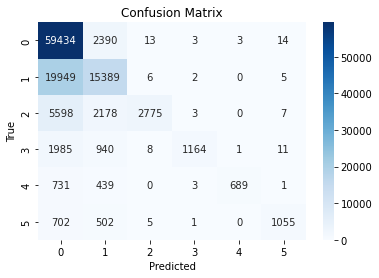

In [46]:
analysis(y_trn,y_train_predct)


Classification report               precision    recall  f1-score   support

         0.0       0.64      0.92      0.76     20619
         1.0       0.57      0.36      0.44     11784
         2.0       0.93      0.21      0.35      3521
         3.0       0.92      0.23      0.37      1369
         4.0       0.86      0.22      0.35       621
         5.0       0.84      0.28      0.42       755

    accuracy                           0.64     38669
   macro avg       0.80      0.37      0.45     38669
weighted avg       0.66      0.64      0.60     38669

accuracy 0.6384183713051799
precision 0.6384183713051799
recall 0.6384183713051799


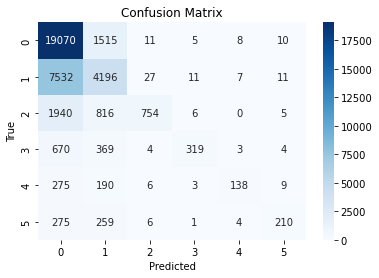

In [47]:
analysis(y_tst,y_test_predct)

In [48]:
automl10=AutoML()
automl10.fit(x_trn,y_trn,task='classification',time_budget=600)


[flaml.automl.logger: 07-22 10:37:54] {1693} INFO - task = classification
[flaml.automl.logger: 07-22 10:37:54] {1700} INFO - Data split method: stratified
[flaml.automl.logger: 07-22 10:37:54] {1703} INFO - Evaluation method: holdout
[flaml.automl.logger: 07-22 10:37:54] {1801} INFO - Minimizing error metric: log_loss
[flaml.automl.logger: 07-22 10:37:54] {1911} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 07-22 10:37:54] {2221} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 07-22 10:37:54] {2347} INFO - Estimated sufficient time budget=3254s. Estimated necessary time budget=75s.
[flaml.automl.logger: 07-22 10:37:54] {2394} INFO -  at 0.1s,	estimator lgbm's best error=1.0275,	best estimator lgbm's best error=1.0275
[flaml.automl.logger: 07-22 10:37:54] {2221} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 07-22 10:37:54] {2394} INFO -  at 0.2s,	estimator lgbm's best err

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:37:54] {2394} INFO -  at 0.4s,	estimator lgbm's best error=0.9235,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-22 10:37:54] {2221} INFO - iteration 8, current learner lgbm
[flaml.automl.logger: 07-22 10:37:54] {2394} INFO -  at 0.5s,	estimator lgbm's best error=0.9235,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-22 10:37:54] {2221} INFO - iteration 9, current learner xgboost
[flaml.automl.logger: 07-22 10:37:54] {2394} INFO -  at 0.5s,	estimator xgboost's best error=1.4443,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-22 10:37:54] {2221} INFO - iteration 10, current learner xgboost
[flaml.automl.logger: 07-22 10:37:54] {2394} INFO -  at 0.5s,	estimator xgboost's best error=1.1680,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-22 10:37:54] {2221} INFO - iteration 11, current learner extra_tree
[flaml.automl.logger: 07-22 10:37:54] {2394} INFO -  at 0.6s,	estimator extra_tree's

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:37:54] {2394} INFO -  at 0.7s,	estimator rf's best error=1.1623,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-22 10:37:54] {2221} INFO - iteration 13, current learner xgboost
[flaml.automl.logger: 07-22 10:37:55] {2394} INFO -  at 0.7s,	estimator xgboost's best error=0.9357,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-22 10:37:55] {2221} INFO - iteration 14, current learner xgboost
[flaml.automl.logger: 07-22 10:37:55] {2394} INFO -  at 0.8s,	estimator xgboost's best error=0.9357,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-22 10:37:55] {2221} INFO - iteration 15, current learner xgboost
[flaml.automl.logger: 07-22 10:37:55] {2394} INFO -  at 0.8s,	estimator xgboost's best error=0.9357,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-22 10:37:55] {2221} INFO - iteration 16, current learner rf


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:37:55] {2394} INFO -  at 0.9s,	estimator rf's best error=1.1123,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-22 10:37:55] {2221} INFO - iteration 17, current learner extra_tree
[flaml.automl.logger: 07-22 10:37:55] {2394} INFO -  at 0.9s,	estimator extra_tree's best error=1.1620,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-22 10:37:55] {2221} INFO - iteration 18, current learner lgbm
[flaml.automl.logger: 07-22 10:37:55] {2394} INFO -  at 1.1s,	estimator lgbm's best error=0.9235,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-22 10:37:55] {2221} INFO - iteration 19, current learner xgboost
[flaml.automl.logger: 07-22 10:37:55] {2394} INFO -  at 1.1s,	estimator xgboost's best error=0.9293,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-22 10:37:55] {2221} INFO - iteration 20, current learner lgbm


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:37:55] {2394} INFO -  at 1.4s,	estimator lgbm's best error=0.9008,	best estimator lgbm's best error=0.9008
[flaml.automl.logger: 07-22 10:37:55] {2221} INFO - iteration 21, current learner rf
[flaml.automl.logger: 07-22 10:37:55] {2394} INFO -  at 1.4s,	estimator rf's best error=1.1123,	best estimator lgbm's best error=0.9008
[flaml.automl.logger: 07-22 10:37:55] {2221} INFO - iteration 22, current learner lgbm
[flaml.automl.logger: 07-22 10:37:55] {2394} INFO -  at 1.6s,	estimator lgbm's best error=0.9008,	best estimator lgbm's best error=0.9008
[flaml.automl.logger: 07-22 10:37:55] {2221} INFO - iteration 23, current learner lgbm
[flaml.automl.logger: 07-22 10:37:56] {2394} INFO -  at 2.4s,	estimator lgbm's best error=0.8824,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:37:56] {2221} INFO - iteration 24, current learner xgboost
[flaml.automl.logger: 07-22 10:37:56] {2394} INFO -  at 2.5s,	estimator xgboost's best error=0.9257,	

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:37:57] {2394} INFO -  at 3.6s,	estimator lgbm's best error=0.8824,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:37:57] {2221} INFO - iteration 27, current learner rf
[flaml.automl.logger: 07-22 10:37:58] {2394} INFO -  at 3.7s,	estimator rf's best error=1.1123,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:37:58] {2221} INFO - iteration 28, current learner xgboost
[flaml.automl.logger: 07-22 10:37:58] {2394} INFO -  at 3.8s,	estimator xgboost's best error=0.9244,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:37:58] {2221} INFO - iteration 29, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:37:58] {2394} INFO -  at 3.9s,	estimator xgboost's best error=0.9219,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:37:58] {2221} INFO - iteration 30, current learner lgbm
[flaml.automl.logger: 07-22 10:37:58] {2394} INFO -  at 4.6s,	estimator lgbm's best error=0.8824,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:37:58] {2221} INFO - iteration 31, current learner lgbm
[flaml.automl.logger: 07-22 10:37:59] {2394} INFO -  at 5.2s,	estimator lgbm's best error=0.8824,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:37:59] {2221} INFO - iteration 32, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:37:59] {2394} INFO -  at 5.4s,	estimator xgb_limitdepth's best error=0.9445,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:37:59] {2221} INFO - iteration 33, current learner xgboost
[flaml.automl.logger: 07-22 10:37:59] {2394} INFO -  at 5.5s,	estimator xgboost's best error=0.9219,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:37:59] {2221} INFO - iteration 34, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:37:59] {2394} INFO -  at 5.7s,	estimator xgb_limitdepth's best error=0.9445,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:37:59] {2221} INFO - iteration 35, current learner rf
[flaml.automl.logger: 07-22 10:38:00] {2394} INFO -  at 5.8s,	estimator rf's best error=1.0410,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:38:00] {2221} INFO - iteration 36, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:38:00] {2394} INFO -  at 6.0s,	estimator xgb_limitdepth's best error=0.9445,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:38:00] {2221} INFO - iteration 37, current learner xgb_limitdepth
[flaml.automl.logger: 07-22 10:38:00] {2394} INFO -  at 6.1s,	estimator xgb_limitdepth's best error=0.9425,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:38:00] {2221} INFO - iteration 38, current learner rf


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:38:00] {2394} INFO -  at 6.3s,	estimator rf's best error=1.0410,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:38:00] {2221} INFO - iteration 39, current learner rf
[flaml.automl.logger: 07-22 10:38:00] {2394} INFO -  at 6.4s,	estimator rf's best error=1.0349,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:38:00] {2221} INFO - iteration 40, current learner lgbm
[flaml.automl.logger: 07-22 10:38:01] {2394} INFO -  at 7.2s,	estimator lgbm's best error=0.8824,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:38:01] {2221} INFO - iteration 41, current learner xgboost
[flaml.automl.logger: 07-22 10:38:01] {2394} INFO -  at 7.3s,	estimator xgboost's best error=0.9219,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:38:01] {2221} INFO - iteration 42, current learner extra_tree
[flaml.automl.logger: 07-22 10:38:01] {2394} INFO -  at 7.4s,	estimator extra_tree's best erro

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:38:03] {2394} INFO -  at 8.8s,	estimator lgbm's best error=0.8824,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:38:03] {2221} INFO - iteration 44, current learner xgboost
[flaml.automl.logger: 07-22 10:38:03] {2394} INFO -  at 9.0s,	estimator xgboost's best error=0.9219,	best estimator lgbm's best error=0.8824


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:38:03] {2221} INFO - iteration 45, current learner xgb_limitdepth
[flaml.automl.logger: 07-22 10:38:03] {2394} INFO -  at 9.2s,	estimator xgb_limitdepth's best error=0.9425,	best estimator lgbm's best error=0.8824


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:38:03] {2221} INFO - iteration 46, current learner xgboost
[flaml.automl.logger: 07-22 10:38:03] {2394} INFO -  at 9.3s,	estimator xgboost's best error=0.9219,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:38:03] {2221} INFO - iteration 47, current learner lgbm


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:38:04] {2394} INFO -  at 9.9s,	estimator lgbm's best error=0.8824,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:38:04] {2221} INFO - iteration 48, current learner lrl1
[flaml.automl.logger: 07-22 10:38:05] {2394} INFO -  at 11.0s,	estimator lrl1's best error=1.1520,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:38:05] {2221} INFO - iteration 49, current learner lrl1


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-22 10:38:06] {2394} INFO -  at 11.9s,	estimator lrl1's best error=1.1520,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-22 10:38:06] {2221} INFO - iteration 50, current learner lgbm


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-22 10:38:07] {2394} INFO -  at 13.0s,	estimator lgbm's best error=0.8816,	best estimator lgbm's best error=0.8816
[flaml.automl.logger: 07-22 10:38:07] {2221} INFO - iteration 51, current learner lrl1
[flaml.automl.logger: 07-22 10:38:08] {2394} INFO -  at 14.4s,	estimator lrl1's best error=1.1520,	best estimator lgbm's best error=0.8816
[flaml.automl.logger: 07-22 10:38:08] {2221} INFO - iteration 52, current learner lrl1


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-22 10:38:22] {2394} INFO -  at 28.6s,	estimator lrl1's best error=1.1363,	best estimator lgbm's best error=0.8816
[flaml.automl.logger: 07-22 10:38:22] {2221} INFO - iteration 53, current learner lgbm


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-22 10:38:23] {2394} INFO -  at 29.2s,	estimator lgbm's best error=0.8816,	best estimator lgbm's best error=0.8816
[flaml.automl.logger: 07-22 10:38:23] {2221} INFO - iteration 54, current learner lgbm
[flaml.automl.logger: 07-22 10:38:23] {2394} INFO -  at 29.6s,	estimator lgbm's best error=0.8816,	best estimator lgbm's best error=0.8816
[flaml.automl.logger: 07-22 10:38:23] {2221} INFO - iteration 55, current learner lgbm
[flaml.automl.logger: 07-22 10:38:27] {2394} INFO -  at 32.8s,	estimator lgbm's best error=0.8806,	best estimator lgbm's best error=0.8806
[flaml.automl.logger: 07-22 10:38:27] {2221} INFO - iteration 56, current learner lgbm
[flaml.automl.logger: 07-22 10:38:31] {2394} INFO -  at 37.4s,	estimator lgbm's best error=0.8798,	best estimator lgbm's best error=0.8798
[flaml.automl.logger: 07-22 10:38:31] {2221} INFO - iteration 57, current learner rf
[flaml.automl.logger: 07-22 10:38:31] {2394} INFO -  at 37.6s,	estimator rf's best error=1.0092,	b

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:39:01] {2394} INFO -  at 66.8s,	estimator xgboost's best error=0.9210,	best estimator lgbm's best error=0.8792
[flaml.automl.logger: 07-22 10:39:01] {2221} INFO - iteration 66, current learner lgbm
[flaml.automl.logger: 07-22 10:39:02] {2394} INFO -  at 68.7s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:39:02] {2221} INFO - iteration 67, current learner rf
[flaml.automl.logger: 07-22 10:39:03] {2394} INFO -  at 68.8s,	estimator rf's best error=1.0092,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:39:03] {2221} INFO - iteration 68, current learner xgboost
[flaml.automl.logger: 07-22 10:39:03] {2394} INFO -  at 69.0s,	estimator xgboost's best error=0.9210,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:39:03] {2221} INFO - iteration 69, current learner rf


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:39:04] {2394} INFO -  at 70.1s,	estimator rf's best error=0.9930,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:39:04] {2221} INFO - iteration 70, current learner lgbm
[flaml.automl.logger: 07-22 10:39:09] {2394} INFO -  at 75.3s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:39:09] {2221} INFO - iteration 71, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:39:10] {2394} INFO -  at 75.8s,	estimator xgboost's best error=0.9210,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:39:10] {2221} INFO - iteration 72, current learner extra_tree
[flaml.automl.logger: 07-22 10:39:10] {2394} INFO -  at 75.9s,	estimator extra_tree's best error=1.1518,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:39:10] {2221} INFO - iteration 73, current learner extra_tree
[flaml.automl.logger: 07-22 10:39:10] {2394} INFO -  at 76.1s,	estimator extra_tree's best error=1.1495,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:39:10] {2221} INFO - iteration 74, current learner xgb_limitdepth
[flaml.automl.logger: 07-22 10:39:10] {2394} INFO -  at 76.1s,	estimator xgb_limitdepth's best error=0.9425,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:39:10] {2221} INFO - iteration 75, current learner xgboost
[flaml.automl.logger: 07-22 10:39:10] {2394} I

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:39:11] {2394} INFO -  at 76.8s,	estimator xgb_limitdepth's best error=0.9425,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:39:11] {2221} INFO - iteration 77, current learner lgbm
[flaml.automl.logger: 07-22 10:39:12] {2394} INFO -  at 77.9s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:39:12] {2221} INFO - iteration 78, current learner lgbm
[flaml.automl.logger: 07-22 10:39:13] {2394} INFO -  at 78.8s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:39:13] {2221} INFO - iteration 79, current learner extra_tree
[flaml.automl.logger: 07-22 10:39:13] {2394} INFO -  at 78.9s,	estimator extra_tree's best error=1.1413,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:39:13] {2221} INFO - iteration 80, current learner extra_tree
[flaml.automl.logger: 07-22 10:39:13] {2394} INFO -  at 79.0s,	estim

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:39:21] {2394} INFO -  at 87.3s,	estimator xgb_limitdepth's best error=0.8910,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:39:21] {2221} INFO - iteration 83, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:39:23] {2394} INFO -  at 89.0s,	estimator xgb_limitdepth's best error=0.8910,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:39:23] {2221} INFO - iteration 84, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:39:24] {2394} INFO -  at 90.2s,	estimator xgb_limitdepth's best error=0.8910,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:39:24] {2221} INFO - iteration 85, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:39:26] {2394} INFO -  at 92.3s,	estimator xgb_limitdepth's best error=0.8889,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:39:26] {2221} INFO - iteration 86, current learner extra_tree
[flaml.automl.logger: 07-22 10:39:26] {2394} INFO -  at 92.4s,	estimator extra_tree's best error=1.1396,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:39:26] {2221} INFO - iteration 87, current learner rf
[flaml.automl.logger: 07-22 10:39:27] {2394} INFO -  at 93.0s,	estimator rf's best error=0.9920,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:39:27] {2221} INFO - iteration 88, current learner extra_tree
[flaml.automl.logger: 07-22 10:39:27] {2394} INFO -  at 93.1s,	estimator extra_tree's best error=1.1396,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:39:27] {2221} INFO - iteration 89, current learner lgbm
[flaml.automl.logger: 07-22 10:39:28] {2394} INFO -  at 94.0s,	est

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:39:33] {2394} INFO -  at 98.9s,	estimator xgb_limitdepth's best error=0.8889,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:39:33] {2221} INFO - iteration 92, current learner lgbm
[flaml.automl.logger: 07-22 10:39:35] {2394} INFO -  at 100.9s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:39:35] {2221} INFO - iteration 93, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:39:36] {2394} INFO -  at 102.0s,	estimator xgb_limitdepth's best error=0.8889,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:39:36] {2221} INFO - iteration 94, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:39:37] {2394} INFO -  at 102.8s,	estimator xgboost's best error=0.9210,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:39:37] {2221} INFO - iteration 95, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:39:38] {2394} INFO -  at 104.5s,	estimator xgboost's best error=0.9045,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:39:38] {2221} INFO - iteration 96, current learner lgbm
[flaml.automl.logger: 07-22 10:39:41] {2394} INFO -  at 107.5s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:39:41] {2221} INFO - iteration 97, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:39:46] {2394} INFO -  at 112.0s,	estimator xgb_limitdepth's best error=0.8855,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:39:46] {2221} INFO - iteration 98, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:39:46] {2394} INFO -  at 112.6s,	estimator xgboost's best error=0.9045,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:39:46] {2221} INFO - iteration 99, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:39:52] {2394} INFO -  at 117.9s,	estimator xgboost's best error=0.8792,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:39:52] {2221} INFO - iteration 100, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:39:55] {2394} INFO -  at 121.3s,	estimator xgboost's best error=0.8792,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:39:55] {2221} INFO - iteration 101, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:40:02] {2394} INFO -  at 128.1s,	estimator xgboost's best error=0.8792,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:40:02] {2221} INFO - iteration 102, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:40:03] {2394} INFO -  at 129.6s,	estimator xgb_limitdepth's best error=0.8855,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:40:03] {2221} INFO - iteration 103, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:40:07] {2394} INFO -  at 132.8s,	estimator xgboost's best error=0.8792,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:40:07] {2221} INFO - iteration 104, current learner lgbm
[flaml.automl.logger: 07-22 10:40:15] {2394} INFO -  at 141.2s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:40:15] {2221} INFO - iteration 105, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:40:25] {2394} INFO -  at 150.8s,	estimator xgboost's best error=0.8792,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:40:25] {2221} INFO - iteration 106, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:40:26] {2394} INFO -  at 151.9s,	estimator xgboost's best error=0.8792,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:40:26] {2221} INFO - iteration 107, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:40:56] {2394} INFO -  at 182.5s,	estimator xgboost's best error=0.8792,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:40:56] {2221} INFO - iteration 108, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:41:06] {2394} INFO -  at 192.1s,	estimator xgb_limitdepth's best error=0.8855,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:41:06] {2221} INFO - iteration 109, current learner lgbm
[flaml.automl.logger: 07-22 10:41:06] {2394} INFO -  at 192.6s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:41:06] {2221} INFO - iteration 110, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:41:09] {2394} INFO -  at 194.9s,	estimator xgb_limitdepth's best error=0.8855,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:41:09] {2221} INFO - iteration 111, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:41:12] {2394} INFO -  at 198.3s,	estimator xgboost's best error=0.8792,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:41:12] {2221} INFO - iteration 112, current learner lgbm
[flaml.automl.logger: 07-22 10:41:16] {2394} INFO -  at 202.6s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:41:16] {2221} INFO - iteration 113, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:41:23] {2394} INFO -  at 209.5s,	estimator xgb_limitdepth's best error=0.8855,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:41:23] {2221} INFO - iteration 114, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:41:32] {2394} INFO -  at 218.2s,	estimator xgboost's best error=0.8792,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:41:32] {2221} INFO - iteration 115, current learner lrl1
[flaml.automl.logger: 07-22 10:41:45] {2394} INFO -  at 231.2s,	estimator lrl1's best error=1.1363,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:41:45] {2221} INFO - iteration 116, current learner lgbm


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-22 10:41:46] {2394} INFO -  at 231.8s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:41:46] {2221} INFO - iteration 117, current learner lgbm
[flaml.automl.logger: 07-22 10:41:58] {2394} INFO -  at 244.6s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:41:58] {2221} INFO - iteration 118, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:42:00] {2394} INFO -  at 246.3s,	estimator xgb_limitdepth's best error=0.8855,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:42:00] {2221} INFO - iteration 119, current learner extra_tree
[flaml.automl.logger: 07-22 10:42:00] {2394} INFO -  at 246.4s,	estimator extra_tree's best error=1.1282,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:42:00] {2221} INFO - iteration 120, current learner lgbm
[flaml.automl.logger: 07-22 10:42:01] {2394} INFO -  at 246.9s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:42:01] {2221} INFO - iteration 121, current learner extra_tree
[flaml.automl.logger: 07-22 10:42:01] {2394} INFO -  at 247.0s,	estimator extra_tree's best error=1.1282,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-22 10:42:01] {2221} INFO - iteration 122, current learner extra_tree
[flaml.automl.logger: 07-22 10:42:01] {2394} INF

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:43:11] {2394} INFO -  at 316.8s,	estimator xgb_limitdepth's best error=0.8839,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-22 10:43:11] {2221} INFO - iteration 138, current learner extra_tree
[flaml.automl.logger: 07-22 10:43:11] {2394} INFO -  at 317.5s,	estimator extra_tree's best error=1.0771,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-22 10:43:11] {2221} INFO - iteration 139, current learner lgbm
[flaml.automl.logger: 07-22 10:43:14] {2394} INFO -  at 319.8s,	estimator lgbm's best error=0.8775,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-22 10:43:14] {2221} INFO - iteration 140, current learner extra_tree
[flaml.automl.logger: 07-22 10:43:14] {2394} INFO -  at 320.6s,	estimator extra_tree's best error=1.0771,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-22 10:43:14] {2221} INFO - iteration 141, current learner lgbm
[flaml.automl.logger: 07-22 10:44:38] {2394} INFO -  a

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:44:40] {2394} INFO -  at 406.0s,	estimator xgboost's best error=0.8792,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-22 10:44:40] {2221} INFO - iteration 144, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:44:43] {2394} INFO -  at 409.2s,	estimator xgb_limitdepth's best error=0.8839,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-22 10:44:43] {2221} INFO - iteration 145, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:45:10] {2394} INFO -  at 435.9s,	estimator xgboost's best error=0.8770,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-22 10:45:10] {2221} INFO - iteration 146, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:45:50] {2394} INFO -  at 476.1s,	estimator xgboost's best error=0.8770,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-22 10:45:50] {2221} INFO - iteration 147, current learner rf
[flaml.automl.logger: 07-22 10:45:51] {2394} INFO -  at 477.6s,	estimator rf's best error=0.9507,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-22 10:45:51] {2221} INFO - iteration 148, current learner rf
[flaml.automl.logger: 07-22 10:45:53] {2394} INFO -  at 478.7s,	estimator rf's best error=0.9507,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-22 10:45:53] {2221} INFO - iteration 149, current learner rf
[flaml.automl.logger: 07-22 10:45:54] {2394} INFO -  at 479.8s,	estimator rf's best error=0.9507,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-22 10:45:54] {2221} INFO - iteration 150, current learner rf
[flaml.automl.logger: 07-22 10:45:57] {2394} INFO -  at 482.8s,	estimator rf's best err

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:46:25] {2394} INFO -  at 510.7s,	estimator xgboost's best error=0.8770,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-22 10:46:25] {2221} INFO - iteration 154, current learner rf
[flaml.automl.logger: 07-22 10:46:30] {2394} INFO -  at 516.5s,	estimator rf's best error=0.8930,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-22 10:46:30] {2221} INFO - iteration 155, current learner rf
[flaml.automl.logger: 07-22 10:46:36] {2394} INFO -  at 521.7s,	estimator rf's best error=0.8930,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-22 10:46:36] {2221} INFO - iteration 156, current learner rf
[flaml.automl.logger: 07-22 10:46:41] {2394} INFO -  at 527.5s,	estimator rf's best error=0.8930,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-22 10:46:41] {2221} INFO - iteration 157, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:47:11] {2394} INFO -  at 557.5s,	estimator xgb_limitdepth's best error=0.8815,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-22 10:47:11] {2221} INFO - iteration 158, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:47:53] {2394} INFO -  at 598.8s,	estimator xgboost's best error=0.8770,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-22 10:47:53] {2221} INFO - iteration 159, current learner extra_tree
[flaml.automl.logger: 07-22 10:47:53] {2394} INFO -  at 599.4s,	estimator extra_tree's best error=1.0742,	best estimator xgboost's best error=0.8770


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-22 10:48:21] {2630} INFO - retrain xgboost for 27.3s
[flaml.automl.logger: 07-22 10:48:21] {2633} INFO - retrained model: XGBClassifier(base_score=None, booster=None, callbacks=[],
              colsample_bylevel=0.810713836120108, colsample_bynode=None,
              colsample_bytree=0.964549124592507, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy='lossguide',
              importance_type=None, interaction_constraints=None,
              learning_rate=0.04800646952945705, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=0, max_leaves=59,
              min_child_weight=13.402821578829917, missing=nan,
              monotone_constraints=None, n_estimators=437, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob',
              predictor=None, ...)
[flaml.auto

In [49]:
y_test_predct10=automl10.predict(x_tst)
y_train_predct10=automl10.predict(x_trn)

In [50]:
print("Train acrcy",f1_score(y_train_predct10,y_trn,average='micro').round(4))
print("Test acrcy",f1_score(y_test_predct10,y_tst,average='micro').round(4))

Train acrcy 0.6823
Test acrcy 0.6388


Classification report               precision    recall  f1-score   support

         0.0       0.67      0.96      0.79     61857
         1.0       0.68      0.43      0.53     35351
         2.0       0.97      0.24      0.38     10561
         3.0       0.99      0.24      0.38      4109
         4.0       0.99      0.25      0.40      1863
         5.0       0.92      0.37      0.53      2265

    accuracy                           0.68    116006
   macro avg       0.87      0.41      0.50    116006
weighted avg       0.72      0.68      0.64    116006

accuracy 0.6823181559574505
precision 0.6823181559574505
recall 0.6823181559574505


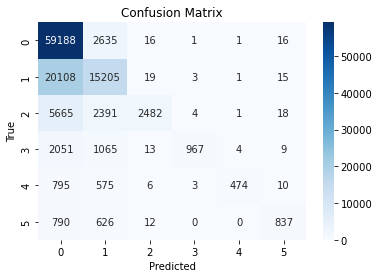

In [51]:
analysis(y_trn,y_train_predct10)

Classification report               precision    recall  f1-score   support

         0.0       0.64      0.92      0.76     20619
         1.0       0.57      0.36      0.44     11784
         2.0       0.94      0.21      0.35      3521
         3.0       0.96      0.23      0.37      1369
         4.0       0.95      0.22      0.36       621
         5.0       0.84      0.28      0.42       755

    accuracy                           0.64     38669
   macro avg       0.81      0.37      0.45     38669
weighted avg       0.67      0.64      0.60     38669

accuracy 0.6387804184230262
precision 0.6387804184230262
recall 0.6387804184230262


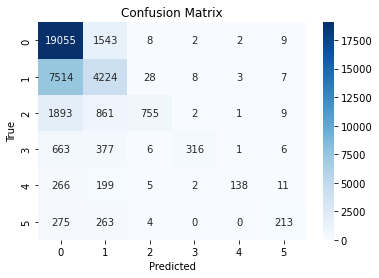

In [52]:
analysis(y_tst,y_test_predct10)

In [70]:
automl30=AutoML()

In [71]:
automl30.fit(x_trn,y_trn,task='classification',time_budget=1800)

[flaml.automl.logger: 07-16 21:05:54] {1693} INFO - task = classification
[flaml.automl.logger: 07-16 21:05:54] {1700} INFO - Data split method: stratified
[flaml.automl.logger: 07-16 21:05:54] {1703} INFO - Evaluation method: holdout
[flaml.automl.logger: 07-16 21:05:54] {1801} INFO - Minimizing error metric: log_loss
[flaml.automl.logger: 07-16 21:05:54] {1911} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 07-16 21:05:54] {2221} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 07-16 21:05:54] {2347} INFO - Estimated sufficient time budget=3256s. Estimated necessary time budget=75s.
[flaml.automl.logger: 07-16 21:05:54] {2394} INFO -  at 0.1s,	estimator lgbm's best error=1.0275,	best estimator lgbm's best error=1.0275
[flaml.automl.logger: 07-16 21:05:54] {2221} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 07-16 21:05:54] {2394} INFO -  at 0.2s,	estimator lgbm's best err

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:05:54] {2394} INFO -  at 0.5s,	estimator xgboost's best error=1.1680,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-16 21:05:54] {2221} INFO - iteration 11, current learner extra_tree
[flaml.automl.logger: 07-16 21:05:54] {2394} INFO -  at 0.6s,	estimator extra_tree's best error=1.1727,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-16 21:05:54] {2221} INFO - iteration 12, current learner rf
[flaml.automl.logger: 07-16 21:05:55] {2394} INFO -  at 0.7s,	estimator rf's best error=1.1623,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-16 21:05:55] {2221} INFO - iteration 13, current learner xgboost
[flaml.automl.logger: 07-16 21:05:55] {2394} INFO -  at 0.7s,	estimator xgboost's best error=0.9357,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-16 21:05:55] {2221} INFO - iteration 14, current learner xgboost
[flaml.automl.logger: 07-16 21:05:55] {2394} INFO -  at 0.7s,	estimator xgboost'

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:05:55] {2394} INFO -  at 0.9s,	estimator rf's best error=1.1123,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-16 21:05:55] {2221} INFO - iteration 17, current learner extra_tree
[flaml.automl.logger: 07-16 21:05:55] {2394} INFO -  at 0.9s,	estimator extra_tree's best error=1.1620,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-16 21:05:55] {2221} INFO - iteration 18, current learner lgbm
[flaml.automl.logger: 07-16 21:05:55] {2394} INFO -  at 1.1s,	estimator lgbm's best error=0.9008,	best estimator lgbm's best error=0.9008
[flaml.automl.logger: 07-16 21:05:55] {2221} INFO - iteration 19, current learner xgboost
[flaml.automl.logger: 07-16 21:05:55] {2394} INFO -  at 1.2s,	estimator xgboost's best error=0.9293,	best estimator lgbm's best error=0.9008
[flaml.automl.logger: 07-16 21:05:55] {2221} INFO - iteration 20, current learner lgbm


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:05:55] {2394} INFO -  at 1.3s,	estimator lgbm's best error=0.9008,	best estimator lgbm's best error=0.9008
[flaml.automl.logger: 07-16 21:05:55] {2221} INFO - iteration 21, current learner rf
[flaml.automl.logger: 07-16 21:05:55] {2394} INFO -  at 1.4s,	estimator rf's best error=1.1123,	best estimator lgbm's best error=0.9008
[flaml.automl.logger: 07-16 21:05:55] {2221} INFO - iteration 22, current learner lgbm
[flaml.automl.logger: 07-16 21:05:56] {2394} INFO -  at 2.1s,	estimator lgbm's best error=0.8824,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-16 21:05:56] {2221} INFO - iteration 23, current learner lgbm
[flaml.automl.logger: 07-16 21:05:57] {2394} INFO -  at 3.1s,	estimator lgbm's best error=0.8824,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-16 21:05:57] {2221} INFO - iteration 24, current learner xgboost
[flaml.automl.logger: 07-16 21:05:57] {2394} INFO -  at 3.2s,	estimator xgboost's best error=0.9257,	

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:05:58] {2394} INFO -  at 3.8s,	estimator lgbm's best error=0.8824,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-16 21:05:58] {2221} INFO - iteration 27, current learner xgboost
[flaml.automl.logger: 07-16 21:05:58] {2394} INFO -  at 3.8s,	estimator xgboost's best error=0.9244,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-16 21:05:58] {2221} INFO - iteration 28, current learner xgboost
[flaml.automl.logger: 07-16 21:05:58] {2394} INFO -  at 4.0s,	estimator xgboost's best error=0.9219,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-16 21:05:58] {2221} INFO - iteration 29, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:05:58] {2394} INFO -  at 4.0s,	estimator xgboost's best error=0.9219,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-16 21:05:58] {2221} INFO - iteration 30, current learner lgbm
[flaml.automl.logger: 07-16 21:05:59] {2394} INFO -  at 4.8s,	estimator lgbm's best error=0.8824,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-16 21:05:59] {2221} INFO - iteration 31, current learner lgbm
[flaml.automl.logger: 07-16 21:05:59] {2394} INFO -  at 5.6s,	estimator lgbm's best error=0.8824,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-16 21:05:59] {2221} INFO - iteration 32, current learner lgbm
[flaml.automl.logger: 07-16 21:06:01] {2394} INFO -  at 7.2s,	estimator lgbm's best error=0.8824,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-16 21:06:01] {2221} INFO - iteration 33, current learner extra_tree
[flaml.automl.logger: 07-16 21:06:01] {2394} INFO -  at 7.3s,	estimator extra_tree's best e

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:06:02] {2394} INFO -  at 8.2s,	estimator xgb_limitdepth's best error=0.9445,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-16 21:06:02] {2221} INFO - iteration 37, current learner xgb_limitdepth
[flaml.automl.logger: 07-16 21:06:02] {2394} INFO -  at 8.4s,	estimator xgb_limitdepth's best error=0.9445,	best estimator lgbm's best error=0.8824


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:06:02] {2221} INFO - iteration 38, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:06:02] {2394} INFO -  at 8.6s,	estimator xgb_limitdepth's best error=0.9445,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-16 21:06:02] {2221} INFO - iteration 39, current learner xgb_limitdepth
[flaml.automl.logger: 07-16 21:06:03] {2394} INFO -  at 8.8s,	estimator xgb_limitdepth's best error=0.9425,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-16 21:06:03] {2221} INFO - iteration 40, current learner rf


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:06:03] {2394} INFO -  at 8.9s,	estimator rf's best error=1.0410,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-16 21:06:03] {2221} INFO - iteration 41, current learner rf
[flaml.automl.logger: 07-16 21:06:03] {2394} INFO -  at 9.0s,	estimator rf's best error=1.0410,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-16 21:06:03] {2221} INFO - iteration 42, current learner xgboost
[flaml.automl.logger: 07-16 21:06:03] {2394} INFO -  at 9.1s,	estimator xgboost's best error=0.9219,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-16 21:06:03] {2221} INFO - iteration 43, current learner lgbm


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:06:04] {2394} INFO -  at 10.3s,	estimator lgbm's best error=0.8816,	best estimator lgbm's best error=0.8816
[flaml.automl.logger: 07-16 21:06:04] {2221} INFO - iteration 44, current learner rf
[flaml.automl.logger: 07-16 21:06:04] {2394} INFO -  at 10.5s,	estimator rf's best error=1.0349,	best estimator lgbm's best error=0.8816
[flaml.automl.logger: 07-16 21:06:04] {2221} INFO - iteration 45, current learner lrl1
[flaml.automl.logger: 07-16 21:06:05] {2394} INFO -  at 11.6s,	estimator lrl1's best error=1.1520,	best estimator lgbm's best error=0.8816
[flaml.automl.logger: 07-16 21:06:05] {2221} INFO - iteration 46, current learner lrl1


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-16 21:06:06] {2394} INFO -  at 12.4s,	estimator lrl1's best error=1.1520,	best estimator lgbm's best error=0.8816
[flaml.automl.logger: 07-16 21:06:06] {2221} INFO - iteration 47, current learner lrl1


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-16 21:06:08] {2394} INFO -  at 13.7s,	estimator lrl1's best error=1.1520,	best estimator lgbm's best error=0.8816
[flaml.automl.logger: 07-16 21:06:08] {2221} INFO - iteration 48, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:06:08] {2394} INFO -  at 13.9s,	estimator xgboost's best error=0.9219,	best estimator lgbm's best error=0.8816
[flaml.automl.logger: 07-16 21:06:08] {2221} INFO - iteration 49, current learner lrl1
[flaml.automl.logger: 07-16 21:06:21] {2394} INFO -  at 27.0s,	estimator lrl1's best error=1.1363,	best estimator lgbm's best error=0.8816
[flaml.automl.logger: 07-16 21:06:21] {2221} INFO - iteration 50, current learner lgbm


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-16 21:06:21] {2394} INFO -  at 27.6s,	estimator lgbm's best error=0.8816,	best estimator lgbm's best error=0.8816
[flaml.automl.logger: 07-16 21:06:21] {2221} INFO - iteration 51, current learner rf
[flaml.automl.logger: 07-16 21:06:22] {2394} INFO -  at 27.7s,	estimator rf's best error=1.0092,	best estimator lgbm's best error=0.8816
[flaml.automl.logger: 07-16 21:06:22] {2221} INFO - iteration 52, current learner xgboost
[flaml.automl.logger: 07-16 21:06:22] {2394} INFO -  at 27.8s,	estimator xgboost's best error=0.9219,	best estimator lgbm's best error=0.8816
[flaml.automl.logger: 07-16 21:06:22] {2221} INFO - iteration 53, current learner rf
[flaml.automl.logger: 07-16 21:06:22] {2394} INFO -  at 27.9s,	estimator rf's best error=1.0092,	best estimator lgbm's best error=0.8816


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:06:22] {2221} INFO - iteration 54, current learner rf
[flaml.automl.logger: 07-16 21:06:22] {2394} INFO -  at 28.1s,	estimator rf's best error=1.0092,	best estimator lgbm's best error=0.8816
[flaml.automl.logger: 07-16 21:06:22] {2221} INFO - iteration 55, current learner lgbm
[flaml.automl.logger: 07-16 21:06:22] {2394} INFO -  at 28.5s,	estimator lgbm's best error=0.8816,	best estimator lgbm's best error=0.8816
[flaml.automl.logger: 07-16 21:06:22] {2221} INFO - iteration 56, current learner lgbm
[flaml.automl.logger: 07-16 21:06:25] {2394} INFO -  at 31.6s,	estimator lgbm's best error=0.8806,	best estimator lgbm's best error=0.8806
[flaml.automl.logger: 07-16 21:06:25] {2221} INFO - iteration 57, current learner rf
[flaml.automl.logger: 07-16 21:06:26] {2394} INFO -  at 31.9s,	estimator rf's best error=1.0092,	best estimator lgbm's best error=0.8806
[flaml.automl.logger: 07-16 21:06:26] {2221} INFO - iteration 58, current learner lgbm
[flaml.automl.log

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:06:53] {2394} INFO -  at 59.5s,	estimator xgboost's best error=0.9210,	best estimator lgbm's best error=0.8792
[flaml.automl.logger: 07-16 21:06:53] {2221} INFO - iteration 65, current learner xgboost
[flaml.automl.logger: 07-16 21:06:53] {2394} INFO -  at 59.6s,	estimator xgboost's best error=0.9210,	best estimator lgbm's best error=0.8792
[flaml.automl.logger: 07-16 21:06:53] {2221} INFO - iteration 66, current learner lgbm


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:06:55] {2394} INFO -  at 61.1s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:06:55] {2221} INFO - iteration 67, current learner rf
[flaml.automl.logger: 07-16 21:06:56] {2394} INFO -  at 62.1s,	estimator rf's best error=0.9930,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:06:56] {2221} INFO - iteration 68, current learner extra_tree
[flaml.automl.logger: 07-16 21:06:56] {2394} INFO -  at 62.2s,	estimator extra_tree's best error=1.1518,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:06:56] {2221} INFO - iteration 69, current learner extra_tree
[flaml.automl.logger: 07-16 21:06:56] {2394} INFO -  at 62.3s,	estimator extra_tree's best error=1.1495,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:06:56] {2221} INFO - iteration 70, current learner lgbm
[flaml.automl.logger: 07-16 21:07:00] {2394} INFO -  at 66.2s,	estimator lgb

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:07:01] {2394} INFO -  at 66.7s,	estimator xgboost's best error=0.9210,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:01] {2221} INFO - iteration 72, current learner extra_tree
[flaml.automl.logger: 07-16 21:07:01] {2394} INFO -  at 66.8s,	estimator extra_tree's best error=1.1413,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:01] {2221} INFO - iteration 73, current learner extra_tree
[flaml.automl.logger: 07-16 21:07:01] {2394} INFO -  at 67.0s,	estimator extra_tree's best error=1.1413,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:01] {2221} INFO - iteration 74, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:07:01] {2394} INFO -  at 67.2s,	estimator xgb_limitdepth's best error=0.9425,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:01] {2221} INFO - iteration 75, current learner extra_tree
[flaml.automl.logger: 07-16 21:07:01] {2394} INFO -  at 67.2s,	estimator extra_tree's best error=1.1396,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:01] {2221} INFO - iteration 76, current learner xgb_limitdepth
[flaml.automl.logger: 07-16 21:07:01] {2394} INFO -  at 67.3s,	estimator xgb_limitdepth's best error=0.9425,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:01] {2221} INFO - iteration 77, current learner lgbm


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:07:02] {2394} INFO -  at 68.2s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:02] {2221} INFO - iteration 78, current learner lgbm
[flaml.automl.logger: 07-16 21:07:03] {2394} INFO -  at 69.0s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:03] {2221} INFO - iteration 79, current learner extra_tree
[flaml.automl.logger: 07-16 21:07:03] {2394} INFO -  at 69.1s,	estimator extra_tree's best error=1.1396,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:03] {2221} INFO - iteration 80, current learner rf
[flaml.automl.logger: 07-16 21:07:04] {2394} INFO -  at 69.7s,	estimator rf's best error=0.9920,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:04] {2221} INFO - iteration 81, current learner lgbm
[flaml.automl.logger: 07-16 21:07:09] {2394} INFO -  at 75.2s,	estimator lgbm's best err

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:07:10] {2394} INFO -  at 75.7s,	estimator xgb_limitdepth's best error=0.9425,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:10] {2221} INFO - iteration 83, current learner lgbm
[flaml.automl.logger: 07-16 21:07:11] {2394} INFO -  at 76.7s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:11] {2221} INFO - iteration 84, current learner extra_tree
[flaml.automl.logger: 07-16 21:07:11] {2394} INFO -  at 76.8s,	estimator extra_tree's best error=1.1282,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:11] {2221} INFO - iteration 85, current learner extra_tree
[flaml.automl.logger: 07-16 21:07:11] {2394} INFO -  at 76.8s,	estimator extra_tree's best error=1.1282,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:11] {2221} INFO - iteration 86, current learner extra_tree
[flaml.automl.logger: 07-16 21:07:11] {2394} INFO -  at 

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:07:13] {2394} INFO -  at 79.3s,	estimator xgb_limitdepth's best error=0.8910,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:13] {2221} INFO - iteration 94, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:07:15] {2394} INFO -  at 80.7s,	estimator xgb_limitdepth's best error=0.8910,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:15] {2221} INFO - iteration 95, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:07:16] {2394} INFO -  at 81.7s,	estimator xgb_limitdepth's best error=0.8910,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:16] {2221} INFO - iteration 96, current learner extra_tree
[flaml.automl.logger: 07-16 21:07:16] {2394} INFO -  at 82.6s,	estimator extra_tree's best error=1.0771,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:16] {2221} INFO - iteration 97, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:07:18] {2394} INFO -  at 84.3s,	estimator xgb_limitdepth's best error=0.8889,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:18] {2221} INFO - iteration 98, current learner xgboost
[flaml.automl.logger: 07-16 21:07:18] {2394} INFO -  at 84.4s,	estimator xgboost's best error=0.9210,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:18] {2221} INFO - iteration 99, current learner extra_tree


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:07:19] {2394} INFO -  at 84.7s,	estimator extra_tree's best error=1.0771,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:19] {2221} INFO - iteration 100, current learner rf
[flaml.automl.logger: 07-16 21:07:20] {2394} INFO -  at 85.7s,	estimator rf's best error=0.9920,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:20] {2221} INFO - iteration 101, current learner lgbm
[flaml.automl.logger: 07-16 21:07:22] {2394} INFO -  at 88.5s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:22] {2221} INFO - iteration 102, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:07:24] {2394} INFO -  at 89.8s,	estimator xgb_limitdepth's best error=0.8889,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:24] {2221} INFO - iteration 103, current learner extra_tree
[flaml.automl.logger: 07-16 21:07:24] {2394} INFO -  at 90.5s,	estimator extra_tree's best error=1.0771,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:24] {2221} INFO - iteration 104, current learner lgbm
[flaml.automl.logger: 07-16 21:07:26] {2394} INFO -  at 92.0s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:26] {2221} INFO - iteration 105, current learner extra_tree
[flaml.automl.logger: 07-16 21:07:26] {2394} INFO -  at 92.6s,	estimator extra_tree's best error=1.0771,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:26] {2221} INFO - iteration 106, current learner lgbm
[flaml.automl.logger: 07-16 21:07:28] {2394} INFO -  at 94

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:07:29] {2394} INFO -  at 95.2s,	estimator xgboost's best error=0.9210,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:29] {2221} INFO - iteration 108, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:07:30] {2394} INFO -  at 96.0s,	estimator xgb_limitdepth's best error=0.8889,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:30] {2221} INFO - iteration 109, current learner lgbm
[flaml.automl.logger: 07-16 21:07:37] {2394} INFO -  at 103.4s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:37] {2221} INFO - iteration 110, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:07:41] {2394} INFO -  at 106.6s,	estimator xgb_limitdepth's best error=0.8855,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:41] {2221} INFO - iteration 111, current learner extra_tree
[flaml.automl.logger: 07-16 21:07:41] {2394} INFO -  at 107.3s,	estimator extra_tree's best error=1.0771,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:41] {2221} INFO - iteration 112, current learner lgbm
[flaml.automl.logger: 07-16 21:07:42] {2394} INFO -  at 107.7s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:42] {2221} INFO - iteration 113, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:07:43] {2394} INFO -  at 109.0s,	estimator xgb_limitdepth's best error=0.8855,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:43] {2221} INFO - iteration 114, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:07:50] {2394} INFO -  at 116.5s,	estimator xgb_limitdepth's best error=0.8855,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:07:50] {2221} INFO - iteration 115, current learner lrl1
[flaml.automl.logger: 07-16 21:08:02] {2394} INFO -  at 128.2s,	estimator lrl1's best error=1.1363,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:08:02] {2221} INFO - iteration 116, current learner lgbm


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-16 21:08:14] {2394} INFO -  at 140.0s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:08:14] {2221} INFO - iteration 117, current learner lgbm
[flaml.automl.logger: 07-16 21:08:14] {2394} INFO -  at 140.6s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:08:14] {2221} INFO - iteration 118, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:08:16] {2394} INFO -  at 142.1s,	estimator xgb_limitdepth's best error=0.8855,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:08:16] {2221} INFO - iteration 119, current learner extra_tree
[flaml.automl.logger: 07-16 21:08:17] {2394} INFO -  at 142.8s,	estimator extra_tree's best error=1.0742,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:08:17] {2221} INFO - iteration 120, current learner lgbm
[flaml.automl.logger: 07-16 21:08:26] {2394} INFO -  at 151.9s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:08:26] {2221} INFO - iteration 121, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:08:30] {2394} INFO -  at 156.6s,	estimator xgb_limitdepth's best error=0.8855,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:08:30] {2221} INFO - iteration 122, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:08:32] {2394} INFO -  at 158.0s,	estimator xgb_limitdepth's best error=0.8855,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:08:32] {2221} INFO - iteration 123, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:08:40] {2394} INFO -  at 166.3s,	estimator xgb_limitdepth's best error=0.8839,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:08:40] {2221} INFO - iteration 124, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:08:41] {2394} INFO -  at 167.4s,	estimator xgboost's best error=0.9045,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:08:41] {2221} INFO - iteration 125, current learner lgbm
[flaml.automl.logger: 07-16 21:08:42] {2394} INFO -  at 167.9s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:08:42] {2221} INFO - iteration 126, current learner lgbm
[flaml.automl.logger: 07-16 21:08:42] {2394} INFO -  at 168.3s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-16 21:08:42] {2221} INFO - iteration 127, current learner lgbm
[flaml.automl.logger: 07-16 21:08:52] {2394} INFO -  at 178.4s,	estimator lgbm's best error=0.8775,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-16 21:08:52] {2221} INFO - iteration 128, current learner lgbm
[flaml.automl.logger: 07-16 21:09:22] {2394} INFO -  at 208.6s,	estimator lgbm's best

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:09:23] {2394} INFO -  at 209.1s,	estimator xgboost's best error=0.9045,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-16 21:09:23] {2221} INFO - iteration 130, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:09:27] {2394} INFO -  at 213.3s,	estimator xgboost's best error=0.8792,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-16 21:09:27] {2221} INFO - iteration 131, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:09:30] {2394} INFO -  at 216.0s,	estimator xgboost's best error=0.8792,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-16 21:09:30] {2221} INFO - iteration 132, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:09:36] {2394} INFO -  at 222.0s,	estimator xgboost's best error=0.8792,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-16 21:09:36] {2221} INFO - iteration 133, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:09:38] {2394} INFO -  at 224.6s,	estimator xgboost's best error=0.8792,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-16 21:09:38] {2221} INFO - iteration 134, current learner lgbm
[flaml.automl.logger: 07-16 21:09:43] {2394} INFO -  at 228.8s,	estimator lgbm's best error=0.8775,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-16 21:09:43] {2221} INFO - iteration 135, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:09:51] {2394} INFO -  at 236.7s,	estimator xgboost's best error=0.8792,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-16 21:09:51] {2221} INFO - iteration 136, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:09:51] {2394} INFO -  at 237.6s,	estimator xgboost's best error=0.8792,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-16 21:09:51] {2221} INFO - iteration 137, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:09:54] {2394} INFO -  at 240.2s,	estimator xgb_limitdepth's best error=0.8839,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-16 21:09:54] {2221} INFO - iteration 138, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:10:20] {2394} INFO -  at 266.6s,	estimator xgboost's best error=0.8792,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-16 21:10:20] {2221} INFO - iteration 139, current learner lgbm
[flaml.automl.logger: 07-16 21:10:22] {2394} INFO -  at 268.6s,	estimator lgbm's best error=0.8775,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-16 21:10:22] {2221} INFO - iteration 140, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:10:25] {2394} INFO -  at 271.4s,	estimator xgboost's best error=0.8792,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-16 21:10:25] {2221} INFO - iteration 141, current learner lgbm
[flaml.automl.logger: 07-16 21:11:40] {2394} INFO -  at 346.2s,	estimator lgbm's best error=0.8775,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-16 21:11:40] {2221} INFO - iteration 142, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:11:48] {2394} INFO -  at 354.0s,	estimator xgboost's best error=0.8792,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-16 21:11:48] {2221} INFO - iteration 143, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:11:49] {2394} INFO -  at 355.0s,	estimator xgboost's best error=0.8792,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-16 21:11:49] {2221} INFO - iteration 144, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:12:13] {2394} INFO -  at 378.7s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-16 21:12:13] {2221} INFO - iteration 145, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:12:31] {2394} INFO -  at 397.3s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-16 21:12:31] {2221} INFO - iteration 146, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:12:54] {2394} INFO -  at 419.9s,	estimator xgboost's best error=0.8770,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:12:54] {2221} INFO - iteration 147, current learner rf
[flaml.automl.logger: 07-16 21:12:55] {2394} INFO -  at 421.1s,	estimator rf's best error=0.9507,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:12:55] {2221} INFO - iteration 148, current learner rf
[flaml.automl.logger: 07-16 21:12:56] {2394} INFO -  at 422.3s,	estimator rf's best error=0.9507,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:12:56] {2221} INFO - iteration 149, current learner rf
[flaml.automl.logger: 07-16 21:12:57] {2394} INFO -  at 423.3s,	estimator rf's best error=0.9507,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:12:57] {2221} INFO - iteration 150, current learner rf
[flaml.automl.logger: 07-16 21:13:00] {2394} INFO -  at 426.5s,	estimator rf's best err

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:13:43] {2394} INFO -  at 469.0s,	estimator xgboost's best error=0.8770,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:13:43] {2221} INFO - iteration 154, current learner rf
[flaml.automl.logger: 07-16 21:13:48] {2394} INFO -  at 474.0s,	estimator rf's best error=0.8930,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:13:48] {2221} INFO - iteration 155, current learner rf
[flaml.automl.logger: 07-16 21:13:52] {2394} INFO -  at 478.3s,	estimator rf's best error=0.8930,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:13:52] {2221} INFO - iteration 156, current learner rf
[flaml.automl.logger: 07-16 21:13:57] {2394} INFO -  at 483.6s,	estimator rf's best error=0.8930,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:13:57] {2221} INFO - iteration 157, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:14:22] {2394} INFO -  at 507.7s,	estimator xgb_limitdepth's best error=0.8815,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:14:22] {2221} INFO - iteration 158, current learner rf
[flaml.automl.logger: 07-16 21:14:27] {2394} INFO -  at 512.7s,	estimator rf's best error=0.8930,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:14:27] {2221} INFO - iteration 159, current learner rf
[flaml.automl.logger: 07-16 21:14:30] {2394} INFO -  at 516.3s,	estimator rf's best error=0.8930,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:14:30] {2221} INFO - iteration 160, current learner rf
[flaml.automl.logger: 07-16 21:14:36] {2394} INFO -  at 522.4s,	estimator rf's best error=0.8893,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:14:36] {2221} INFO - iteration 161, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:14:56] {2394} INFO -  at 542.0s,	estimator xgboost's best error=0.8770,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:14:56] {2221} INFO - iteration 162, current learner rf
[flaml.automl.logger: 07-16 21:15:01] {2394} INFO -  at 547.0s,	estimator rf's best error=0.8862,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:15:01] {2221} INFO - iteration 163, current learner rf
[flaml.automl.logger: 07-16 21:15:08] {2394} INFO -  at 553.8s,	estimator rf's best error=0.8862,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:15:08] {2221} INFO - iteration 164, current learner lrl1
[flaml.automl.logger: 07-16 21:15:24] {2394} INFO -  at 569.8s,	estimator lrl1's best error=1.1363,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:15:24] {2221} INFO - iteration 165, current learner extra_tree


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-16 21:15:24] {2394} INFO -  at 570.6s,	estimator extra_tree's best error=1.0394,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:15:24] {2221} INFO - iteration 166, current learner extra_tree
[flaml.automl.logger: 07-16 21:15:25] {2394} INFO -  at 571.3s,	estimator extra_tree's best error=1.0394,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:15:25] {2221} INFO - iteration 167, current learner extra_tree
[flaml.automl.logger: 07-16 21:15:26] {2394} INFO -  at 571.9s,	estimator extra_tree's best error=1.0394,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:15:26] {2221} INFO - iteration 168, current learner extra_tree
[flaml.automl.logger: 07-16 21:15:26] {2394} INFO -  at 572.6s,	estimator extra_tree's best error=1.0394,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:15:26] {2221} INFO - iteration 169, current learner extra_tree
[flaml.automl.logger: 07-16 

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:16:23] {2394} INFO -  at 629.6s,	estimator xgboost's best error=0.8770,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:16:23] {2221} INFO - iteration 177, current learner lrl1
[flaml.automl.logger: 07-16 21:16:39] {2394} INFO -  at 644.7s,	estimator lrl1's best error=1.1363,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:16:39] {2221} INFO - iteration 178, current learner extra_tree


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-16 21:16:39] {2394} INFO -  at 645.1s,	estimator extra_tree's best error=1.0394,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:16:39] {2221} INFO - iteration 179, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:16:50] {2394} INFO -  at 656.3s,	estimator xgboost's best error=0.8770,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:16:50] {2221} INFO - iteration 180, current learner extra_tree
[flaml.automl.logger: 07-16 21:16:51] {2394} INFO -  at 657.4s,	estimator extra_tree's best error=1.0394,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:16:51] {2221} INFO - iteration 181, current learner extra_tree
[flaml.automl.logger: 07-16 21:16:52] {2394} INFO -  at 658.5s,	estimator extra_tree's best error=1.0394,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:16:52] {2221} INFO - iteration 182, current learner extra_tree
[flaml.automl.logger: 07-16 21:16:53] {2394} INFO -  at 659.0s,	estimator extra_tree's best error=1.0394,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:16:53] {2221} INFO - iteration 183, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:19:36] {2394} INFO -  at 822.0s,	estimator xgboost's best error=0.8770,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:19:36] {2221} INFO - iteration 184, current learner rf
[flaml.automl.logger: 07-16 21:19:40] {2394} INFO -  at 826.0s,	estimator rf's best error=0.8862,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:19:40] {2221} INFO - iteration 185, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:19:43] {2394} INFO -  at 829.5s,	estimator xgboost's best error=0.8770,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:19:43] {2221} INFO - iteration 186, current learner extra_tree
[flaml.automl.logger: 07-16 21:19:44] {2394} INFO -  at 830.0s,	estimator extra_tree's best error=1.0394,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:19:44] {2221} INFO - iteration 187, current learner rf
[flaml.automl.logger: 07-16 21:19:47] {2394} INFO -  at 833.3s,	estimator rf's best error=0.8862,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:19:47] {2221} INFO - iteration 188, current learner extra_tree
[flaml.automl.logger: 07-16 21:19:48] {2394} INFO -  at 834.6s,	estimator extra_tree's best error=1.0394,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:19:48] {2221} INFO - iteration 189, current learner rf
[flaml.automl.logger: 07-16 21:19:56] {2394} INFO -  at

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:20:27] {2394} INFO -  at 872.7s,	estimator xgboost's best error=0.8770,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:20:27] {2221} INFO - iteration 191, current learner extra_tree
[flaml.automl.logger: 07-16 21:20:28] {2394} INFO -  at 874.3s,	estimator extra_tree's best error=1.0394,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:20:28] {2221} INFO - iteration 192, current learner rf
[flaml.automl.logger: 07-16 21:20:39] {2394} INFO -  at 885.1s,	estimator rf's best error=0.8862,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:20:39] {2221} INFO - iteration 193, current learner extra_tree
[flaml.automl.logger: 07-16 21:20:39] {2394} INFO -  at 885.4s,	estimator extra_tree's best error=1.0394,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:20:39] {2221} INFO - iteration 194, current learner extra_tree
[flaml.automl.logger: 07-16 21:20:40] {2394} IN

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:20:50] {2394} INFO -  at 895.9s,	estimator xgb_limitdepth's best error=0.8815,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:20:50] {2221} INFO - iteration 196, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:21:13] {2394} INFO -  at 919.6s,	estimator xgboost's best error=0.8770,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:21:13] {2221} INFO - iteration 197, current learner rf
[flaml.automl.logger: 07-16 21:21:16] {2394} INFO -  at 922.2s,	estimator rf's best error=0.8862,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:21:16] {2221} INFO - iteration 198, current learner extra_tree
[flaml.automl.logger: 07-16 21:21:17] {2394} INFO -  at 923.2s,	estimator extra_tree's best error=1.0394,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:21:17] {2221} INFO - iteration 199, current learner extra_tree
[flaml.automl.logger: 07-16 21:21:19] {2394} INFO -  at 925.1s,	estimator extra_tree's best error=1.0394,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:21:19] {2221} INFO - iteration 200, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:22:13] {2394} INFO -  at 979.1s,	estimator xgb_limitdepth's best error=0.8815,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:22:13] {2221} INFO - iteration 201, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:22:20] {2394} INFO -  at 985.7s,	estimator xgb_limitdepth's best error=0.8815,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:22:20] {2221} INFO - iteration 202, current learner lgbm
[flaml.automl.logger: 07-16 21:22:22] {2394} INFO -  at 987.8s,	estimator lgbm's best error=0.8775,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:22:22] {2221} INFO - iteration 203, current learner rf
[flaml.automl.logger: 07-16 21:22:26] {2394} INFO -  at 991.7s,	estimator rf's best error=0.8862,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:22:26] {2221} INFO - iteration 204, current learner extra_tree
[flaml.automl.logger: 07-16 21:22:26] {2394} INFO -  at 992.0s,	estimator extra_tree's best error=1.0394,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:22:26] {2221} INFO - iteration 205, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:24:10] {2394} INFO -  at 1096.6s,	estimator xgb_limitdepth's best error=0.8815,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:24:10] {2221} INFO - iteration 206, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:24:29] {2394} INFO -  at 1115.2s,	estimator xgb_limitdepth's best error=0.8815,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:24:29] {2221} INFO - iteration 207, current learner extra_tree
[flaml.automl.logger: 07-16 21:24:30] {2394} INFO -  at 1115.9s,	estimator extra_tree's best error=1.0394,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:24:30] {2221} INFO - iteration 208, current learner extra_tree
[flaml.automl.logger: 07-16 21:24:31] {2394} INFO -  at 1116.9s,	estimator extra_tree's best error=1.0394,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:24:31] {2221} INFO - iteration 209, current learner extra_tree
[flaml.automl.logger: 07-16 21:24:32] {2394} INFO -  at 1117.9s,	estimator extra_tree's best error=1.0394,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:24:32] {2221} INFO - iteration 210, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:25:11] {2394} INFO -  at 1157.1s,	estimator xgboost's best error=0.8770,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:25:11] {2221} INFO - iteration 211, current learner extra_tree
[flaml.automl.logger: 07-16 21:25:12] {2394} INFO -  at 1157.7s,	estimator extra_tree's best error=1.0394,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:25:12] {2221} INFO - iteration 212, current learner extra_tree
[flaml.automl.logger: 07-16 21:25:12] {2394} INFO -  at 1158.3s,	estimator extra_tree's best error=1.0394,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:25:12] {2221} INFO - iteration 213, current learner extra_tree
[flaml.automl.logger: 07-16 21:25:13] {2394} INFO -  at 1159.2s,	estimator extra_tree's best error=1.0394,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:25:13] {2221} INFO - iteration 214, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:25:48] {2394} INFO -  at 1193.7s,	estimator xgb_limitdepth's best error=0.8815,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:25:48] {2221} INFO - iteration 215, current learner extra_tree
[flaml.automl.logger: 07-16 21:25:48] {2394} INFO -  at 1194.4s,	estimator extra_tree's best error=1.0394,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:25:48] {2221} INFO - iteration 216, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:26:07] {2394} INFO -  at 1213.2s,	estimator xgboost's best error=0.8770,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:26:07] {2221} INFO - iteration 217, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:26:12] {2394} INFO -  at 1218.0s,	estimator xgb_limitdepth's best error=0.8815,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:26:12] {2221} INFO - iteration 218, current learner rf
[flaml.automl.logger: 07-16 21:26:20] {2394} INFO -  at 1226.5s,	estimator rf's best error=0.8862,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:26:20] {2221} INFO - iteration 219, current learner rf
[flaml.automl.logger: 07-16 21:26:33] {2394} INFO -  at 1238.9s,	estimator rf's best error=0.8862,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:26:33] {2221} INFO - iteration 220, current learner rf
[flaml.automl.logger: 07-16 21:26:35] {2394} INFO -  at 1241.3s,	estimator rf's best error=0.8862,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:26:35] {2221} INFO - iteration 221, current learner extra_tree
[flaml.automl.logger: 07-16 21:26:36] {2394} INFO -  at 1242.0s,	est

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:30:22] {2394} INFO -  at 1468.3s,	estimator xgb_limitdepth's best error=0.8815,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:30:22] {2221} INFO - iteration 224, current learner extra_tree
[flaml.automl.logger: 07-16 21:30:23] {2394} INFO -  at 1469.1s,	estimator extra_tree's best error=1.0394,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:30:23] {2221} INFO - iteration 225, current learner lgbm
[flaml.automl.logger: 07-16 21:30:24] {2394} INFO -  at 1470.5s,	estimator lgbm's best error=0.8775,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:30:24] {2221} INFO - iteration 226, current learner rf
[flaml.automl.logger: 07-16 21:30:27] {2394} INFO -  at 1472.8s,	estimator rf's best error=0.8862,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:30:27] {2221} INFO - iteration 227, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:30:35] {2394} INFO -  at 1481.3s,	estimator xgboost's best error=0.8770,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:30:35] {2221} INFO - iteration 228, current learner rf
[flaml.automl.logger: 07-16 21:30:46] {2394} INFO -  at 1491.9s,	estimator rf's best error=0.8862,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:30:46] {2221} INFO - iteration 229, current learner extra_tree
[flaml.automl.logger: 07-16 21:30:46] {2394} INFO -  at 1492.5s,	estimator extra_tree's best error=1.0394,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:30:46] {2221} INFO - iteration 230, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:32:11] {2394} INFO -  at 1577.2s,	estimator xgboost's best error=0.8770,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:32:11] {2221} INFO - iteration 231, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:32:29] {2394} INFO -  at 1595.1s,	estimator xgb_limitdepth's best error=0.8815,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:32:29] {2221} INFO - iteration 232, current learner extra_tree
[flaml.automl.logger: 07-16 21:32:29] {2394} INFO -  at 1595.5s,	estimator extra_tree's best error=1.0394,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:32:29] {2221} INFO - iteration 233, current learner extra_tree
[flaml.automl.logger: 07-16 21:32:31] {2394} INFO -  at 1597.1s,	estimator extra_tree's best error=1.0394,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:32:31] {2221} INFO - iteration 234, current learner extra_tree
[flaml.automl.logger: 07-16 21:32:32] {2394} INFO -  at 1597.8s,	estimator extra_tree's best error=1.0394,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:32:32] {2221} INFO - iteration 235, current learner extra_tree
[flaml.automl.logger

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:33:09] {2394} INFO -  at 1634.8s,	estimator xgboost's best error=0.8770,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:33:09] {2221} INFO - iteration 237, current learner extra_tree
[flaml.automl.logger: 07-16 21:33:09] {2394} INFO -  at 1635.2s,	estimator extra_tree's best error=1.0394,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:33:09] {2221} INFO - iteration 238, current learner extra_tree
[flaml.automl.logger: 07-16 21:33:10] {2394} INFO -  at 1636.4s,	estimator extra_tree's best error=1.0394,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:33:10] {2221} INFO - iteration 239, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:33:25] {2394} INFO -  at 1650.9s,	estimator xgboost's best error=0.8770,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:33:25] {2221} INFO - iteration 240, current learner extra_tree
[flaml.automl.logger: 07-16 21:33:25] {2394} INFO -  at 1651.3s,	estimator extra_tree's best error=1.0394,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:33:25] {2221} INFO - iteration 241, current learner extra_tree
[flaml.automl.logger: 07-16 21:33:27] {2394} INFO -  at 1652.7s,	estimator extra_tree's best error=1.0394,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:33:27] {2221} INFO - iteration 242, current learner lgbm
[flaml.automl.logger: 07-16 21:35:44] {2394} INFO -  at 1790.5s,	estimator lgbm's best error=0.8775,	best estimator xgboost's best error=0.8770
[flaml.automl.logger: 07-16 21:35:44] {2221} INFO - iteration 243, current learner extra_tree
[flaml.automl.logger: 07-16 21:35:45] {

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-16 21:36:19] {2630} INFO - retrain xgboost for 26.1s
[flaml.automl.logger: 07-16 21:36:19] {2633} INFO - retrained model: XGBClassifier(base_score=None, booster=None, callbacks=[],
              colsample_bylevel=0.810713836120108, colsample_bynode=None,
              colsample_bytree=0.964549124592507, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy='lossguide',
              importance_type=None, interaction_constraints=None,
              learning_rate=0.04800646952945705, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=0, max_leaves=59,
              min_child_weight=13.402821578829917, missing=nan,
              monotone_constraints=None, n_estimators=437, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob',
              predictor=None, ...)
[flaml.auto

In [53]:
y_test_predct30=automl30.predict(x_tst)
y_train_predct30=automl30.predict(x_trn)

NameError: name 'automl30' is not defined

In [73]:
print("Train acrcy",f1_score(y_train_predct30,y_trn,average='micro').round(4))
print("Test acrcy",f1_score(y_test_predct30,y_tst,average='micro').round(4))

Train acrcy 0.6823
Test acrcy 0.6388


In [50]:
x_trn.shape

(116006, 49)

In [46]:
automl1=AutoML()
automl1.fit(x_trn,y_trn,task='classification',time_budget=3600)

[flaml.automl.logger: 07-21 20:22:38] {1693} INFO - task = classification
[flaml.automl.logger: 07-21 20:22:38] {1700} INFO - Data split method: stratified
[flaml.automl.logger: 07-21 20:22:38] {1703} INFO - Evaluation method: holdout
[flaml.automl.logger: 07-21 20:22:38] {1801} INFO - Minimizing error metric: log_loss
[flaml.automl.logger: 07-21 20:22:38] {1911} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 07-21 20:22:38] {2221} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 07-21 20:22:38] {2347} INFO - Estimated sufficient time budget=6525s. Estimated necessary time budget=150s.
[flaml.automl.logger: 07-21 20:22:38] {2394} INFO -  at 0.2s,	estimator lgbm's best error=1.0275,	best estimator lgbm's best error=1.0275
[flaml.automl.logger: 07-21 20:22:38] {2221} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 07-21 20:22:38] {2394} INFO -  at 0.2s,	estimator lgbm's best er

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:22:39] {2394} INFO -  at 0.6s,	estimator xgboost's best error=0.9357,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-21 20:22:39] {2221} INFO - iteration 12, current learner xgboost
[flaml.automl.logger: 07-21 20:22:39] {2394} INFO -  at 0.7s,	estimator xgboost's best error=0.9357,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-21 20:22:39] {2221} INFO - iteration 13, current learner xgboost
[flaml.automl.logger: 07-21 20:22:39] {2394} INFO -  at 0.7s,	estimator xgboost's best error=0.9357,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-21 20:22:39] {2221} INFO - iteration 14, current learner lgbm


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:22:39] {2394} INFO -  at 0.8s,	estimator lgbm's best error=0.9235,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-21 20:22:39] {2221} INFO - iteration 15, current learner xgboost
[flaml.automl.logger: 07-21 20:22:39] {2394} INFO -  at 0.9s,	estimator xgboost's best error=0.9293,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-21 20:22:39] {2221} INFO - iteration 16, current learner extra_tree
[flaml.automl.logger: 07-21 20:22:39] {2394} INFO -  at 1.0s,	estimator extra_tree's best error=1.1727,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-21 20:22:39] {2221} INFO - iteration 17, current learner lgbm


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:22:39] {2394} INFO -  at 1.2s,	estimator lgbm's best error=0.9008,	best estimator lgbm's best error=0.9008
[flaml.automl.logger: 07-21 20:22:39] {2221} INFO - iteration 18, current learner extra_tree
[flaml.automl.logger: 07-21 20:22:39] {2394} INFO -  at 1.3s,	estimator extra_tree's best error=1.1620,	best estimator lgbm's best error=0.9008
[flaml.automl.logger: 07-21 20:22:39] {2221} INFO - iteration 19, current learner rf
[flaml.automl.logger: 07-21 20:22:39] {2394} INFO -  at 1.4s,	estimator rf's best error=1.1623,	best estimator lgbm's best error=0.9008
[flaml.automl.logger: 07-21 20:22:39] {2221} INFO - iteration 20, current learner rf
[flaml.automl.logger: 07-21 20:22:39] {2394} INFO -  at 1.5s,	estimator rf's best error=1.1123,	best estimator lgbm's best error=0.9008
[flaml.automl.logger: 07-21 20:22:39] {2221} INFO - iteration 21, current learner rf
[flaml.automl.logger: 07-21 20:22:39] {2394} INFO -  at 1.6s,	estimator rf's best error=1.1123,	be

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:22:42] {2394} INFO -  at 3.7s,	estimator lgbm's best error=0.8824,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-21 20:22:42] {2221} INFO - iteration 27, current learner rf
[flaml.automl.logger: 07-21 20:22:42] {2394} INFO -  at 3.8s,	estimator rf's best error=1.1123,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-21 20:22:42] {2221} INFO - iteration 28, current learner xgboost
[flaml.automl.logger: 07-21 20:22:42] {2394} INFO -  at 3.9s,	estimator xgboost's best error=0.9244,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-21 20:22:42] {2221} INFO - iteration 29, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:22:42] {2394} INFO -  at 4.0s,	estimator xgboost's best error=0.9219,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-21 20:22:42] {2221} INFO - iteration 30, current learner lgbm
[flaml.automl.logger: 07-21 20:22:42] {2394} INFO -  at 4.5s,	estimator lgbm's best error=0.8824,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-21 20:22:42] {2221} INFO - iteration 31, current learner lgbm
[flaml.automl.logger: 07-21 20:22:43] {2394} INFO -  at 5.2s,	estimator lgbm's best error=0.8824,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-21 20:22:43] {2221} INFO - iteration 32, current learner lgbm
[flaml.automl.logger: 07-21 20:22:44] {2394} INFO -  at 6.1s,	estimator lgbm's best error=0.8824,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-21 20:22:44] {2221} INFO - iteration 33, current learner extra_tree
[flaml.automl.logger: 07-21 20:22:44] {2394} INFO -  at 6.2s,	estimator extra_tree's best e

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:22:46] {2394} INFO -  at 8.0s,	estimator rf's best error=1.0410,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-21 20:22:46] {2221} INFO - iteration 38, current learner rf
[flaml.automl.logger: 07-21 20:22:46] {2394} INFO -  at 8.1s,	estimator rf's best error=1.0349,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-21 20:22:46] {2221} INFO - iteration 39, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:22:46] {2394} INFO -  at 8.4s,	estimator xgb_limitdepth's best error=0.9445,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-21 20:22:46] {2221} INFO - iteration 40, current learner xgb_limitdepth
[flaml.automl.logger: 07-21 20:22:46] {2394} INFO -  at 8.6s,	estimator xgb_limitdepth's best error=0.9445,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-21 20:22:46] {2221} INFO - iteration 41, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:22:47] {2394} INFO -  at 8.8s,	estimator xgb_limitdepth's best error=0.9445,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-21 20:22:47] {2221} INFO - iteration 42, current learner xgb_limitdepth
[flaml.automl.logger: 07-21 20:22:47] {2394} INFO -  at 8.9s,	estimator xgb_limitdepth's best error=0.9425,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-21 20:22:47] {2221} INFO - iteration 43, current learner lgbm


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:22:47] {2394} INFO -  at 9.5s,	estimator lgbm's best error=0.8824,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-21 20:22:47] {2221} INFO - iteration 44, current learner xgboost
[flaml.automl.logger: 07-21 20:22:47] {2394} INFO -  at 9.6s,	estimator xgboost's best error=0.9219,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-21 20:22:47] {2221} INFO - iteration 45, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:22:48] {2394} INFO -  at 9.8s,	estimator xgb_limitdepth's best error=0.9425,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-21 20:22:48] {2221} INFO - iteration 46, current learner xgboost
[flaml.automl.logger: 07-21 20:22:48] {2394} INFO -  at 10.0s,	estimator xgboost's best error=0.9219,	best estimator lgbm's best error=0.8824


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:22:48] {2221} INFO - iteration 47, current learner lgbm
[flaml.automl.logger: 07-21 20:22:49] {2394} INFO -  at 11.1s,	estimator lgbm's best error=0.8816,	best estimator lgbm's best error=0.8816
[flaml.automl.logger: 07-21 20:22:49] {2221} INFO - iteration 48, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:22:49] {2394} INFO -  at 11.4s,	estimator xgboost's best error=0.9219,	best estimator lgbm's best error=0.8816
[flaml.automl.logger: 07-21 20:22:49] {2221} INFO - iteration 49, current learner lgbm
[flaml.automl.logger: 07-21 20:22:50] {2394} INFO -  at 12.4s,	estimator lgbm's best error=0.8816,	best estimator lgbm's best error=0.8816
[flaml.automl.logger: 07-21 20:22:50] {2221} INFO - iteration 50, current learner lgbm
[flaml.automl.logger: 07-21 20:22:51] {2394} INFO -  at 12.9s,	estimator lgbm's best error=0.8816,	best estimator lgbm's best error=0.8816
[flaml.automl.logger: 07-21 20:22:51] {2221} INFO - iteration 51, current learner extra_tree
[flaml.automl.logger: 07-21 20:22:51] {2394} INFO -  at 13.0s,	estimator extra_tree's best error=1.1518,	best estimator lgbm's best error=0.8816
[flaml.automl.logger: 07-21 20:22:51] {2221} INFO - iteration 52, current learner lgbm
[flaml.automl.logger: 07-21 20:22:54] {2394} INFO -  at 16.3s,	estimator lgbm's b

C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-21 20:23:24] {2394} INFO -  at 46.4s,	estimator lrl1's best error=1.1520,	best estimator lgbm's best error=0.8792
[flaml.automl.logger: 07-21 20:23:24] {2221} INFO - iteration 61, current learner rf
[flaml.automl.logger: 07-21 20:23:25] {2394} INFO -  at 46.6s,	estimator rf's best error=1.0092,	best estimator lgbm's best error=0.8792


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-21 20:23:25] {2221} INFO - iteration 62, current learner lrl1
[flaml.automl.logger: 07-21 20:23:26] {2394} INFO -  at 47.9s,	estimator lrl1's best error=1.1520,	best estimator lgbm's best error=0.8792
[flaml.automl.logger: 07-21 20:23:26] {2221} INFO - iteration 63, current learner rf
[flaml.automl.logger: 07-21 20:23:26] {2394} INFO -  at 48.1s,	estimator rf's best error=1.0092,	best estimator lgbm's best error=0.8792
[flaml.automl.logger: 07-21 20:23:26] {2221} INFO - iteration 64, current learner lrl1


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-21 20:23:45] {2394} INFO -  at 67.6s,	estimator lrl1's best error=1.1363,	best estimator lgbm's best error=0.8792
[flaml.automl.logger: 07-21 20:23:45] {2221} INFO - iteration 65, current learner rf
[flaml.automl.logger: 07-21 20:23:46] {2394} INFO -  at 67.7s,	estimator rf's best error=1.0092,	best estimator lgbm's best error=0.8792
[flaml.automl.logger: 07-21 20:23:46] {2221} INFO - iteration 66, current learner lgbm


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-21 20:23:47] {2394} INFO -  at 69.0s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:23:47] {2221} INFO - iteration 67, current learner rf
[flaml.automl.logger: 07-21 20:23:47] {2394} INFO -  at 69.3s,	estimator rf's best error=1.0092,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:23:47] {2221} INFO - iteration 68, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:23:48] {2394} INFO -  at 69.8s,	estimator xgboost's best error=0.8935,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:23:48] {2221} INFO - iteration 69, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:23:48] {2394} INFO -  at 70.1s,	estimator xgboost's best error=0.8935,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:23:48] {2221} INFO - iteration 70, current learner lgbm
[flaml.automl.logger: 07-21 20:23:52] {2394} INFO -  at 73.6s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:23:52] {2221} INFO - iteration 71, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:23:52] {2394} INFO -  at 74.4s,	estimator xgboost's best error=0.8935,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:23:52] {2221} INFO - iteration 72, current learner xgboost
[flaml.automl.logger: 07-21 20:23:52] {2394} INFO -  at 74.6s,	estimator xgboost's best error=0.8935,	best estimator lgbm's best error=0.8777


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:23:52] {2221} INFO - iteration 73, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:23:54] {2394} INFO -  at 75.6s,	estimator xgboost's best error=0.8935,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:23:54] {2221} INFO - iteration 74, current learner extra_tree
[flaml.automl.logger: 07-21 20:23:54] {2394} INFO -  at 75.7s,	estimator extra_tree's best error=1.1413,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:23:54] {2221} INFO - iteration 75, current learner xgboost
[flaml.automl.logger: 07-21 20:23:54] {2394} INFO -  at 75.9s,	estimator xgboost's best error=0.8935,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:23:54] {2221} INFO - iteration 76, current learner extra_tree


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:23:54] {2394} INFO -  at 76.0s,	estimator extra_tree's best error=1.1413,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:23:54] {2221} INFO - iteration 77, current learner rf
[flaml.automl.logger: 07-21 20:23:54] {2394} INFO -  at 76.2s,	estimator rf's best error=1.0092,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:23:54] {2221} INFO - iteration 78, current learner rf
[flaml.automl.logger: 07-21 20:23:54] {2394} INFO -  at 76.4s,	estimator rf's best error=0.9831,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:23:54] {2221} INFO - iteration 79, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:23:56] {2394} INFO -  at 78.4s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:23:56] {2221} INFO - iteration 80, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:23:57] {2394} INFO -  at 79.5s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:23:57] {2221} INFO - iteration 81, current learner rf
[flaml.automl.logger: 07-21 20:23:58] {2394} INFO -  at 79.7s,	estimator rf's best error=0.9831,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:23:58] {2221} INFO - iteration 82, current learner extra_tree
[flaml.automl.logger: 07-21 20:23:58] {2394} INFO -  at 79.8s,	estimator extra_tree's best error=1.1396,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:23:58] {2221} INFO - iteration 83, current learner rf
[flaml.automl.logger: 07-21 20:23:58] {2394} INFO -  at 80.2s,	estimator rf's best error=0.9831,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:23:58] {2221} INFO - iteration 84, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:24:01] {2394} INFO -  at 83.1s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:24:01] {2221} INFO - iteration 85, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:24:03] {2394} INFO -  at 84.6s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:24:03] {2221} INFO - iteration 86, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:24:06] {2394} INFO -  at 88.4s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:24:06] {2221} INFO - iteration 87, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:24:07] {2394} INFO -  at 88.9s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:24:07] {2221} INFO - iteration 88, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:24:20] {2394} INFO -  at 102.0s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:24:20] {2221} INFO - iteration 89, current learner rf
[flaml.automl.logger: 07-21 20:24:20] {2394} INFO -  at 102.4s,	estimator rf's best error=0.9786,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:24:20] {2221} INFO - iteration 90, current learner lgbm
[flaml.automl.logger: 07-21 20:24:21] {2394} INFO -  at 103.5s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:24:21] {2221} INFO - iteration 91, current learner xgb_limitdepth
[flaml.automl.logger: 07-21 20:24:21] {2394} INFO -  at 103.6s,	estimator xgb_limitdepth's best error=0.9425,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:24:21] {2221} INFO - iteration 92, current learner rf


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:24:22] {2394} INFO -  at 103.9s,	estimator rf's best error=0.9786,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:24:22] {2221} INFO - iteration 93, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:24:22] {2394} INFO -  at 104.4s,	estimator xgb_limitdepth's best error=0.9425,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:24:22] {2221} INFO - iteration 94, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:24:24] {2394} INFO -  at 105.8s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:24:24] {2221} INFO - iteration 95, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:24:27] {2394} INFO -  at 109.5s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:24:27] {2221} INFO - iteration 96, current learner lgbm
[flaml.automl.logger: 07-21 20:24:28] {2394} INFO -  at 110.3s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:24:28] {2221} INFO - iteration 97, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:24:30] {2394} INFO -  at 111.8s,	estimator xgb_limitdepth's best error=0.8910,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:24:30] {2221} INFO - iteration 98, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:24:31] {2394} INFO -  at 113.4s,	estimator xgb_limitdepth's best error=0.8910,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:24:31] {2221} INFO - iteration 99, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:24:32] {2394} INFO -  at 114.5s,	estimator xgb_limitdepth's best error=0.8910,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:24:32] {2221} INFO - iteration 100, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:24:34] {2394} INFO -  at 116.4s,	estimator xgb_limitdepth's best error=0.8889,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:24:34] {2221} INFO - iteration 101, current learner lgbm
[flaml.automl.logger: 07-21 20:24:40] {2394} INFO -  at 122.6s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:24:40] {2221} INFO - iteration 102, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:24:42] {2394} INFO -  at 124.0s,	estimator xgb_limitdepth's best error=0.8889,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:24:42] {2221} INFO - iteration 103, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:24:42] {2394} INFO -  at 124.5s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:24:42] {2221} INFO - iteration 104, current learner lgbm
[flaml.automl.logger: 07-21 20:24:43] {2394} INFO -  at 125.6s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:24:43] {2221} INFO - iteration 105, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:24:55] {2394} INFO -  at 137.5s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:24:55] {2221} INFO - iteration 106, current learner lgbm
[flaml.automl.logger: 07-21 20:24:59] {2394} INFO -  at 140.6s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:24:59] {2221} INFO - iteration 107, current learner rf
[flaml.automl.logger: 07-21 20:24:59] {2394} INFO -  at 141.0s,	estimator rf's best error=0.9786,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:24:59] {2221} INFO - iteration 108, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:25:00] {2394} INFO -  at 141.9s,	estimator xgb_limitdepth's best error=0.8889,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:25:00] {2221} INFO - iteration 109, current learner lgbm
[flaml.automl.logger: 07-21 20:25:02] {2394} INFO -  at 143.7s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:25:02] {2221} INFO - iteration 110, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:25:05] {2394} INFO -  at 147.1s,	estimator xgb_limitdepth's best error=0.8855,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:25:05] {2221} INFO - iteration 111, current learner extra_tree
[flaml.automl.logger: 07-21 20:25:05] {2394} INFO -  at 147.3s,	estimator extra_tree's best error=1.1396,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:25:05] {2221} INFO - iteration 112, current learner lgbm
[flaml.automl.logger: 07-21 20:25:07] {2394} INFO -  at 149.3s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:25:07] {2221} INFO - iteration 113, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:25:09] {2394} INFO -  at 150.8s,	estimator xgb_limitdepth's best error=0.8855,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:25:09] {2221} INFO - iteration 114, current learner extra_tree
[flaml.automl.logger: 07-21 20:25:09] {2394} INFO -  at 150.9s,	estimator extra_tree's best error=1.1282,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:25:09] {2221} INFO - iteration 115, current learner lrl1
[flaml.automl.logger: 07-21 20:25:20] {2394} INFO -  at 162.0s,	estimator lrl1's best error=1.1363,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:25:20] {2221} INFO - iteration 116, current learner lgbm


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-21 20:25:27] {2394} INFO -  at 169.4s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:25:27] {2221} INFO - iteration 117, current learner lgbm
[flaml.automl.logger: 07-21 20:25:28] {2394} INFO -  at 169.9s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:25:28] {2221} INFO - iteration 118, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:25:36] {2394} INFO -  at 178.4s,	estimator xgb_limitdepth's best error=0.8855,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:25:36] {2221} INFO - iteration 119, current learner extra_tree
[flaml.automl.logger: 07-21 20:25:36] {2394} INFO -  at 178.5s,	estimator extra_tree's best error=1.1282,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:25:36] {2221} INFO - iteration 120, current learner lgbm
[flaml.automl.logger: 07-21 20:25:40] {2394} INFO -  at 182.5s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:25:40] {2221} INFO - iteration 121, current learner extra_tree
[flaml.automl.logger: 07-21 20:25:41] {2394} INFO -  at 182.6s,	estimator extra_tree's best error=1.1117,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:25:41] {2221} INFO - iteration 122, current learner extra_tree
[flaml.automl.logger: 07-21 20:25:41] {2394} INF

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:26:02] {2394} INFO -  at 204.4s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:26:02] {2221} INFO - iteration 137, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:26:04] {2394} INFO -  at 206.4s,	estimator xgb_limitdepth's best error=0.8855,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:26:04] {2221} INFO - iteration 138, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:26:06] {2394} INFO -  at 208.0s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-21 20:26:06] {2221} INFO - iteration 139, current learner lgbm
[flaml.automl.logger: 07-21 20:26:17] {2394} INFO -  at 219.3s,	estimator lgbm's best error=0.8775,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:26:17] {2221} INFO - iteration 140, current learner extra_tree
[flaml.automl.logger: 07-21 20:26:18] {2394} INFO -  at 219.7s,	estimator extra_tree's best error=1.0771,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:26:18] {2221} INFO - iteration 141, current learner rf
[flaml.automl.logger: 07-21 20:26:18] {2394} INFO -  at 220.4s,	estimator rf's best error=0.9492,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:26:18] {2221} INFO - iteration 142, current learner extra_tree
[flaml.automl.logger: 07-21 20:26:19] {2394} INFO -  at 221.1s,	estimat

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:26:23] {2394} INFO -  at 224.7s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:26:23] {2221} INFO - iteration 144, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:26:29] {2394} INFO -  at 231.2s,	estimator xgb_limitdepth's best error=0.8855,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:26:29] {2221} INFO - iteration 145, current learner extra_tree
[flaml.automl.logger: 07-21 20:26:30] {2394} INFO -  at 231.9s,	estimator extra_tree's best error=1.0771,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:26:30] {2221} INFO - iteration 146, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:26:31] {2394} INFO -  at 233.1s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:26:31] {2221} INFO - iteration 147, current learner lgbm
[flaml.automl.logger: 07-21 20:27:04] {2394} INFO -  at 266.6s,	estimator lgbm's best error=0.8775,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:27:04] {2221} INFO - iteration 148, current learner lgbm
[flaml.automl.logger: 07-21 20:27:09] {2394} INFO -  at 271.3s,	estimator lgbm's best error=0.8775,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:27:09] {2221} INFO - iteration 149, current learner lgbm
[flaml.automl.logger: 07-21 20:27:11] {2394} INFO -  at 273.5s,	estimator lgbm's best error=0.8775,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:27:11] {2221} INFO - iteration 150, current learner lgbm
[flaml.automl.logger: 07-21 20:28:29] {2394} INFO -  at 350.8s,	estimator lgbm's best

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:29:55] {2394} INFO -  at 437.2s,	estimator xgb_limitdepth's best error=0.8855,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:29:55] {2221} INFO - iteration 158, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:30:10] {2394} INFO -  at 452.6s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:30:10] {2221} INFO - iteration 159, current learner rf
[flaml.automl.logger: 07-21 20:30:11] {2394} INFO -  at 453.4s,	estimator rf's best error=0.9492,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:30:11] {2221} INFO - iteration 160, current learner rf
[flaml.automl.logger: 07-21 20:30:12] {2394} INFO -  at 454.0s,	estimator rf's best error=0.9487,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:30:12] {2221} INFO - iteration 161, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:30:21] {2394} INFO -  at 463.4s,	estimator xgb_limitdepth's best error=0.8839,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:30:21] {2221} INFO - iteration 162, current learner rf
[flaml.automl.logger: 07-21 20:30:22] {2394} INFO -  at 463.9s,	estimator rf's best error=0.9487,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:30:22] {2221} INFO - iteration 163, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:30:22] {2394} INFO -  at 464.4s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:30:22] {2221} INFO - iteration 164, current learner lrl1
[flaml.automl.logger: 07-21 20:30:37] {2394} INFO -  at 478.8s,	estimator lrl1's best error=1.1363,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:30:37] {2221} INFO - iteration 165, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:30:39] {2394} INFO -  at 481.0s,	estimator xgb_limitdepth's best error=0.8839,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:30:39] {2221} INFO - iteration 166, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:30:43] {2394} INFO -  at 484.6s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:30:43] {2221} INFO - iteration 167, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:30:45] {2394} INFO -  at 487.0s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:30:45] {2221} INFO - iteration 168, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:30:48] {2394} INFO -  at 490.3s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:30:48] {2221} INFO - iteration 169, current learner extra_tree
[flaml.automl.logger: 07-21 20:30:49] {2394} INFO -  at 491.2s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:30:49] {2221} INFO - iteration 170, current learner extra_tree
[flaml.automl.logger: 07-21 20:30:50] {2394} INFO -  at 492.0s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:30:50] {2221} INFO - iteration 171, current learner lgbm
[flaml.automl.logger: 07-21 20:33:16] {2394} INFO -  at 638.1s,	estimator lgbm's best error=0.8775,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:33:16] {2221} INFO - iteration 172, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:33:18] {2394} INFO -  at 639.7s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:33:18] {2221} INFO - iteration 173, current learner extra_tree
[flaml.automl.logger: 07-21 20:33:18] {2394} INFO -  at 640.4s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:33:18] {2221} INFO - iteration 174, current learner extra_tree
[flaml.automl.logger: 07-21 20:33:19] {2394} INFO -  at 641.0s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:33:19] {2221} INFO - iteration 175, current learner extra_tree
[flaml.automl.logger: 07-21 20:33:20] {2394} INFO -  at 641.8s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:33:20] {2221} INFO - iteration 176, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:33:20] {2394} INFO -  at 642.6s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:33:20] {2221} INFO - iteration 177, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:33:46] {2394} INFO -  at 668.6s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:33:46] {2221} INFO - iteration 178, current learner extra_tree
[flaml.automl.logger: 07-21 20:33:47] {2394} INFO -  at 669.4s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:33:47] {2221} INFO - iteration 179, current learner extra_tree
[flaml.automl.logger: 07-21 20:33:48] {2394} INFO -  at 670.3s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:33:48] {2221} INFO - iteration 180, current learner extra_tree
[flaml.automl.logger: 07-21 20:33:49] {2394} INFO -  at 670.7s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:33:49] {2221} INFO - iteration 181, current learner extra_tree
[flaml.automl.logger: 07-21 20:33:49

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:33:58] {2394} INFO -  at 680.0s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:33:58] {2221} INFO - iteration 184, current learner lgbm
[flaml.automl.logger: 07-21 20:34:58] {2394} INFO -  at 739.9s,	estimator lgbm's best error=0.8775,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:34:58] {2221} INFO - iteration 185, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:35:01] {2394} INFO -  at 742.8s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:35:01] {2221} INFO - iteration 186, current learner extra_tree
[flaml.automl.logger: 07-21 20:35:02] {2394} INFO -  at 744.1s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:35:02] {2221} INFO - iteration 187, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:35:04] {2394} INFO -  at 745.7s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:35:04] {2221} INFO - iteration 188, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:35:25] {2394} INFO -  at 767.0s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-21 20:35:25] {2221} INFO - iteration 189, current learner lgbm
[flaml.automl.logger: 07-21 20:35:27] {2394} INFO -  at 769.3s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:35:27] {2221} INFO - iteration 190, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:35:32] {2394} INFO -  at 774.2s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:35:32] {2221} INFO - iteration 191, current learner extra_tree
[flaml.automl.logger: 07-21 20:35:33] {2394} INFO -  at 774.7s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:35:33] {2221} INFO - iteration 192, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:35:34] {2394} INFO -  at 775.7s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:35:34] {2221} INFO - iteration 193, current learner extra_tree
[flaml.automl.logger: 07-21 20:35:34] {2394} INFO -  at 776.2s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:35:34] {2221} INFO - iteration 194, current learner extra_tree
[flaml.automl.logger: 07-21 20:35:35] {2394} INFO -  at 777.3s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:35:35] {2221} INFO - iteration 195, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:36:01] {2394} INFO -  at 803.6s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:36:01] {2221} INFO - iteration 196, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:36:04] {2394} INFO -  at 805.7s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:36:04] {2221} INFO - iteration 197, current learner lgbm
[flaml.automl.logger: 07-21 20:36:16] {2394} INFO -  at 818.1s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:36:16] {2221} INFO - iteration 198, current learner extra_tree
[flaml.automl.logger: 07-21 20:36:18] {2394} INFO -  at 819.8s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:36:18] {2221} INFO - iteration 199, current learner extra_tree
[flaml.automl.logger: 07-21 20:36:18] {2394} INFO -  at 820.2s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:36:18] {2221} INFO - iteration 200, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:36:29] {2394} INFO -  at 830.8s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:36:29] {2221} INFO - iteration 201, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:37:24] {2394} INFO -  at 886.1s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:37:24] {2221} INFO - iteration 202, current learner lgbm
[flaml.automl.logger: 07-21 20:37:25] {2394} INFO -  at 886.6s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:37:25] {2221} INFO - iteration 203, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:37:28] {2394} INFO -  at 889.6s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:37:28] {2221} INFO - iteration 204, current learner extra_tree
[flaml.automl.logger: 07-21 20:37:28] {2394} INFO -  at 890.1s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:37:28] {2221} INFO - iteration 205, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:37:34] {2394} INFO -  at 896.1s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:37:34] {2221} INFO - iteration 206, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:39:10] {2394} INFO -  at 991.9s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:39:10] {2221} INFO - iteration 207, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:39:13] {2394} INFO -  at 995.5s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:39:13] {2221} INFO - iteration 208, current learner extra_tree
[flaml.automl.logger: 07-21 20:39:14] {2394} INFO -  at 996.6s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:39:14] {2221} INFO - iteration 209, current learner extra_tree
[flaml.automl.logger: 07-21 20:39:16] {2394} INFO -  at 998.4s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:39:16] {2221} INFO - iteration 210, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:39:18] {2394} INFO -  at 1000.2s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:39:18] {2221} INFO - iteration 211, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:39:24] {2394} INFO -  at 1005.8s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:39:24] {2221} INFO - iteration 212, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:39:25] {2394} INFO -  at 1006.8s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:39:25] {2221} INFO - iteration 213, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:39:28] {2394} INFO -  at 1010.4s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:39:28] {2221} INFO - iteration 214, current learner extra_tree
[flaml.automl.logger: 07-21 20:39:29] {2394} INFO -  at 1010.7s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:39:29] {2221} INFO - iteration 215, current learner extra_tree
[flaml.automl.logger: 07-21 20:39:29] {2394} INFO -  at 1011.4s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:39:29] {2221} INFO - iteration 216, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:39:31] {2394} INFO -  at 1013.4s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:39:31] {2221} INFO - iteration 217, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:39:49] {2394} INFO -  at 1031.5s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:39:49] {2221} INFO - iteration 218, current learner rf
[flaml.automl.logger: 07-21 20:39:50] {2394} INFO -  at 1032.3s,	estimator rf's best error=0.9449,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:39:50] {2221} INFO - iteration 219, current learner rf
[flaml.automl.logger: 07-21 20:39:51] {2394} INFO -  at 1032.9s,	estimator rf's best error=0.9210,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:39:51] {2221} INFO - iteration 220, current learner rf
[flaml.automl.logger: 07-21 20:39:52] {2394} INFO -  at 1033.7s,	estimator rf's best error=0.9210,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:39:52] {2221} INFO - iteration 221, current learner rf
[flaml.automl.logger: 07-21 20:39:52] {2394} INFO -  at 1034.2s,	estimator rf's best err

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:40:03] {2394} INFO -  at 1045.4s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:40:03] {2221} INFO - iteration 230, current learner rf
[flaml.automl.logger: 07-21 20:40:04] {2394} INFO -  at 1046.5s,	estimator rf's best error=0.9077,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:40:04] {2221} INFO - iteration 231, current learner extra_tree
[flaml.automl.logger: 07-21 20:40:05] {2394} INFO -  at 1047.5s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:40:05] {2221} INFO - iteration 232, current learner rf
[flaml.automl.logger: 07-21 20:40:07] {2394} INFO -  at 1049.2s,	estimator rf's best error=0.9077,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:40:07] {2221} INFO - iteration 233, current learner extra_tree
[flaml.automl.logger: 07-21 20:40:08] {2394} INFO -  at 1049.7s,	estima

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:40:27] {2394} INFO -  at 1068.6s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:40:27] {2221} INFO - iteration 241, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:40:35] {2394} INFO -  at 1077.6s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:40:35] {2221} INFO - iteration 242, current learner lgbm
[flaml.automl.logger: 07-21 20:40:38] {2394} INFO -  at 1080.1s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:40:38] {2221} INFO - iteration 243, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:40:39] {2394} INFO -  at 1080.9s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:40:39] {2221} INFO - iteration 244, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:40:40] {2394} INFO -  at 1082.2s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:40:40] {2221} INFO - iteration 245, current learner extra_tree
[flaml.automl.logger: 07-21 20:40:41] {2394} INFO -  at 1083.0s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:40:41] {2221} INFO - iteration 246, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:40:46] {2394} INFO -  at 1087.7s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:40:46] {2221} INFO - iteration 247, current learner extra_tree
[flaml.automl.logger: 07-21 20:40:46] {2394} INFO -  at 1088.5s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:40:46] {2221} INFO - iteration 248, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:40:51] {2394} INFO -  at 1093.5s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:40:51] {2221} INFO - iteration 249, current learner rf
[flaml.automl.logger: 07-21 20:41:00] {2394} INFO -  at 1102.5s,	estimator rf's best error=0.8986,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:41:00] {2221} INFO - iteration 250, current learner extra_tree
[flaml.automl.logger: 07-21 20:41:01] {2394} INFO -  at 1103.1s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:41:01] {2221} INFO - iteration 251, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:41:02] {2394} INFO -  at 1104.3s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:41:02] {2221} INFO - iteration 252, current learner lgbm
[flaml.automl.logger: 07-21 20:41:04] {2394} INFO -  at 1106.4s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:41:04] {2221} INFO - iteration 253, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:41:07] {2394} INFO -  at 1109.5s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:41:07] {2221} INFO - iteration 254, current learner extra_tree
[flaml.automl.logger: 07-21 20:41:08] {2394} INFO -  at 1109.9s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:41:08] {2221} INFO - iteration 255, current learner extra_tree
[flaml.automl.logger: 07-21 20:41:09] {2394} INFO -  at 1111.5s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:41:09] {2221} INFO - iteration 256, current learner lgbm
[flaml.automl.logger: 07-21 20:41:10] {2394} INFO -  at 1112.3s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:41:10] {2221} INFO - iteration 257, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:41:44] {2394} INFO -  at 1146.0s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:41:44] {2221} INFO - iteration 258, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:41:46] {2394} INFO -  at 1147.9s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:41:46] {2221} INFO - iteration 259, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:41:50] {2394} INFO -  at 1152.5s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:41:50] {2221} INFO - iteration 260, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:41:51] {2394} INFO -  at 1153.0s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:41:51] {2221} INFO - iteration 261, current learner extra_tree
[flaml.automl.logger: 07-21 20:41:52] {2394} INFO -  at 1153.7s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:41:52] {2221} INFO - iteration 262, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:42:08] {2394} INFO -  at 1170.5s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:42:08] {2221} INFO - iteration 263, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:42:13] {2394} INFO -  at 1174.8s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:42:13] {2221} INFO - iteration 264, current learner rf
[flaml.automl.logger: 07-21 20:42:16] {2394} INFO -  at 1177.7s,	estimator rf's best error=0.8986,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:42:16] {2221} INFO - iteration 265, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:42:17] {2394} INFO -  at 1179.0s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:42:17] {2221} INFO - iteration 266, current learner extra_tree
[flaml.automl.logger: 07-21 20:42:18] {2394} INFO -  at 1180.0s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:42:18] {2221} INFO - iteration 267, current learner extra_tree
[flaml.automl.logger: 07-21 20:42:18] {2394} INFO -  at 1180.3s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:42:18] {2221} INFO - iteration 268, current learner extra_tree
[flaml.automl.logger: 07-21 20:42:19] {2394} INFO -  at 1181.4s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:42:19] {2221} INFO - iteration 269, current learner extra_tree
[flaml.automl.logger: 07-21 20:42:20] {

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:42:28] {2394} INFO -  at 1190.2s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:42:28] {2221} INFO - iteration 272, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:42:29] {2394} INFO -  at 1191.1s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:42:29] {2221} INFO - iteration 273, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:42:33] {2394} INFO -  at 1194.7s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:42:33] {2221} INFO - iteration 274, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:42:34] {2394} INFO -  at 1196.4s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:42:34] {2221} INFO - iteration 275, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:42:37] {2394} INFO -  at 1199.5s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:42:37] {2221} INFO - iteration 276, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:42:39] {2394} INFO -  at 1201.1s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:42:39] {2221} INFO - iteration 277, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:42:42] {2394} INFO -  at 1203.6s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:42:42] {2221} INFO - iteration 278, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:42:45] {2394} INFO -  at 1206.9s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:42:45] {2221} INFO - iteration 279, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:42:48] {2394} INFO -  at 1210.4s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:42:48] {2221} INFO - iteration 280, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:45:01] {2394} INFO -  at 1343.5s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:45:01] {2221} INFO - iteration 281, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:45:03] {2394} INFO -  at 1344.9s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:45:03] {2221} INFO - iteration 282, current learner rf
[flaml.automl.logger: 07-21 20:45:07] {2394} INFO -  at 1349.1s,	estimator rf's best error=0.8986,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:45:07] {2221} INFO - iteration 283, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:45:11] {2394} INFO -  at 1353.0s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:45:11] {2221} INFO - iteration 284, current learner rf
[flaml.automl.logger: 07-21 20:45:26] {2394} INFO -  at 1367.9s,	estimator rf's best error=0.8860,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:45:26] {2221} INFO - iteration 285, current learner rf
[flaml.automl.logger: 07-21 20:46:10] {2394} INFO -  at 1412.5s,	estimator rf's best error=0.8857,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:46:10] {2221} INFO - iteration 286, current learner extra_tree
[flaml.automl.logger: 07-21 20:46:11] {2394} INFO -  at 1412.7s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:46:11] {2221} INFO - iteration 287, current learner extra_tree
[flaml.automl.logger: 07-21 20:46:12] {2394} INFO -  at 1414.2s,	estima

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:46:40] {2394} INFO -  at 1442.2s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:46:40] {2221} INFO - iteration 297, current learner extra_tree
[flaml.automl.logger: 07-21 20:46:41] {2394} INFO -  at 1442.6s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:46:41] {2221} INFO - iteration 298, current learner extra_tree
[flaml.automl.logger: 07-21 20:46:42] {2394} INFO -  at 1444.1s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:46:42] {2221} INFO - iteration 299, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:46:44] {2394} INFO -  at 1446.3s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:46:44] {2221} INFO - iteration 300, current learner rf
[flaml.automl.logger: 07-21 20:46:56] {2394} INFO -  at 1458.1s,	estimator rf's best error=0.8830,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:46:56] {2221} INFO - iteration 301, current learner lgbm
[flaml.automl.logger: 07-21 20:46:56] {2394} INFO -  at 1458.6s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:46:57] {2221} INFO - iteration 302, current learner rf
[flaml.automl.logger: 07-21 20:47:08] {2394} INFO -  at 1470.1s,	estimator rf's best error=0.8830,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:47:08] {2221} INFO - iteration 303, current learner lgbm
[flaml.automl.logger: 07-21 20:47:15] {2394} INFO -  at 1477.4s,	estimator lgbm's best er

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:47:34] {2394} INFO -  at 1495.7s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:47:34] {2221} INFO - iteration 305, current learner rf
[flaml.automl.logger: 07-21 20:47:46] {2394} INFO -  at 1508.5s,	estimator rf's best error=0.8830,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:47:46] {2221} INFO - iteration 306, current learner extra_tree
[flaml.automl.logger: 07-21 20:47:48] {2394} INFO -  at 1509.7s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:47:48] {2221} INFO - iteration 307, current learner extra_tree
[flaml.automl.logger: 07-21 20:47:48] {2394} INFO -  at 1510.0s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:47:48] {2221} INFO - iteration 308, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:47:55] {2394} INFO -  at 1516.7s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:47:55] {2221} INFO - iteration 309, current learner rf
[flaml.automl.logger: 07-21 20:48:08] {2394} INFO -  at 1530.1s,	estimator rf's best error=0.8830,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:48:08] {2221} INFO - iteration 310, current learner lgbm
[flaml.automl.logger: 07-21 20:48:09] {2394} INFO -  at 1531.0s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:48:09] {2221} INFO - iteration 311, current learner rf
[flaml.automl.logger: 07-21 20:48:19] {2394} INFO -  at 1540.7s,	estimator rf's best error=0.8830,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:48:19] {2221} INFO - iteration 312, current learner rf
[flaml.automl.logger: 07-21 20:48:27] {2394} INFO -  at 1548.6s,	estimator rf's best error=

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:48:33] {2394} INFO -  at 1555.5s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:48:33] {2221} INFO - iteration 315, current learner rf
[flaml.automl.logger: 07-21 20:48:50] {2394} INFO -  at 1572.0s,	estimator rf's best error=0.8821,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:48:50] {2221} INFO - iteration 316, current learner extra_tree
[flaml.automl.logger: 07-21 20:48:50] {2394} INFO -  at 1572.6s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:48:50] {2221} INFO - iteration 317, current learner extra_tree
[flaml.automl.logger: 07-21 20:48:52] {2394} INFO -  at 1573.7s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:48:52] {2221} INFO - iteration 318, current learner lgbm
[flaml.automl.logger: 07-21 20:48:56] {2394} INFO -  at 1577.

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:49:05] {2394} INFO -  at 1586.9s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:49:05] {2221} INFO - iteration 322, current learner extra_tree
[flaml.automl.logger: 07-21 20:49:06] {2394} INFO -  at 1587.9s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:49:06] {2221} INFO - iteration 323, current learner lgbm
[flaml.automl.logger: 07-21 20:49:16] {2394} INFO -  at 1598.4s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:49:16] {2221} INFO - iteration 324, current learner lgbm
[flaml.automl.logger: 07-21 20:49:17] {2394} INFO -  at 1598.9s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:49:17] {2221} INFO - iteration 325, current learner extra_tree
[flaml.automl.logger: 07-21 20:49:17] {2394} INFO -  at 1599.4s

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:49:42] {2394} INFO -  at 1624.4s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:49:42] {2221} INFO - iteration 331, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:49:52] {2394} INFO -  at 1634.5s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:49:52] {2221} INFO - iteration 332, current learner lgbm
[flaml.automl.logger: 07-21 20:49:53] {2394} INFO -  at 1635.0s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:49:53] {2221} INFO - iteration 333, current learner extra_tree
[flaml.automl.logger: 07-21 20:49:53] {2394} INFO -  at 1635.5s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:49:53] {2221} INFO - iteration 334, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:50:01] {2394} INFO -  at 1643.4s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:50:01] {2221} INFO - iteration 335, current learner extra_tree
[flaml.automl.logger: 07-21 20:50:02] {2394} INFO -  at 1643.8s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:50:02] {2221} INFO - iteration 336, current learner lgbm
[flaml.automl.logger: 07-21 20:50:15] {2394} INFO -  at 1657.5s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:50:15] {2221} INFO - iteration 337, current learner extra_tree
[flaml.automl.logger: 07-21 20:50:17] {2394} INFO -  at 1658.7s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:50:17] {2221} INFO - iteration 338, current learner lgbm
[flaml.automl.logger: 07-21 20:50:23] {2394} INFO -  at 1

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:50:25] {2394} INFO -  at 1666.7s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:50:25] {2221} INFO - iteration 340, current learner extra_tree
[flaml.automl.logger: 07-21 20:50:25] {2394} INFO -  at 1667.1s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:50:25] {2221} INFO - iteration 341, current learner lgbm
[flaml.automl.logger: 07-21 20:50:26] {2394} INFO -  at 1668.0s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:50:26] {2221} INFO - iteration 342, current learner lgbm
[flaml.automl.logger: 07-21 20:50:26] {2394} INFO -  at 1668.5s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:50:26] {2221} INFO - iteration 343, current learner extra_tree
[flaml.automl.logger: 07-21 20:50:28] {2394} INFO -  at 1669.8s

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:50:34] {2394} INFO -  at 1676.4s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:50:34] {2221} INFO - iteration 346, current learner extra_tree
[flaml.automl.logger: 07-21 20:50:35] {2394} INFO -  at 1676.8s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:50:35] {2221} INFO - iteration 347, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:51:05] {2394} INFO -  at 1707.5s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:51:05] {2221} INFO - iteration 348, current learner extra_tree
[flaml.automl.logger: 07-21 20:51:06] {2394} INFO -  at 1708.1s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:51:06] {2221} INFO - iteration 349, current learner extra_tree
[flaml.automl.logger: 07-21 20:51:07] {2394} INFO -  at 1709.2s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:51:07] {2221} INFO - iteration 350, current learner lgbm
[flaml.automl.logger: 07-21 20:51:22] {2394} INFO -  at 1724.3s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:51:22] {2221} INFO - iteration 351, current learner extra_tree
[flaml.automl.logger: 07-21 20:51:23] {2394}

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:51:26] {2394} INFO -  at 1727.7s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:51:26] {2221} INFO - iteration 354, current learner extra_tree
[flaml.automl.logger: 07-21 20:51:26] {2394} INFO -  at 1728.5s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:51:26] {2221} INFO - iteration 355, current learner lgbm
[flaml.automl.logger: 07-21 20:51:33] {2394} INFO -  at 1734.7s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:51:33] {2221} INFO - iteration 356, current learner extra_tree
[flaml.automl.logger: 07-21 20:51:34] {2394} INFO -  at 1735.7s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:51:34] {2221} INFO - iteration 357, current learner extra_tree
[flaml.automl.logger: 07-21 20:51:34] {2394} INFO -

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:52:49] {2394} INFO -  at 1811.4s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:52:49] {2221} INFO - iteration 366, current learner lgbm
[flaml.automl.logger: 07-21 20:52:53] {2394} INFO -  at 1814.8s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:52:53] {2221} INFO - iteration 367, current learner lgbm
[flaml.automl.logger: 07-21 20:52:55] {2394} INFO -  at 1817.1s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:52:55] {2221} INFO - iteration 368, current learner extra_tree
[flaml.automl.logger: 07-21 20:52:55] {2394} INFO -  at 1817.6s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:52:55] {2221} INFO - iteration 369, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:53:00] {2394} INFO -  at 1822.0s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:53:00] {2221} INFO - iteration 370, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:53:16] {2394} INFO -  at 1838.3s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:53:16] {2221} INFO - iteration 371, current learner extra_tree
[flaml.automl.logger: 07-21 20:53:17] {2394} INFO -  at 1839.4s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:53:17] {2221} INFO - iteration 372, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:55:59] {2394} INFO -  at 2001.2s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:55:59] {2221} INFO - iteration 373, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:56:02] {2394} INFO -  at 2004.5s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:56:02] {2221} INFO - iteration 374, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:56:05] {2394} INFO -  at 2007.3s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:56:05] {2221} INFO - iteration 375, current learner lgbm
[flaml.automl.logger: 07-21 20:56:06] {2394} INFO -  at 2008.2s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:56:06] {2221} INFO - iteration 376, current learner lgbm
[flaml.automl.logger: 07-21 20:56:13] {2394} INFO -  at 2015.5s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:56:13] {2221} INFO - iteration 377, current learner lgbm
[flaml.automl.logger: 07-21 20:56:18] {2394} INFO -  at 2020.4s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:56:18] {2221} INFO - iteration 378, current learner lgbm
[flaml.automl.logger: 07-21 20:56:20] {2394} INFO -  at 2021.8s,	estimator lgbm's

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:56:33] {2394} INFO -  at 2034.8s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:56:33] {2221} INFO - iteration 383, current learner rf
[flaml.automl.logger: 07-21 20:56:53] {2394} INFO -  at 2055.4s,	estimator rf's best error=0.8820,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:56:53] {2221} INFO - iteration 384, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:57:02] {2394} INFO -  at 2063.7s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:57:02] {2221} INFO - iteration 385, current learner lgbm
[flaml.automl.logger: 07-21 20:57:03] {2394} INFO -  at 2065.4s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:57:03] {2221} INFO - iteration 386, current learner lgbm
[flaml.automl.logger: 07-21 20:57:07] {2394} INFO -  at 2068.8s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:57:07] {2221} INFO - iteration 387, current learner lgbm
[flaml.automl.logger: 07-21 20:57:07] {2394} INFO -  at 2069.5s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:57:07] {2221} INFO - iteration 388, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 20:57:11] {2394} INFO -  at 2073.5s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-21 20:57:11] {2221} INFO - iteration 389, current learner lgbm
[flaml.automl.logger: 07-21 20:57:19] {2394} INFO -  at 2081.3s,	estimator lgbm's best error=0.8765,	best estimator lgbm's best error=0.8765
[flaml.automl.logger: 07-21 20:57:19] {2221} INFO - iteration 390, current learner lgbm
[flaml.automl.logger: 07-21 20:57:40] {2394} INFO -  at 2102.4s,	estimator lgbm's best error=0.8765,	best estimator lgbm's best error=0.8765
[flaml.automl.logger: 07-21 20:57:40] {2221} INFO - iteration 391, current learner lgbm
[flaml.automl.logger: 07-21 20:57:44] {2394} INFO -  at 2105.7s,	estimator lgbm's best error=0.8765,	best estimator lgbm's best error=0.8765
[flaml.automl.logger: 07-21 20:57:44] {2221} INFO - iteration 392, current learner lgbm
[flaml.automl.logger: 07-21 20:57:50] {2394} INFO -  at 2111.8s,	estimator

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 21:02:34] {2394} INFO -  at 2396.0s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:02:34] {2221} INFO - iteration 412, current learner lgbm
[flaml.automl.logger: 07-21 21:02:37] {2394} INFO -  at 2398.9s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:02:37] {2221} INFO - iteration 413, current learner lgbm
[flaml.automl.logger: 07-21 21:03:10] {2394} INFO -  at 2432.1s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:03:10] {2221} INFO - iteration 414, current learner lgbm
[flaml.automl.logger: 07-21 21:04:19] {2394} INFO -  at 2501.2s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:04:19] {2221} INFO - iteration 415, current learner lgbm
[flaml.automl.logger: 07-21 21:04:21] {2394} INFO -  at 2502.6s,	estimator

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 21:04:40] {2394} INFO -  at 2522.6s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:04:40] {2221} INFO - iteration 419, current learner lgbm
[flaml.automl.logger: 07-21 21:05:03] {2394} INFO -  at 2544.9s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:05:03] {2221} INFO - iteration 420, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 21:05:05] {2394} INFO -  at 2546.8s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:05:05] {2221} INFO - iteration 421, current learner lgbm
[flaml.automl.logger: 07-21 21:05:09] {2394} INFO -  at 2550.9s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:05:09] {2221} INFO - iteration 422, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 21:05:16] {2394} INFO -  at 2557.9s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:05:16] {2221} INFO - iteration 423, current learner lgbm
[flaml.automl.logger: 07-21 21:05:26] {2394} INFO -  at 2568.0s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:05:26] {2221} INFO - iteration 424, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 21:05:33] {2394} INFO -  at 2575.4s,	estimator xgboost's best error=0.8782,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:05:33] {2221} INFO - iteration 425, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 21:05:37] {2394} INFO -  at 2579.3s,	estimator xgboost's best error=0.8782,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:05:37] {2221} INFO - iteration 426, current learner lgbm
[flaml.automl.logger: 07-21 21:05:48] {2394} INFO -  at 2589.6s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:05:48] {2221} INFO - iteration 427, current learner lgbm
[flaml.automl.logger: 07-21 21:05:54] {2394} INFO -  at 2596.1s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:05:54] {2221} INFO - iteration 428, current learner lgbm
[flaml.automl.logger: 07-21 21:06:12] {2394} INFO -  at 2614.0s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:06:12] {2221} INFO - iteration 429, current learner lgbm
[flaml.automl.logger: 07-21 21:06:50] {2394} INFO -  at 2652.3s,	estimator lgbm's

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 21:07:46] {2394} INFO -  at 2708.2s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:07:46] {2221} INFO - iteration 434, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 21:07:55] {2394} INFO -  at 2716.9s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:07:55] {2221} INFO - iteration 435, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 21:08:16] {2394} INFO -  at 2737.6s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:08:16] {2221} INFO - iteration 436, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 21:09:07] {2394} INFO -  at 2788.8s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:09:07] {2221} INFO - iteration 437, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 21:09:21] {2394} INFO -  at 2802.7s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:09:21] {2221} INFO - iteration 438, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 21:10:32] {2394} INFO -  at 2874.3s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:10:32] {2221} INFO - iteration 439, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 21:10:48] {2394} INFO -  at 2890.6s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:10:48] {2221} INFO - iteration 440, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 21:11:59] {2394} INFO -  at 2961.5s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:11:59] {2221} INFO - iteration 441, current learner lgbm
[flaml.automl.logger: 07-21 21:12:09] {2394} INFO -  at 2970.9s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:12:09] {2221} INFO - iteration 442, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 21:12:40] {2394} INFO -  at 3001.8s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:12:40] {2221} INFO - iteration 443, current learner lgbm
[flaml.automl.logger: 07-21 21:12:45] {2394} INFO -  at 3007.1s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:12:45] {2221} INFO - iteration 444, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 21:13:18] {2394} INFO -  at 3040.3s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:13:18] {2221} INFO - iteration 445, current learner lgbm
[flaml.automl.logger: 07-21 21:13:35] {2394} INFO -  at 3057.5s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:13:35] {2221} INFO - iteration 446, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 21:13:41] {2394} INFO -  at 3063.0s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:13:41] {2221} INFO - iteration 447, current learner lgbm
[flaml.automl.logger: 07-21 21:14:33] {2394} INFO -  at 3115.4s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:14:33] {2221} INFO - iteration 448, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 21:17:38] {2394} INFO -  at 3300.6s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:17:38] {2221} INFO - iteration 449, current learner lgbm
[flaml.automl.logger: 07-21 21:17:40] {2394} INFO -  at 3302.3s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:17:40] {2221} INFO - iteration 450, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 21:18:12] {2394} INFO -  at 3333.7s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:18:12] {2221} INFO - iteration 451, current learner extra_tree
[flaml.automl.logger: 07-21 21:18:13] {2394} INFO -  at 3335.2s,	estimator extra_tree's best error=1.0358,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:18:13] {2221} INFO - iteration 452, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 21:20:13] {2394} INFO -  at 3454.8s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:20:13] {2221} INFO - iteration 453, current learner extra_tree
[flaml.automl.logger: 07-21 21:20:13] {2394} INFO -  at 3455.6s,	estimator extra_tree's best error=1.0358,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:20:13] {2221} INFO - iteration 454, current learner lgbm
[flaml.automl.logger: 07-21 21:20:17] {2394} INFO -  at 3459.1s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:20:17] {2221} INFO - iteration 455, current learner lgbm
[flaml.automl.logger: 07-21 21:20:35] {2394} INFO -  at 3477.3s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:20:35] {2221} INFO - iteration 456, current learner lgbm
[flaml.automl.logger: 07-21 21:20:57] {2394} INFO -  at 3499.2s,	esti

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 21:21:05] {2394} INFO -  at 3507.2s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:21:05] {2221} INFO - iteration 458, current learner extra_tree
[flaml.automl.logger: 07-21 21:21:07] {2394} INFO -  at 3508.7s,	estimator extra_tree's best error=1.0358,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:21:07] {2221} INFO - iteration 459, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 21:21:42] {2394} INFO -  at 3544.1s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:21:42] {2221} INFO - iteration 460, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 21:21:51] {2394} INFO -  at 3553.3s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:21:51] {2221} INFO - iteration 461, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-21 21:22:40] {2394} INFO -  at 3601.7s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-21 21:22:47] {2630} INFO - retrain lgbm for 7.8s
[flaml.automl.logger: 07-21 21:22:47] {2633} INFO - retrained model: LGBMClassifier(colsample_bytree=0.7292449670134911,
               learning_rate=0.03590036615747294, max_bin=511,
               min_child_samples=37, n_estimators=1, n_jobs=-1, num_leaves=63,
               reg_alpha=0.00479680556656175, reg_lambda=0.8507863870513361,
               verbose=-1)
[flaml.automl.logger: 07-21 21:22:47] {1941} INFO - fit succeeded
[flaml.automl.logger: 07-21 21:22:47] {1942} INFO - Time taken to find the best model: 2138.004229784012


In [89]:
y_test_predct1=automl1.predict(x_tst)
y_train_predct1=automl1.predict(x_trn)

Classification report               precision    recall  f1-score   support

         0.0       0.66      0.96      0.78     61857
         1.0       0.66      0.40      0.50     35351
         2.0       0.99      0.22      0.36     10561
         3.0       1.00      0.23      0.37      4109
         4.0       1.00      0.27      0.42      1863
         5.0       0.95      0.36      0.52      2265

    accuracy                           0.67    116006
   macro avg       0.88      0.41      0.49    116006
weighted avg       0.71      0.67      0.63    116006

accuracy 0.6709049531920763
precision 0.6709049531920763
recall 0.6709049531920763


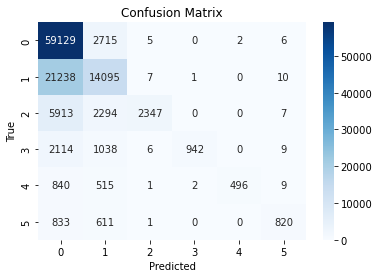

In [90]:
analysis(y_trn,y_train_predct1)

In [91]:
print("Train acrcy",f1_score(y_train_predct1,y_trn,average='micro').round(4))
print("Test acrcy",f1_score(y_test_predct1,y_tst,average='micro').round(4))

Train acrcy 0.6709
Test acrcy 0.6393


Classification report               precision    recall  f1-score   support

         0.0       0.64      0.93      0.76     20619
         1.0       0.58      0.35      0.43     11784
         2.0       0.98      0.21      0.35      3521
         3.0       0.98      0.23      0.37      1369
         4.0       0.97      0.22      0.36       621
         5.0       0.87      0.28      0.42       755

    accuracy                           0.64     38669
   macro avg       0.83      0.37      0.45     38669
weighted avg       0.67      0.64      0.60     38669

accuracy 0.6392717680829605
precision 0.6392717680829605
recall 0.6392717680829605


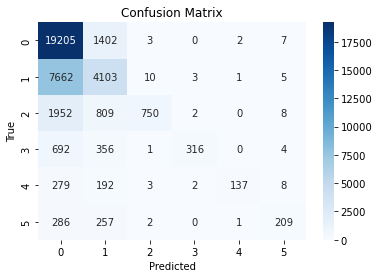

In [92]:
analysis(y_tst,y_test_predct1)

In [38]:
from flaml import AutoML

In [39]:
automl2=AutoML()
automl2.fit(x_trn,y_trn,task='classification',time_budget=7200)

[flaml.automl.logger: 07-17 10:10:30] {1693} INFO - task = classification
[flaml.automl.logger: 07-17 10:10:30] {1700} INFO - Data split method: stratified
[flaml.automl.logger: 07-17 10:10:30] {1703} INFO - Evaluation method: holdout
[flaml.automl.logger: 07-17 10:10:30] {1801} INFO - Minimizing error metric: log_loss
[flaml.automl.logger: 07-17 10:10:30] {1911} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 07-17 10:10:30] {2221} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 07-17 10:10:30] {2347} INFO - Estimated sufficient time budget=6524s. Estimated necessary time budget=150s.
[flaml.automl.logger: 07-17 10:10:30] {2394} INFO -  at 0.2s,	estimator lgbm's best error=1.0275,	best estimator lgbm's best error=1.0275
[flaml.automl.logger: 07-17 10:10:30] {2221} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 07-17 10:10:30] {2394} INFO -  at 0.2s,	estimator lgbm's best er

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:10:30] {2394} INFO -  at 0.6s,	estimator xgboost's best error=0.9357,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-17 10:10:30] {2221} INFO - iteration 12, current learner xgboost
[flaml.automl.logger: 07-17 10:10:30] {2394} INFO -  at 0.6s,	estimator xgboost's best error=0.9357,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-17 10:10:30] {2221} INFO - iteration 13, current learner xgboost
[flaml.automl.logger: 07-17 10:10:30] {2394} INFO -  at 0.7s,	estimator xgboost's best error=0.9357,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-17 10:10:30] {2221} INFO - iteration 14, current learner lgbm
[flaml.automl.logger: 07-17 10:10:31] {2394} INFO -  at 0.8s,	estimator lgbm's best error=0.9235,	best estimator lgbm's best error=0.9235


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:10:31] {2221} INFO - iteration 15, current learner xgboost
[flaml.automl.logger: 07-17 10:10:31] {2394} INFO -  at 0.9s,	estimator xgboost's best error=0.9293,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-17 10:10:31] {2221} INFO - iteration 16, current learner extra_tree
[flaml.automl.logger: 07-17 10:10:31] {2394} INFO -  at 0.9s,	estimator extra_tree's best error=1.1727,	best estimator lgbm's best error=0.9235
[flaml.automl.logger: 07-17 10:10:31] {2221} INFO - iteration 17, current learner lgbm


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:10:31] {2394} INFO -  at 1.1s,	estimator lgbm's best error=0.9008,	best estimator lgbm's best error=0.9008
[flaml.automl.logger: 07-17 10:10:31] {2221} INFO - iteration 18, current learner extra_tree
[flaml.automl.logger: 07-17 10:10:31] {2394} INFO -  at 1.2s,	estimator extra_tree's best error=1.1620,	best estimator lgbm's best error=0.9008
[flaml.automl.logger: 07-17 10:10:31] {2221} INFO - iteration 19, current learner rf
[flaml.automl.logger: 07-17 10:10:31] {2394} INFO -  at 1.3s,	estimator rf's best error=1.1623,	best estimator lgbm's best error=0.9008
[flaml.automl.logger: 07-17 10:10:31] {2221} INFO - iteration 20, current learner rf
[flaml.automl.logger: 07-17 10:10:31] {2394} INFO -  at 1.4s,	estimator rf's best error=1.1123,	best estimator lgbm's best error=0.9008
[flaml.automl.logger: 07-17 10:10:31] {2221} INFO - iteration 21, current learner rf
[flaml.automl.logger: 07-17 10:10:31] {2394} INFO -  at 1.5s,	estimator rf's best error=1.1123,	be

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:10:33] {2394} INFO -  at 3.4s,	estimator lgbm's best error=0.8824,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-17 10:10:33] {2221} INFO - iteration 27, current learner rf
[flaml.automl.logger: 07-17 10:10:33] {2394} INFO -  at 3.5s,	estimator rf's best error=1.1123,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-17 10:10:33] {2221} INFO - iteration 28, current learner xgboost
[flaml.automl.logger: 07-17 10:10:33] {2394} INFO -  at 3.6s,	estimator xgboost's best error=0.9244,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-17 10:10:33] {2221} INFO - iteration 29, current learner xgboost
[flaml.automl.logger: 07-17 10:10:33] {2394} INFO -  at 3.7s,	estimator xgboost's best error=0.9219,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-17 10:10:33] {2221} INFO - iteration 30, current learner lgbm


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:10:34] {2394} INFO -  at 4.2s,	estimator lgbm's best error=0.8824,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-17 10:10:34] {2221} INFO - iteration 31, current learner lgbm
[flaml.automl.logger: 07-17 10:10:35] {2394} INFO -  at 4.8s,	estimator lgbm's best error=0.8824,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-17 10:10:35] {2221} INFO - iteration 32, current learner lgbm
[flaml.automl.logger: 07-17 10:10:35] {2394} INFO -  at 5.7s,	estimator lgbm's best error=0.8824,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-17 10:10:35] {2221} INFO - iteration 33, current learner xgboost
[flaml.automl.logger: 07-17 10:10:36] {2394} INFO -  at 5.8s,	estimator xgboost's best error=0.9219,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-17 10:10:36] {2221} INFO - iteration 34, current learner lgbm


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:10:37] {2394} INFO -  at 7.3s,	estimator lgbm's best error=0.8824,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-17 10:10:37] {2221} INFO - iteration 35, current learner rf
[flaml.automl.logger: 07-17 10:10:37] {2394} INFO -  at 7.4s,	estimator rf's best error=1.0410,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-17 10:10:37] {2221} INFO - iteration 36, current learner extra_tree
[flaml.automl.logger: 07-17 10:10:37] {2394} INFO -  at 7.5s,	estimator extra_tree's best error=1.1596,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-17 10:10:37] {2221} INFO - iteration 37, current learner rf
[flaml.automl.logger: 07-17 10:10:37] {2394} INFO -  at 7.7s,	estimator rf's best error=1.0410,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-17 10:10:37] {2221} INFO - iteration 38, current learner rf
[flaml.automl.logger: 07-17 10:10:38] {2394} INFO -  at 7.8s,	estimator rf's best error=1.0349,	be

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:10:38] {2394} INFO -  at 8.0s,	estimator xgb_limitdepth's best error=0.9445,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-17 10:10:38] {2221} INFO - iteration 40, current learner xgb_limitdepth
[flaml.automl.logger: 07-17 10:10:38] {2394} INFO -  at 8.2s,	estimator xgb_limitdepth's best error=0.9445,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-17 10:10:38] {2221} INFO - iteration 41, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:10:38] {2394} INFO -  at 8.4s,	estimator xgb_limitdepth's best error=0.9445,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-17 10:10:38] {2221} INFO - iteration 42, current learner xgb_limitdepth
[flaml.automl.logger: 07-17 10:10:38] {2394} INFO -  at 8.6s,	estimator xgb_limitdepth's best error=0.9425,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-17 10:10:38] {2221} INFO - iteration 43, current learner lgbm


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:10:39] {2394} INFO -  at 9.1s,	estimator lgbm's best error=0.8824,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-17 10:10:39] {2221} INFO - iteration 44, current learner xgboost
[flaml.automl.logger: 07-17 10:10:39] {2394} INFO -  at 9.2s,	estimator xgboost's best error=0.9219,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-17 10:10:39] {2221} INFO - iteration 45, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:10:39] {2394} INFO -  at 9.4s,	estimator xgb_limitdepth's best error=0.9425,	best estimator lgbm's best error=0.8824
[flaml.automl.logger: 07-17 10:10:39] {2221} INFO - iteration 46, current learner xgboost
[flaml.automl.logger: 07-17 10:10:39] {2394} INFO -  at 9.6s,	estimator xgboost's best error=0.9219,	best estimator lgbm's best error=0.8824


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:10:39] {2221} INFO - iteration 47, current learner lgbm
[flaml.automl.logger: 07-17 10:10:40] {2394} INFO -  at 10.7s,	estimator lgbm's best error=0.8816,	best estimator lgbm's best error=0.8816
[flaml.automl.logger: 07-17 10:10:40] {2221} INFO - iteration 48, current learner xgboost
[flaml.automl.logger: 07-17 10:10:41] {2394} INFO -  at 10.8s,	estimator xgboost's best error=0.9219,	best estimator lgbm's best error=0.8816
[flaml.automl.logger: 07-17 10:10:41] {2221} INFO - iteration 49, current learner lgbm


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:10:41] {2394} INFO -  at 11.4s,	estimator lgbm's best error=0.8816,	best estimator lgbm's best error=0.8816
[flaml.automl.logger: 07-17 10:10:41] {2221} INFO - iteration 50, current learner lgbm
[flaml.automl.logger: 07-17 10:10:42] {2394} INFO -  at 11.8s,	estimator lgbm's best error=0.8816,	best estimator lgbm's best error=0.8816
[flaml.automl.logger: 07-17 10:10:42] {2221} INFO - iteration 51, current learner extra_tree
[flaml.automl.logger: 07-17 10:10:42] {2394} INFO -  at 11.9s,	estimator extra_tree's best error=1.1518,	best estimator lgbm's best error=0.8816
[flaml.automl.logger: 07-17 10:10:42] {2221} INFO - iteration 52, current learner lgbm
[flaml.automl.logger: 07-17 10:10:45] {2394} INFO -  at 15.5s,	estimator lgbm's best error=0.8806,	best estimator lgbm's best error=0.8806
[flaml.automl.logger: 07-17 10:10:45] {2221} INFO - iteration 53, current learner lgbm
[flaml.automl.logger: 07-17 10:10:50] {2394} INFO -  at 20.0s,	estimator lgbm's best

C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-17 10:11:14] {2394} INFO -  at 44.7s,	estimator lrl1's best error=1.1520,	best estimator lgbm's best error=0.8792
[flaml.automl.logger: 07-17 10:11:14] {2221} INFO - iteration 61, current learner rf
[flaml.automl.logger: 07-17 10:11:15] {2394} INFO -  at 44.9s,	estimator rf's best error=1.0092,	best estimator lgbm's best error=0.8792


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-17 10:11:15] {2221} INFO - iteration 62, current learner lrl1
[flaml.automl.logger: 07-17 10:11:16] {2394} INFO -  at 46.1s,	estimator lrl1's best error=1.1520,	best estimator lgbm's best error=0.8792
[flaml.automl.logger: 07-17 10:11:16] {2221} INFO - iteration 63, current learner rf
[flaml.automl.logger: 07-17 10:11:16] {2394} INFO -  at 46.2s,	estimator rf's best error=1.0092,	best estimator lgbm's best error=0.8792
[flaml.automl.logger: 07-17 10:11:16] {2221} INFO - iteration 64, current learner lrl1


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-17 10:11:29] {2394} INFO -  at 59.2s,	estimator lrl1's best error=1.1363,	best estimator lgbm's best error=0.8792
[flaml.automl.logger: 07-17 10:11:29] {2221} INFO - iteration 65, current learner rf
[flaml.automl.logger: 07-17 10:11:29] {2394} INFO -  at 59.4s,	estimator rf's best error=1.0092,	best estimator lgbm's best error=0.8792
[flaml.automl.logger: 07-17 10:11:29] {2221} INFO - iteration 66, current learner lgbm


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-17 10:11:30] {2394} INFO -  at 60.6s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:11:30] {2221} INFO - iteration 67, current learner rf
[flaml.automl.logger: 07-17 10:11:31] {2394} INFO -  at 60.9s,	estimator rf's best error=1.0092,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:11:31] {2221} INFO - iteration 68, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:11:31] {2394} INFO -  at 61.4s,	estimator xgboost's best error=0.8935,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:11:31] {2221} INFO - iteration 69, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:11:31] {2394} INFO -  at 61.6s,	estimator xgboost's best error=0.8935,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:11:31] {2221} INFO - iteration 70, current learner rf
[flaml.automl.logger: 07-17 10:11:32] {2394} INFO -  at 61.8s,	estimator rf's best error=1.0092,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:11:32] {2221} INFO - iteration 71, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:11:32] {2394} INFO -  at 62.5s,	estimator xgboost's best error=0.8935,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:11:32] {2221} INFO - iteration 72, current learner xgboost
[flaml.automl.logger: 07-17 10:11:32] {2394} INFO -  at 62.7s,	estimator xgboost's best error=0.8935,	best estimator lgbm's best error=0.8777


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:11:32] {2221} INFO - iteration 73, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:11:34] {2394} INFO -  at 63.8s,	estimator xgboost's best error=0.8935,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:11:34] {2221} INFO - iteration 74, current learner extra_tree
[flaml.automl.logger: 07-17 10:11:34] {2394} INFO -  at 63.8s,	estimator extra_tree's best error=1.1413,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:11:34] {2221} INFO - iteration 75, current learner xgboost
[flaml.automl.logger: 07-17 10:11:34] {2394} INFO -  at 64.0s,	estimator xgboost's best error=0.8935,	best estimator lgbm's best error=0.8777


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:11:34] {2221} INFO - iteration 76, current learner extra_tree
[flaml.automl.logger: 07-17 10:11:34] {2394} INFO -  at 64.2s,	estimator extra_tree's best error=1.1413,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:11:34] {2221} INFO - iteration 77, current learner rf
[flaml.automl.logger: 07-17 10:11:35] {2394} INFO -  at 65.1s,	estimator rf's best error=0.9930,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:11:35] {2221} INFO - iteration 78, current learner rf
[flaml.automl.logger: 07-17 10:11:35] {2394} INFO -  at 65.7s,	estimator rf's best error=0.9920,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:11:35] {2221} INFO - iteration 79, current learner extra_tree
[flaml.automl.logger: 07-17 10:11:36] {2394} INFO -  at 65.8s,	estimator extra_tree's best error=1.1396,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:11:36] {2221} INFO - iteration 80, current learne

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:11:38] {2394} INFO -  at 67.9s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:11:38] {2221} INFO - iteration 81, current learner rf
[flaml.automl.logger: 07-17 10:11:39] {2394} INFO -  at 68.8s,	estimator rf's best error=0.9920,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:11:39] {2221} INFO - iteration 82, current learner xgb_limitdepth
[flaml.automl.logger: 07-17 10:11:39] {2394} INFO -  at 68.9s,	estimator xgb_limitdepth's best error=0.9425,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:11:39] {2221} INFO - iteration 83, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:11:40] {2394} INFO -  at 70.0s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:11:40] {2221} INFO - iteration 84, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:11:44] {2394} INFO -  at 74.1s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:11:44] {2221} INFO - iteration 85, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:11:45] {2394} INFO -  at 75.7s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:11:45] {2221} INFO - iteration 86, current learner extra_tree
[flaml.automl.logger: 07-17 10:11:46] {2394} INFO -  at 75.8s,	estimator extra_tree's best error=1.1396,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:11:46] {2221} INFO - iteration 87, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:11:49] {2394} INFO -  at 79.6s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:11:49] {2221} INFO - iteration 88, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:11:50] {2394} INFO -  at 80.1s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:11:50] {2221} INFO - iteration 89, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:12:03] {2394} INFO -  at 93.0s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:12:03] {2221} INFO - iteration 90, current learner lgbm
[flaml.automl.logger: 07-17 10:12:07] {2394} INFO -  at 97.1s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:12:07] {2221} INFO - iteration 91, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:12:07] {2394} INFO -  at 97.6s,	estimator xgb_limitdepth's best error=0.9425,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:12:07] {2221} INFO - iteration 92, current learner rf
[flaml.automl.logger: 07-17 10:12:08] {2394} INFO -  at 98.7s,	estimator rf's best error=0.9507,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:12:08] {2221} INFO - iteration 93, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:12:10] {2394} INFO -  at 100.0s,	estimator xgb_limitdepth's best error=0.8910,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:12:10] {2221} INFO - iteration 94, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:12:11] {2394} INFO -  at 101.4s,	estimator xgb_limitdepth's best error=0.8910,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:12:11] {2221} INFO - iteration 95, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:12:12] {2394} INFO -  at 102.4s,	estimator xgb_limitdepth's best error=0.8910,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:12:12] {2221} INFO - iteration 96, current learner rf
[flaml.automl.logger: 07-17 10:12:13] {2394} INFO -  at 103.4s,	estimator rf's best error=0.9507,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:12:13] {2221} INFO - iteration 97, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:12:15] {2394} INFO -  at 105.0s,	estimator xgb_limitdepth's best error=0.8889,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:12:15] {2221} INFO - iteration 98, current learner rf
[flaml.automl.logger: 07-17 10:12:16] {2394} INFO -  at 106.0s,	estimator rf's best error=0.9507,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:12:16] {2221} INFO - iteration 99, current learner rf
[flaml.automl.logger: 07-17 10:12:18] {2394} INFO -  at 108.4s,	estimator rf's best error=0.9228,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:12:18] {2221} INFO - iteration 100, current learner rf
[flaml.automl.logger: 07-17 10:12:23] {2394} INFO -  at 112.8s,	estimator rf's best error=0.9070,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:12:23] {2221} INFO - iteration 101, current learner lgbm
[flaml.automl.logger: 07-17 10:12:23] {2394} INFO -  at 113.6s,	estimator lgbm's best error=

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:12:25] {2394} INFO -  at 114.9s,	estimator xgb_limitdepth's best error=0.8889,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:12:25] {2221} INFO - iteration 103, current learner rf
[flaml.automl.logger: 07-17 10:12:27] {2394} INFO -  at 117.2s,	estimator rf's best error=0.9070,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:12:27] {2221} INFO - iteration 104, current learner lgbm
[flaml.automl.logger: 07-17 10:12:28] {2394} INFO -  at 117.9s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:12:28] {2221} INFO - iteration 105, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:12:29] {2394} INFO -  at 119.2s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:12:29] {2221} INFO - iteration 106, current learner rf
[flaml.automl.logger: 07-17 10:12:34] {2394} INFO -  at 124.0s,	estimator rf's best error=0.8930,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:12:34] {2221} INFO - iteration 107, current learner rf
[flaml.automl.logger: 07-17 10:12:38] {2394} INFO -  at 128.1s,	estimator rf's best error=0.8930,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:12:38] {2221} INFO - iteration 108, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:12:39] {2394} INFO -  at 129.0s,	estimator xgb_limitdepth's best error=0.8889,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:12:39] {2221} INFO - iteration 109, current learner rf
[flaml.automl.logger: 07-17 10:12:44] {2394} INFO -  at 134.4s,	estimator rf's best error=0.8930,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:12:44] {2221} INFO - iteration 110, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:12:47] {2394} INFO -  at 137.4s,	estimator xgb_limitdepth's best error=0.8855,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:12:47] {2221} INFO - iteration 111, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:12:51] {2394} INFO -  at 140.8s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:12:51] {2221} INFO - iteration 112, current learner lgbm
[flaml.automl.logger: 07-17 10:12:56] {2394} INFO -  at 146.4s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:12:56] {2221} INFO - iteration 113, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:12:58] {2394} INFO -  at 147.9s,	estimator xgb_limitdepth's best error=0.8855,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:12:58] {2221} INFO - iteration 114, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:12:58] {2394} INFO -  at 148.6s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:12:58] {2221} INFO - iteration 115, current learner lrl1
[flaml.automl.logger: 07-17 10:13:10] {2394} INFO -  at 160.5s,	estimator lrl1's best error=1.1363,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:13:10] {2221} INFO - iteration 116, current learner lgbm


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-17 10:13:11] {2394} INFO -  at 161.4s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:13:11] {2221} INFO - iteration 117, current learner lgbm
[flaml.automl.logger: 07-17 10:13:14] {2394} INFO -  at 164.4s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:13:14] {2221} INFO - iteration 118, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:13:22] {2394} INFO -  at 172.0s,	estimator xgb_limitdepth's best error=0.8855,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:13:22] {2221} INFO - iteration 119, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:13:33] {2394} INFO -  at 183.3s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:13:33] {2221} INFO - iteration 120, current learner lgbm
[flaml.automl.logger: 07-17 10:13:35] {2394} INFO -  at 185.0s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:13:35] {2221} INFO - iteration 121, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:13:38] {2394} INFO -  at 188.4s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:13:38] {2221} INFO - iteration 122, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:13:40] {2394} INFO -  at 189.8s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:13:40] {2221} INFO - iteration 123, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:13:41] {2394} INFO -  at 191.6s,	estimator xgb_limitdepth's best error=0.8855,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:13:41] {2221} INFO - iteration 124, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:13:45] {2394} INFO -  at 194.9s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:13:45] {2221} INFO - iteration 125, current learner lgbm
[flaml.automl.logger: 07-17 10:13:47] {2394} INFO -  at 196.8s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:13:47] {2221} INFO - iteration 126, current learner lgbm
[flaml.automl.logger: 07-17 10:13:54] {2394} INFO -  at 204.2s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:13:54] {2221} INFO - iteration 127, current learner lgbm
[flaml.automl.logger: 07-17 10:13:54] {2394} INFO -  at 204.7s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:13:54] {2221} INFO - iteration 128, current learner lgbm
[flaml.automl.logger: 07-17 10:13:58] {2394} INFO -  at 208.3s,	estimator lgbm's best

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:14:05] {2394} INFO -  at 215.4s,	estimator xgb_limitdepth's best error=0.8855,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:14:05] {2221} INFO - iteration 138, current learner extra_tree
[flaml.automl.logger: 07-17 10:14:05] {2394} INFO -  at 215.5s,	estimator extra_tree's best error=1.0771,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:14:05] {2221} INFO - iteration 139, current learner lgbm
[flaml.automl.logger: 07-17 10:14:16] {2394} INFO -  at 226.2s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:14:16] {2221} INFO - iteration 140, current learner extra_tree
[flaml.automl.logger: 07-17 10:14:17] {2394} INFO -  at 226.8s,	estimator extra_tree's best error=1.0771,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:14:17] {2221} INFO - iteration 141, current learner rf
[flaml.automl.logger: 07-17 10:14:21] {2394} INFO -  at 

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:14:23] {2394} INFO -  at 233.4s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:14:23] {2221} INFO - iteration 144, current learner extra_tree
[flaml.automl.logger: 07-17 10:14:23] {2394} INFO -  at 233.7s,	estimator extra_tree's best error=1.0771,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:14:23] {2221} INFO - iteration 145, current learner extra_tree
[flaml.automl.logger: 07-17 10:14:24] {2394} INFO -  at 234.3s,	estimator extra_tree's best error=1.0771,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:14:24] {2221} INFO - iteration 146, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:14:37] {2394} INFO -  at 247.5s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:14:37] {2221} INFO - iteration 147, current learner lgbm
[flaml.automl.logger: 07-17 10:14:38] {2394} INFO -  at 248.0s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:14:38] {2221} INFO - iteration 148, current learner lgbm
[flaml.automl.logger: 07-17 10:14:38] {2394} INFO -  at 248.3s,	estimator lgbm's best error=0.8777,	best estimator lgbm's best error=0.8777
[flaml.automl.logger: 07-17 10:14:38] {2221} INFO - iteration 149, current learner lgbm
[flaml.automl.logger: 07-17 10:14:48] {2394} INFO -  at 258.6s,	estimator lgbm's best error=0.8775,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:14:48] {2221} INFO - iteration 150, current learner lgbm
[flaml.automl.logger: 07-17 10:15:19] {2394} INFO -  at 289.3s,	estimator lgbm's best

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:15:28] {2394} INFO -  at 297.9s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:15:28] {2221} INFO - iteration 155, current learner lgbm
[flaml.automl.logger: 07-17 10:15:30] {2394} INFO -  at 299.9s,	estimator lgbm's best error=0.8775,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:15:30] {2221} INFO - iteration 156, current learner lgbm
[flaml.automl.logger: 07-17 10:16:41] {2394} INFO -  at 371.0s,	estimator lgbm's best error=0.8775,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:16:41] {2221} INFO - iteration 157, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:16:42] {2394} INFO -  at 372.4s,	estimator xgb_limitdepth's best error=0.8855,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:16:42] {2221} INFO - iteration 158, current learner extra_tree
[flaml.automl.logger: 07-17 10:16:43] {2394} INFO -  at 373.1s,	estimator extra_tree's best error=1.0771,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:16:43] {2221} INFO - iteration 159, current learner rf
[flaml.automl.logger: 07-17 10:16:49] {2394} INFO -  at 378.8s,	estimator rf's best error=0.8893,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:16:49] {2221} INFO - iteration 160, current learner rf
[flaml.automl.logger: 07-17 10:16:53] {2394} INFO -  at 383.5s,	estimator rf's best error=0.8862,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:16:53] {2221} INFO - iteration 161, current learner extra_tree
[flaml.automl.logger: 07-17 10:16:54] {2394} INFO -  at 384.2s,	esti

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:17:04] {2394} INFO -  at 393.7s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:17:04] {2221} INFO - iteration 164, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:17:12] {2394} INFO -  at 402.2s,	estimator xgb_limitdepth's best error=0.8839,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:17:12] {2221} INFO - iteration 165, current learner extra_tree
[flaml.automl.logger: 07-17 10:17:13] {2394} INFO -  at 403.1s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:17:13] {2221} INFO - iteration 166, current learner extra_tree
[flaml.automl.logger: 07-17 10:17:13] {2394} INFO -  at 403.7s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:17:13] {2221} INFO - iteration 167, current learner extra_tree
[flaml.automl.logger: 07-17 10:17:14] {2394} INFO -  at 404.2s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:17:14] {2221} INFO - iteration 168, current learner extra_tree
[flaml.automl.logger: 07-17 10:17:15

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:18:37] {2394} INFO -  at 487.7s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:18:37] {2221} INFO - iteration 177, current learner lrl1
[flaml.automl.logger: 07-17 10:18:52] {2394} INFO -  at 501.9s,	estimator lrl1's best error=1.1363,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:18:52] {2221} INFO - iteration 178, current learner extra_tree


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-17 10:18:52] {2394} INFO -  at 502.3s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:18:52] {2221} INFO - iteration 179, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:18:54] {2394} INFO -  at 504.7s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:18:54] {2221} INFO - iteration 180, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:18:56] {2394} INFO -  at 505.8s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:18:56] {2221} INFO - iteration 181, current learner extra_tree
[flaml.automl.logger: 07-17 10:18:57] {2394} INFO -  at 506.8s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:18:57] {2221} INFO - iteration 182, current learner extra_tree
[flaml.automl.logger: 07-17 10:18:58] {2394} INFO -  at 508.0s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:18:58] {2221} INFO - iteration 183, current learner rf
[flaml.automl.logger: 07-17 10:19:03] {2394} INFO -  at 512.8s,	estimator rf's best error=0.8862,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:19:03] {2221} INFO - iteration 184, current learner lgbm
[flaml.automl.logger: 07-17 10:19:04] {2394} INFO -  at 514.1s,	e

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:19:05] {2394} INFO -  at 514.9s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:19:05] {2221} INFO - iteration 186, current learner extra_tree
[flaml.automl.logger: 07-17 10:19:05] {2394} INFO -  at 515.4s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:19:05] {2221} INFO - iteration 187, current learner rf
[flaml.automl.logger: 07-17 10:19:11] {2394} INFO -  at 521.0s,	estimator rf's best error=0.8862,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:19:11] {2221} INFO - iteration 188, current learner extra_tree
[flaml.automl.logger: 07-17 10:19:11] {2394} INFO -  at 521.5s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:19:11] {2221} INFO - iteration 189, current learner lgbm
[flaml.automl.logger: 07-17 10:21:18] {2394} INFO -  at 648.3s,	e

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:21:27] {2394} INFO -  at 657.6s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:21:27] {2221} INFO - iteration 191, current learner extra_tree
[flaml.automl.logger: 07-17 10:21:29] {2394} INFO -  at 658.8s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:21:29] {2221} INFO - iteration 192, current learner rf
[flaml.automl.logger: 07-17 10:21:33] {2394} INFO -  at 663.3s,	estimator rf's best error=0.8862,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:21:33] {2221} INFO - iteration 193, current learner extra_tree
[flaml.automl.logger: 07-17 10:21:35] {2394} INFO -  at 665.1s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:21:35] {2221} INFO - iteration 194, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:21:38] {2394} INFO -  at 668.5s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:21:38] {2221} INFO - iteration 195, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:21:42] {2394} INFO -  at 672.1s,	estimator xgb_limitdepth's best error=0.8839,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:21:42] {2221} INFO - iteration 196, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:21:44] {2394} INFO -  at 674.1s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:21:44] {2221} INFO - iteration 197, current learner lgbm
[flaml.automl.logger: 07-17 10:22:54] {2394} INFO -  at 744.6s,	estimator lgbm's best error=0.8775,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:22:54] {2221} INFO - iteration 198, current learner extra_tree
[flaml.automl.logger: 07-17 10:22:55] {2394} INFO -  at 744.9s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:22:55] {2221} INFO - iteration 199, current learner extra_tree
[flaml.automl.logger: 07-17 10:22:55] {2394} INFO -  at 745.3s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:22:55] {2221} INFO - iteration 200, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:23:19] {2394} INFO -  at 769.3s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:23:19] {2221} INFO - iteration 201, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:23:39] {2394} INFO -  at 789.0s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8775
[flaml.automl.logger: 07-17 10:23:39] {2221} INFO - iteration 202, current learner lgbm
[flaml.automl.logger: 07-17 10:23:41] {2394} INFO -  at 791.1s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:23:41] {2221} INFO - iteration 203, current learner rf
[flaml.automl.logger: 07-17 10:23:44] {2394} INFO -  at 794.5s,	estimator rf's best error=0.8862,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:23:44] {2221} INFO - iteration 204, current learner extra_tree
[flaml.automl.logger: 07-17 10:23:45] {2394} INFO -  at 795.4s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:23:45] {2221} INFO - iteration 205, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:24:09] {2394} INFO -  at 819.5s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:24:09] {2221} INFO - iteration 206, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:24:19] {2394} INFO -  at 829.2s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:24:19] {2221} INFO - iteration 207, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:24:24] {2394} INFO -  at 834.7s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:24:24] {2221} INFO - iteration 208, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:25:16] {2394} INFO -  at 886.3s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:25:16] {2221} INFO - iteration 209, current learner extra_tree
[flaml.automl.logger: 07-17 10:25:18] {2394} INFO -  at 888.1s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:25:18] {2221} INFO - iteration 210, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:25:19] {2394} INFO -  at 889.1s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:25:19] {2221} INFO - iteration 211, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:25:21] {2394} INFO -  at 891.2s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:25:21] {2221} INFO - iteration 212, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:25:24] {2394} INFO -  at 894.0s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:25:24] {2221} INFO - iteration 213, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:25:27] {2394} INFO -  at 897.3s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:25:27] {2221} INFO - iteration 214, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:25:33] {2394} INFO -  at 903.0s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:25:33] {2221} INFO - iteration 215, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:27:03] {2394} INFO -  at 993.0s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:27:03] {2221} INFO - iteration 216, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:27:05] {2394} INFO -  at 994.8s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:27:05] {2221} INFO - iteration 217, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:27:22] {2394} INFO -  at 1012.1s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:27:22] {2221} INFO - iteration 218, current learner rf
[flaml.automl.logger: 07-17 10:27:28] {2394} INFO -  at 1018.5s,	estimator rf's best error=0.8862,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:27:28] {2221} INFO - iteration 219, current learner rf
[flaml.automl.logger: 07-17 10:27:39] {2394} INFO -  at 1029.1s,	estimator rf's best error=0.8862,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:27:39] {2221} INFO - iteration 220, current learner rf
[flaml.automl.logger: 07-17 10:27:41] {2394} INFO -  at 1031.3s,	estimator rf's best error=0.8862,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:27:41] {2221} INFO - iteration 221, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:27:46] {2394} INFO -  at 1036.6s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:27:46] {2221} INFO - iteration 222, current learner lgbm
[flaml.automl.logger: 07-17 10:27:58] {2394} INFO -  at 1048.5s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:27:58] {2221} INFO - iteration 223, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:28:30] {2394} INFO -  at 1080.2s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:28:30] {2221} INFO - iteration 224, current learner extra_tree
[flaml.automl.logger: 07-17 10:28:30] {2394} INFO -  at 1080.5s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:28:30] {2221} INFO - iteration 225, current learner lgbm
[flaml.automl.logger: 07-17 10:28:31] {2394} INFO -  at 1080.9s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:28:31] {2221} INFO - iteration 226, current learner rf
[flaml.automl.logger: 07-17 10:28:34] {2394} INFO -  at 1084.5s,	estimator rf's best error=0.8862,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:28:34] {2221} INFO - iteration 227, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:28:35] {2394} INFO -  at 1085.5s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:28:35] {2221} INFO - iteration 228, current learner rf
[flaml.automl.logger: 07-17 10:28:43] {2394} INFO -  at 1093.1s,	estimator rf's best error=0.8862,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:28:43] {2221} INFO - iteration 229, current learner extra_tree
[flaml.automl.logger: 07-17 10:28:43] {2394} INFO -  at 1093.7s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:28:43] {2221} INFO - iteration 230, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:28:47] {2394} INFO -  at 1096.9s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:28:47] {2221} INFO - iteration 231, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:28:51] {2394} INFO -  at 1101.3s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:28:51] {2221} INFO - iteration 232, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:28:53] {2394} INFO -  at 1103.3s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:28:53] {2221} INFO - iteration 233, current learner extra_tree
[flaml.automl.logger: 07-17 10:28:54] {2394} INFO -  at 1104.2s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:28:54] {2221} INFO - iteration 234, current learner extra_tree
[flaml.automl.logger: 07-17 10:28:55] {2394} INFO -  at 1105.1s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:28:55] {2221} INFO - iteration 235, current learner extra_tree
[flaml.automl.logger: 07-17 10:28:55] {2394} INFO -  at 1105.6s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:28:55] {2221} INFO - iteration 236, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:28:57] {2394} INFO -  at 1107.7s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:28:57] {2221} INFO - iteration 237, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:28:59] {2394} INFO -  at 1109.6s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:28:59] {2221} INFO - iteration 238, current learner extra_tree
[flaml.automl.logger: 07-17 10:29:00] {2394} INFO -  at 1110.2s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:29:00] {2221} INFO - iteration 239, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:29:08] {2394} INFO -  at 1118.7s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:29:08] {2221} INFO - iteration 240, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:29:09] {2394} INFO -  at 1119.5s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:29:09] {2221} INFO - iteration 241, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:29:10] {2394} INFO -  at 1120.7s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:29:10] {2221} INFO - iteration 242, current learner lgbm
[flaml.automl.logger: 07-17 10:29:13] {2394} INFO -  at 1123.7s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:29:13] {2221} INFO - iteration 243, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:29:18] {2394} INFO -  at 1128.4s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:29:18] {2221} INFO - iteration 244, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:29:23] {2394} INFO -  at 1133.1s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:29:23] {2221} INFO - iteration 245, current learner extra_tree
[flaml.automl.logger: 07-17 10:29:24] {2394} INFO -  at 1134.1s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:29:24] {2221} INFO - iteration 246, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:29:25] {2394} INFO -  at 1135.4s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:29:25] {2221} INFO - iteration 247, current learner extra_tree
[flaml.automl.logger: 07-17 10:29:26] {2394} INFO -  at 1136.0s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:29:26] {2221} INFO - iteration 248, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:29:29] {2394} INFO -  at 1138.9s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:29:29] {2221} INFO - iteration 249, current learner rf
[flaml.automl.logger: 07-17 10:29:40] {2394} INFO -  at 1150.1s,	estimator rf's best error=0.8862,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:29:40] {2221} INFO - iteration 250, current learner extra_tree
[flaml.automl.logger: 07-17 10:29:40] {2394} INFO -  at 1150.7s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:29:40] {2221} INFO - iteration 251, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:29:42] {2394} INFO -  at 1152.5s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:29:42] {2221} INFO - iteration 252, current learner lgbm
[flaml.automl.logger: 07-17 10:29:45] {2394} INFO -  at 1154.9s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:29:45] {2221} INFO - iteration 253, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:29:45] {2394} INFO -  at 1155.3s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:29:45] {2221} INFO - iteration 254, current learner extra_tree
[flaml.automl.logger: 07-17 10:29:46] {2394} INFO -  at 1156.1s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:29:46] {2221} INFO - iteration 255, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:31:51] {2394} INFO -  at 1281.3s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:31:51] {2221} INFO - iteration 256, current learner lgbm
[flaml.automl.logger: 07-17 10:31:54] {2394} INFO -  at 1283.7s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:31:54] {2221} INFO - iteration 257, current learner lrl1
[flaml.automl.logger: 07-17 10:32:08] {2394} INFO -  at 1297.9s,	estimator lrl1's best error=1.1363,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:32:08] {2221} INFO - iteration 258, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:32:23] {2394} INFO -  at 1313.4s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:32:23] {2221} INFO - iteration 259, current learner lrl1
[flaml.automl.logger: 07-17 10:32:35] {2394} INFO -  at 1324.9s,	estimator lrl1's best error=1.1363,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:32:35] {2221} INFO - iteration 260, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:32:38] {2394} INFO -  at 1328.5s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:32:38] {2221} INFO - iteration 261, current learner extra_tree
[flaml.automl.logger: 07-17 10:32:39] {2394} INFO -  at 1329.2s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:32:39] {2221} INFO - iteration 262, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:32:40] {2394} INFO -  at 1330.4s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:32:40] {2221} INFO - iteration 263, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:32:47] {2394} INFO -  at 1337.5s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:32:47] {2221} INFO - iteration 264, current learner rf
[flaml.automl.logger: 07-17 10:32:50] {2394} INFO -  at 1339.8s,	estimator rf's best error=0.8862,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:32:50] {2221} INFO - iteration 265, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:32:50] {2394} INFO -  at 1340.6s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:32:50] {2221} INFO - iteration 266, current learner extra_tree
[flaml.automl.logger: 07-17 10:32:51] {2394} INFO -  at 1340.9s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:32:51] {2221} INFO - iteration 267, current learner extra_tree
[flaml.automl.logger: 07-17 10:32:52] {2394} INFO -  at 1342.5s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:32:52] {2221} INFO - iteration 268, current learner extra_tree
[flaml.automl.logger: 07-17 10:32:53] {2394} INFO -  at 1343.1s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:32:53] {2221} INFO - iteration 269, current learner extra_tree
[flaml.automl.logger: 07-17 10:32:54] {

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:32:58] {2394} INFO -  at 1347.8s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:32:58] {2221} INFO - iteration 272, current learner extra_tree
[flaml.automl.logger: 07-17 10:32:59] {2394} INFO -  at 1348.9s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:32:59] {2221} INFO - iteration 273, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:33:00] {2394} INFO -  at 1350.5s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:33:00] {2221} INFO - iteration 274, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:33:03] {2394} INFO -  at 1353.5s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:33:03] {2221} INFO - iteration 275, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:33:05] {2394} INFO -  at 1355.0s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:33:05] {2221} INFO - iteration 276, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:33:07] {2394} INFO -  at 1357.4s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:33:07] {2221} INFO - iteration 277, current learner rf
[flaml.automl.logger: 07-17 10:33:09] {2394} INFO -  at 1359.6s,	estimator rf's best error=0.8862,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:33:09] {2221} INFO - iteration 278, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:33:13] {2394} INFO -  at 1362.8s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:33:13] {2221} INFO - iteration 279, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:33:16] {2394} INFO -  at 1366.0s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:33:16] {2221} INFO - iteration 280, current learner lrl1
[flaml.automl.logger: 07-17 10:33:27] {2394} INFO -  at 1377.7s,	estimator lrl1's best error=1.1363,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:33:27] {2221} INFO - iteration 281, current learner extra_tree


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-17 10:33:28] {2394} INFO -  at 1378.0s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:33:28] {2221} INFO - iteration 282, current learner rf
[flaml.automl.logger: 07-17 10:33:37] {2394} INFO -  at 1387.1s,	estimator rf's best error=0.8862,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:33:37] {2221} INFO - iteration 283, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:33:38] {2394} INFO -  at 1388.4s,	estimator xgboost's best error=0.8799,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:33:38] {2221} INFO - iteration 284, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:33:42] {2394} INFO -  at 1392.1s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:33:42] {2221} INFO - iteration 285, current learner extra_tree
[flaml.automl.logger: 07-17 10:33:43] {2394} INFO -  at 1393.4s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:33:43] {2221} INFO - iteration 286, current learner extra_tree
[flaml.automl.logger: 07-17 10:33:43] {2394} INFO -  at 1393.7s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:33:43] {2221} INFO - iteration 287, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:34:00] {2394} INFO -  at 1410.6s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:34:00] {2221} INFO - iteration 288, current learner extra_tree
[flaml.automl.logger: 07-17 10:34:02] {2394} INFO -  at 1412.0s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:34:02] {2221} INFO - iteration 289, current learner rf
[flaml.automl.logger: 07-17 10:34:17] {2394} INFO -  at 1426.8s,	estimator rf's best error=0.8841,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:34:17] {2221} INFO - iteration 290, current learner lgbm
[flaml.automl.logger: 07-17 10:34:18] {2394} INFO -  at 1428.7s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:34:18] {2221} INFO - iteration 291, current learner extra_tree
[flaml.automl.logger: 07-17 10:34:19] {2394} INFO -  at 1429

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:34:21] {2394} INFO -  at 1431.5s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:34:21] {2221} INFO - iteration 293, current learner extra_tree
[flaml.automl.logger: 07-17 10:34:22] {2394} INFO -  at 1432.4s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:34:22] {2221} INFO - iteration 294, current learner extra_tree
[flaml.automl.logger: 07-17 10:34:23] {2394} INFO -  at 1432.9s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:34:23] {2221} INFO - iteration 295, current learner extra_tree
[flaml.automl.logger: 07-17 10:34:23] {2394} INFO -  at 1433.5s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:34:23] {2221} INFO - iteration 296, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:34:25] {2394} INFO -  at 1435.6s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:34:25] {2221} INFO - iteration 297, current learner extra_tree
[flaml.automl.logger: 07-17 10:34:26] {2394} INFO -  at 1436.6s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:34:26] {2221} INFO - iteration 298, current learner extra_tree
[flaml.automl.logger: 07-17 10:34:27] {2394} INFO -  at 1437.0s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:34:27] {2221} INFO - iteration 299, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:34:33] {2394} INFO -  at 1443.2s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:34:33] {2221} INFO - iteration 300, current learner rf
[flaml.automl.logger: 07-17 10:34:38] {2394} INFO -  at 1448.6s,	estimator rf's best error=0.8841,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:34:38] {2221} INFO - iteration 301, current learner lgbm
[flaml.automl.logger: 07-17 10:34:39] {2394} INFO -  at 1449.4s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:34:39] {2221} INFO - iteration 302, current learner rf
[flaml.automl.logger: 07-17 10:34:53] {2394} INFO -  at 1463.3s,	estimator rf's best error=0.8841,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:34:53] {2221} INFO - iteration 303, current learner lgbm
[flaml.automl.logger: 07-17 10:35:01] {2394} INFO -  at 1470.9s,	estimator lgbm's best er

C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-17 10:35:26] {2394} INFO -  at 1496.4s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:35:26] {2221} INFO - iteration 306, current learner extra_tree
[flaml.automl.logger: 07-17 10:35:27] {2394} INFO -  at 1496.8s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:35:27] {2221} INFO - iteration 307, current learner extra_tree
[flaml.automl.logger: 07-17 10:35:28] {2394} INFO -  at 1498.1s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:35:28] {2221} INFO - iteration 308, current learner extra_tree
[flaml.automl.logger: 07-17 10:35:29] {2394} INFO -  at 1499.3s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:35:29] {2221} INFO - iteration 309, current learner extra_tree
[flaml.automl.logger: 07-17 10:35:29] {239

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:35:35] {2394} INFO -  at 1504.9s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:35:35] {2221} INFO - iteration 312, current learner rf
[flaml.automl.logger: 07-17 10:35:48] {2394} INFO -  at 1518.1s,	estimator rf's best error=0.8841,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:35:48] {2221} INFO - iteration 313, current learner lgbm
[flaml.automl.logger: 07-17 10:35:55] {2394} INFO -  at 1524.9s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:35:55] {2221} INFO - iteration 314, current learner extra_tree
[flaml.automl.logger: 07-17 10:35:55] {2394} INFO -  at 1525.5s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:35:55] {2221} INFO - iteration 315, current learner rf
[flaml.automl.logger: 07-17 10:36:09] {2394} INFO -  at 1539.3s,	estimator 

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:36:37] {2394} INFO -  at 1567.6s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:36:37] {2221} INFO - iteration 317, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:37:12] {2394} INFO -  at 1601.8s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:37:12] {2221} INFO - iteration 318, current learner lgbm
[flaml.automl.logger: 07-17 10:37:13] {2394} INFO -  at 1603.2s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:37:13] {2221} INFO - iteration 319, current learner lgbm
[flaml.automl.logger: 07-17 10:37:15] {2394} INFO -  at 1605.0s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:37:15] {2221} INFO - iteration 320, current learner lgbm
[flaml.automl.logger: 07-17 10:37:19] {2394} INFO -  at 1608.8s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:37:19] {2221} INFO - iteration 321, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:37:21] {2394} INFO -  at 1611.5s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:37:21] {2221} INFO - iteration 322, current learner extra_tree
[flaml.automl.logger: 07-17 10:37:22] {2394} INFO -  at 1612.6s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:37:22] {2221} INFO - iteration 323, current learner lgbm
[flaml.automl.logger: 07-17 10:37:24] {2394} INFO -  at 1614.0s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:37:24] {2221} INFO - iteration 324, current learner lgbm
[flaml.automl.logger: 07-17 10:37:28] {2394} INFO -  at 1618.4s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:37:28] {2221} INFO - iteration 325, current learner extra_tree
[flaml.automl.logger: 07-17 10:37:29] {2394} INFO -  at 1619.4s

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:37:53] {2394} INFO -  at 1642.8s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:37:53] {2221} INFO - iteration 331, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:38:02] {2394} INFO -  at 1652.2s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:38:02] {2221} INFO - iteration 332, current learner lgbm
[flaml.automl.logger: 07-17 10:38:05] {2394} INFO -  at 1655.5s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:38:05] {2221} INFO - iteration 333, current learner extra_tree
[flaml.automl.logger: 07-17 10:38:06] {2394} INFO -  at 1656.6s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:38:06] {2221} INFO - iteration 334, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:38:13] {2394} INFO -  at 1663.4s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:38:13] {2221} INFO - iteration 335, current learner extra_tree
[flaml.automl.logger: 07-17 10:38:14] {2394} INFO -  at 1663.9s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:38:14] {2221} INFO - iteration 336, current learner lgbm
[flaml.automl.logger: 07-17 10:38:15] {2394} INFO -  at 1665.1s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:38:15] {2221} INFO - iteration 337, current learner extra_tree
[flaml.automl.logger: 07-17 10:38:15] {2394} INFO -  at 1665.5s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:38:15] {2221} INFO - iteration 338, current learner lgbm
[flaml.automl.logger: 07-17 10:38:16] {2394} INFO -  at 1

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:38:17] {2394} INFO -  at 1667.6s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:38:17] {2221} INFO - iteration 340, current learner extra_tree
[flaml.automl.logger: 07-17 10:38:18] {2394} INFO -  at 1668.7s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:38:18] {2221} INFO - iteration 341, current learner lgbm
[flaml.automl.logger: 07-17 10:38:31] {2394} INFO -  at 1681.4s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:38:31] {2221} INFO - iteration 342, current learner lgbm
[flaml.automl.logger: 07-17 10:38:37] {2394} INFO -  at 1687.2s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:38:37] {2221} INFO - iteration 343, current learner extra_tree
[flaml.automl.logger: 07-17 10:38:37] {2394} INFO -  at 1687.6s

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:38:44] {2394} INFO -  at 1694.0s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:38:44] {2221} INFO - iteration 346, current learner extra_tree
[flaml.automl.logger: 07-17 10:38:45] {2394} INFO -  at 1695.0s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:38:45] {2221} INFO - iteration 347, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:39:00] {2394} INFO -  at 1710.0s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:39:00] {2221} INFO - iteration 348, current learner extra_tree
[flaml.automl.logger: 07-17 10:39:00] {2394} INFO -  at 1710.4s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:39:00] {2221} INFO - iteration 349, current learner extra_tree
[flaml.automl.logger: 07-17 10:39:01] {2394} INFO -  at 1710.8s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:39:01] {2221} INFO - iteration 350, current learner lgbm
[flaml.automl.logger: 07-17 10:39:01] {2394} INFO -  at 1711.7s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:39:01] {2221} INFO - iteration 351, current learner extra_tree
[flaml.automl.logger: 07-17 10:39:03] {2394}

C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-17 10:40:01] {2394} INFO -  at 1771.4s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:40:01] {2221} INFO - iteration 367, current learner lgbm
[flaml.automl.logger: 07-17 10:40:02] {2394} INFO -  at 1771.9s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:40:02] {2221} INFO - iteration 368, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:42:31] {2394} INFO -  at 1920.8s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:42:31] {2221} INFO - iteration 369, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:42:32] {2394} INFO -  at 1922.6s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:42:32] {2221} INFO - iteration 370, current learner lrl1
[flaml.automl.logger: 07-17 10:42:46] {2394} INFO -  at 1936.6s,	estimator lrl1's best error=1.1363,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:42:46] {2221} INFO - iteration 371, current learner extra_tree


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-17 10:42:47] {2394} INFO -  at 1937.0s,	estimator extra_tree's best error=1.0394,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:42:47] {2221} INFO - iteration 372, current learner lrl1
[flaml.automl.logger: 07-17 10:42:58] {2394} INFO -  at 1948.7s,	estimator lrl1's best error=1.1363,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:42:58] {2221} INFO - iteration 373, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:43:02] {2394} INFO -  at 1951.9s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:43:02] {2221} INFO - iteration 374, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:43:04] {2394} INFO -  at 1954.6s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:43:04] {2221} INFO - iteration 375, current learner lgbm
[flaml.automl.logger: 07-17 10:43:07] {2394} INFO -  at 1957.7s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:43:07] {2221} INFO - iteration 376, current learner lgbm
[flaml.automl.logger: 07-17 10:43:10] {2394} INFO -  at 1959.7s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:43:10] {2221} INFO - iteration 377, current learner lgbm
[flaml.automl.logger: 07-17 10:43:10] {2394} INFO -  at 1960.6s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:43:10] {2221} INFO - iteration 378, current learner lgbm
[flaml.automl.logger: 07-17 10:43:17] {2394} INFO -  at 1967.4s,	estimator lgbm's

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:43:28] {2394} INFO -  at 1977.9s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:43:28] {2221} INFO - iteration 384, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:43:33] {2394} INFO -  at 1983.0s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:43:33] {2221} INFO - iteration 385, current learner lgbm
[flaml.automl.logger: 07-17 10:43:34] {2394} INFO -  at 1984.4s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:43:34] {2221} INFO - iteration 386, current learner lgbm
[flaml.automl.logger: 07-17 10:43:38] {2394} INFO -  at 1988.4s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:43:38] {2221} INFO - iteration 387, current learner rf
[flaml.automl.logger: 07-17 10:44:00] {2394} INFO -  at 2009.9s,	estimator rf's best error=0.8835,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:44:00] {2221} INFO - iteration 388, current learner lrl1
[flaml.automl.logger: 07-17 10:44:13] {2394} INFO -  at 2023.7s,	estimator lrl1's bes

C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-17 10:44:15] {2394} INFO -  at 2024.9s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:44:15] {2221} INFO - iteration 390, current learner lgbm
[flaml.automl.logger: 07-17 10:44:17] {2394} INFO -  at 2027.3s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:44:17] {2221} INFO - iteration 391, current learner lgbm
[flaml.automl.logger: 07-17 10:44:18] {2394} INFO -  at 2027.9s,	estimator lgbm's best error=0.8774,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:44:18] {2221} INFO - iteration 392, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:44:25] {2394} INFO -  at 2035.5s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8774
[flaml.automl.logger: 07-17 10:44:25] {2221} INFO - iteration 393, current learner lgbm
[flaml.automl.logger: 07-17 10:44:32] {2394} INFO -  at 2042.7s,	estimator lgbm's best error=0.8765,	best estimator lgbm's best error=0.8765
[flaml.automl.logger: 07-17 10:44:32] {2221} INFO - iteration 394, current learner lgbm
[flaml.automl.logger: 07-17 10:44:52] {2394} INFO -  at 2062.1s,	estimator lgbm's best error=0.8765,	best estimator lgbm's best error=0.8765
[flaml.automl.logger: 07-17 10:44:52] {2221} INFO - iteration 395, current learner lgbm
[flaml.automl.logger: 07-17 10:44:55] {2394} INFO -  at 2065.2s,	estimator lgbm's best error=0.8765,	best estimator lgbm's best error=0.8765
[flaml.automl.logger: 07-17 10:44:55] {2221} INFO - iteration 396, current learner lgbm
[flaml.automl.logger: 07-17 10:45:01] {2394} INFO -  at 2070.8s,	estimator lgbm's

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:47:15] {2394} INFO -  at 2205.1s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 10:47:15] {2221} INFO - iteration 407, current learner lgbm
[flaml.automl.logger: 07-17 10:47:18] {2394} INFO -  at 2208.1s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 10:47:18] {2221} INFO - iteration 408, current learner lgbm
[flaml.automl.logger: 07-17 10:47:20] {2394} INFO -  at 2210.5s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 10:47:20] {2221} INFO - iteration 409, current learner lgbm
[flaml.automl.logger: 07-17 10:47:55] {2394} INFO -  at 2245.7s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 10:47:55] {2221} INFO - iteration 410, current learner lgbm
[flaml.automl.logger: 07-17 10:48:01] {2394} INFO -  at 2250.8s,	estimator lgbm's

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:51:39] {2394} INFO -  at 2469.6s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 10:51:39] {2221} INFO - iteration 423, current learner lgbm
[flaml.automl.logger: 07-17 10:51:48] {2394} INFO -  at 2477.9s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 10:51:48] {2221} INFO - iteration 424, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:51:54] {2394} INFO -  at 2484.7s,	estimator xgboost's best error=0.8791,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 10:51:54] {2221} INFO - iteration 425, current learner lgbm
[flaml.automl.logger: 07-17 10:52:03] {2394} INFO -  at 2493.0s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 10:52:03] {2221} INFO - iteration 426, current learner lgbm
[flaml.automl.logger: 07-17 10:52:25] {2394} INFO -  at 2515.0s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 10:52:25] {2221} INFO - iteration 427, current learner lgbm
[flaml.automl.logger: 07-17 10:52:29] {2394} INFO -  at 2518.9s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 10:52:29] {2221} INFO - iteration 428, current learner lgbm
[flaml.automl.logger: 07-17 10:52:38] {2394} INFO -  at 2528.1s,	estimator lgbm's

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:53:53] {2394} INFO -  at 2603.0s,	estimator xgboost's best error=0.8782,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 10:53:53] {2221} INFO - iteration 434, current learner lgbm
[flaml.automl.logger: 07-17 10:53:55] {2394} INFO -  at 2605.0s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 10:53:55] {2221} INFO - iteration 435, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 10:53:58] {2394} INFO -  at 2608.6s,	estimator xgboost's best error=0.8782,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 10:53:58] {2221} INFO - iteration 436, current learner rf
[flaml.automl.logger: 07-17 10:54:30] {2394} INFO -  at 2640.5s,	estimator rf's best error=0.8803,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 10:54:30] {2221} INFO - iteration 437, current learner rf
[flaml.automl.logger: 07-17 10:54:55] {2394} INFO -  at 2665.5s,	estimator rf's best error=0.8803,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 10:54:55] {2221} INFO - iteration 438, current learner rf
[flaml.automl.logger: 07-17 10:54:57] {2394} INFO -  at 2667.7s,	estimator rf's best error=0.8803,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 10:54:57] {2221} INFO - iteration 439, current learner rf
[flaml.automl.logger: 07-17 11:02:50] {2394} INFO -  at 3139.8s,	estimator rf's best error=0.88

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:03:20] {2394} INFO -  at 3170.1s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:03:20] {2221} INFO - iteration 441, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:03:28] {2394} INFO -  at 3178.6s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:03:28] {2221} INFO - iteration 442, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:03:48] {2394} INFO -  at 3198.7s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:03:48] {2221} INFO - iteration 443, current learner lgbm
[flaml.automl.logger: 07-17 11:03:56] {2394} INFO -  at 3206.6s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:03:56] {2221} INFO - iteration 444, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:04:46] {2394} INFO -  at 3256.1s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:04:46] {2221} INFO - iteration 445, current learner lgbm
[flaml.automl.logger: 07-17 11:04:55] {2394} INFO -  at 3265.3s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:04:55] {2221} INFO - iteration 446, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:05:09] {2394} INFO -  at 3279.1s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:05:09] {2221} INFO - iteration 447, current learner lgbm
[flaml.automl.logger: 07-17 11:05:15] {2394} INFO -  at 3285.0s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:05:15] {2221} INFO - iteration 448, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:06:22] {2394} INFO -  at 3352.5s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:06:22] {2221} INFO - iteration 449, current learner lgbm
[flaml.automl.logger: 07-17 11:06:39] {2394} INFO -  at 3369.5s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:06:39] {2221} INFO - iteration 450, current learner extra_tree
[flaml.automl.logger: 07-17 11:06:41] {2394} INFO -  at 3370.9s,	estimator extra_tree's best error=1.0358,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:06:41] {2221} INFO - iteration 451, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:06:56] {2394} INFO -  at 3386.1s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:06:56] {2221} INFO - iteration 452, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:08:01] {2394} INFO -  at 3450.8s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:08:01] {2221} INFO - iteration 453, current learner extra_tree
[flaml.automl.logger: 07-17 11:08:01] {2394} INFO -  at 3451.6s,	estimator extra_tree's best error=1.0358,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:08:01] {2221} INFO - iteration 454, current learner lgbm
[flaml.automl.logger: 07-17 11:08:51] {2394} INFO -  at 3501.6s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:08:51] {2221} INFO - iteration 455, current learner lgbm
[flaml.automl.logger: 07-17 11:08:53] {2394} INFO -  at 3503.2s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:08:53] {2221} INFO - iteration 456, current learner lgbm
[flaml.automl.logger: 07-17 11:08:56] {2394} INFO -  at 3506.7s,	esti

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:09:26] {2394} INFO -  at 3536.4s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:09:26] {2221} INFO - iteration 458, current learner extra_tree
[flaml.automl.logger: 07-17 11:09:28] {2394} INFO -  at 3537.9s,	estimator extra_tree's best error=1.0358,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:09:28] {2221} INFO - iteration 459, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:09:31] {2394} INFO -  at 3541.6s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:09:31] {2221} INFO - iteration 460, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:10:04] {2394} INFO -  at 3574.5s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:10:04] {2221} INFO - iteration 461, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:10:10] {2394} INFO -  at 3579.9s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:10:10] {2221} INFO - iteration 462, current learner extra_tree
[flaml.automl.logger: 07-17 11:10:11] {2394} INFO -  at 3581.2s,	estimator extra_tree's best error=1.0229,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:10:11] {2221} INFO - iteration 463, current learner extra_tree
[flaml.automl.logger: 07-17 11:10:12] {2394} INFO -  at 3582.6s,	estimator extra_tree's best error=1.0229,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:10:12] {2221} INFO - iteration 464, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:13:17] {2394} INFO -  at 3767.3s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:13:17] {2221} INFO - iteration 465, current learner lgbm
[flaml.automl.logger: 07-17 11:13:36] {2394} INFO -  at 3785.8s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:13:36] {2221} INFO - iteration 466, current learner lgbm
[flaml.automl.logger: 07-17 11:13:57] {2394} INFO -  at 3807.6s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:13:57] {2221} INFO - iteration 467, current learner extra_tree
[flaml.automl.logger: 07-17 11:13:58] {2394} INFO -  at 3808.3s,	estimator extra_tree's best error=1.0229,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:13:58] {2221} INFO - iteration 468, current learner lgbm
[flaml.automl.logger: 07-17 11:14:01] {2394} INFO -  at 3811.6s,	esti

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:15:59] {2394} INFO -  at 3929.4s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:15:59] {2221} INFO - iteration 470, current learner extra_tree
[flaml.automl.logger: 07-17 11:16:01] {2394} INFO -  at 3931.3s,	estimator extra_tree's best error=1.0229,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:16:01] {2221} INFO - iteration 471, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:16:09] {2394} INFO -  at 3938.8s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:16:09] {2221} INFO - iteration 472, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:16:28] {2394} INFO -  at 3958.0s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:16:28] {2221} INFO - iteration 473, current learner rf
[flaml.automl.logger: 07-17 11:16:40] {2394} INFO -  at 3970.3s,	estimator rf's best error=0.8803,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:16:40] {2221} INFO - iteration 474, current learner extra_tree
[flaml.automl.logger: 07-17 11:16:40] {2394} INFO -  at 3970.7s,	estimator extra_tree's best error=1.0229,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:16:40] {2221} INFO - iteration 475, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:16:49] {2394} INFO -  at 3978.9s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:16:49] {2221} INFO - iteration 476, current learner extra_tree
[flaml.automl.logger: 07-17 11:16:50] {2394} INFO -  at 3979.9s,	estimator extra_tree's best error=1.0229,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:16:50] {2221} INFO - iteration 477, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:19:11] {2394} INFO -  at 4121.4s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:19:11] {2221} INFO - iteration 478, current learner extra_tree
[flaml.automl.logger: 07-17 11:19:12] {2394} INFO -  at 4122.6s,	estimator extra_tree's best error=1.0229,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:19:12] {2221} INFO - iteration 479, current learner extra_tree
[flaml.automl.logger: 07-17 11:19:13] {2394} INFO -  at 4123.7s,	estimator extra_tree's best error=1.0229,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:19:13] {2221} INFO - iteration 480, current learner extra_tree
[flaml.automl.logger: 07-17 11:19:15] {2394} INFO -  at 4125.1s,	estimator extra_tree's best error=1.0229,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:19:15] {2221} INFO - iteration 481, current learner lgbm
[flaml.automl.logger: 07-17 11:19:16] {2394} 

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:22:13] {2394} INFO -  at 4302.9s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:22:13] {2221} INFO - iteration 491, current learner extra_tree
[flaml.automl.logger: 07-17 11:22:14] {2394} INFO -  at 4303.9s,	estimator extra_tree's best error=1.0229,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:22:14] {2221} INFO - iteration 492, current learner lgbm
[flaml.automl.logger: 07-17 11:22:15] {2394} INFO -  at 4305.7s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:22:15] {2221} INFO - iteration 493, current learner lgbm
[flaml.automl.logger: 07-17 11:22:51] {2394} INFO -  at 4341.0s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:22:51] {2221} INFO - iteration 494, current learner extra_tree
[flaml.automl.logger: 07-17 11:22:52] {2394} INFO -  at 4342.0s

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:23:29] {2394} INFO -  at 4378.8s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:23:29] {2221} INFO - iteration 497, current learner extra_tree
[flaml.automl.logger: 07-17 11:23:30] {2394} INFO -  at 4380.3s,	estimator extra_tree's best error=1.0229,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:23:30] {2221} INFO - iteration 498, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:23:41] {2394} INFO -  at 4391.1s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:23:41] {2221} INFO - iteration 499, current learner lgbm
[flaml.automl.logger: 07-17 11:23:44] {2394} INFO -  at 4393.8s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:23:44] {2221} INFO - iteration 500, current learner rf
[flaml.automl.logger: 07-17 11:26:55] {2394} INFO -  at 4585.3s,	estimator rf's best error=0.8803,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:26:55] {2221} INFO - iteration 501, current learner extra_tree
[flaml.automl.logger: 07-17 11:26:56] {2394} INFO -  at 4585.9s,	estimator extra_tree's best error=1.0229,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:26:56] {2221} INFO - iteration 502, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:27:25] {2394} INFO -  at 4615.7s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:27:25] {2221} INFO - iteration 503, current learner extra_tree
[flaml.automl.logger: 07-17 11:27:27] {2394} INFO -  at 4617.0s,	estimator extra_tree's best error=1.0229,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:27:27] {2221} INFO - iteration 504, current learner extra_tree
[flaml.automl.logger: 07-17 11:27:28] {2394} INFO -  at 4618.0s,	estimator extra_tree's best error=1.0229,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:27:28] {2221} INFO - iteration 505, current learner lgbm
[flaml.automl.logger: 07-17 11:28:01] {2394} INFO -  at 4651.2s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:28:01] {2221} INFO - iteration 506, current learner lgbm
[flaml.automl.logger: 07-17 11:28:02] {2394} INFO 

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:30:51] {2394} INFO -  at 4820.7s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:30:51] {2221} INFO - iteration 512, current learner extra_tree
[flaml.automl.logger: 07-17 11:30:51] {2394} INFO -  at 4821.6s,	estimator extra_tree's best error=1.0229,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:30:51] {2221} INFO - iteration 513, current learner lgbm
[flaml.automl.logger: 07-17 11:30:58] {2394} INFO -  at 4827.9s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:30:58] {2221} INFO - iteration 514, current learner extra_tree
[flaml.automl.logger: 07-17 11:30:59] {2394} INFO -  at 4828.9s,	estimator extra_tree's best error=1.0229,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:30:59] {2221} INFO - iteration 515, current learner lgbm
[flaml.automl.logger: 07-17 11:31:01] {2394} INFO -  at 4

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:31:17] {2394} INFO -  at 4847.3s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:31:17] {2221} INFO - iteration 517, current learner rf
[flaml.automl.logger: 07-17 11:36:01] {2394} INFO -  at 5130.9s,	estimator rf's best error=0.8803,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:36:01] {2221} INFO - iteration 518, current learner lgbm
[flaml.automl.logger: 07-17 11:36:35] {2394} INFO -  at 5164.9s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:36:35] {2221} INFO - iteration 519, current learner lgbm
[flaml.automl.logger: 07-17 11:36:54] {2394} INFO -  at 5183.9s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:36:54] {2221} INFO - iteration 520, current learner extra_tree
[flaml.automl.logger: 07-17 11:36:55] {2394} INFO -  at 5184.8s,	estimator extr

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:38:04] {2394} INFO -  at 5254.5s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:38:04] {2221} INFO - iteration 522, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:38:46] {2394} INFO -  at 5296.3s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:38:46] {2221} INFO - iteration 523, current learner lgbm
[flaml.automl.logger: 07-17 11:38:50] {2394} INFO -  at 5300.0s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:38:50] {2221} INFO - iteration 524, current learner extra_tree
[flaml.automl.logger: 07-17 11:38:51] {2394} INFO -  at 5301.1s,	estimator extra_tree's best error=1.0229,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:38:51] {2221} INFO - iteration 525, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:39:27] {2394} INFO -  at 5337.2s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:39:27] {2221} INFO - iteration 526, current learner extra_tree
[flaml.automl.logger: 07-17 11:39:28] {2394} INFO -  at 5338.1s,	estimator extra_tree's best error=1.0229,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:39:28] {2221} INFO - iteration 527, current learner extra_tree
[flaml.automl.logger: 07-17 11:39:28] {2394} INFO -  at 5338.6s,	estimator extra_tree's best error=1.0229,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:39:28] {2221} INFO - iteration 528, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:39:45] {2394} INFO -  at 5354.8s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:39:45] {2221} INFO - iteration 529, current learner extra_tree
[flaml.automl.logger: 07-17 11:39:46] {2394} INFO -  at 5356.5s,	estimator extra_tree's best error=1.0229,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:39:46] {2221} INFO - iteration 530, current learner extra_tree
[flaml.automl.logger: 07-17 11:39:47] {2394} INFO -  at 5357.3s,	estimator extra_tree's best error=1.0229,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:39:47] {2221} INFO - iteration 531, current learner lgbm
[flaml.automl.logger: 07-17 11:39:49] {2394} INFO -  at 5359.7s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:39:49] {2221} INFO - iteration 532, current learner lgbm
[flaml.automl.logger: 07-17 11:40:22] {2394} INFO 

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:41:37] {2394} INFO -  at 5466.8s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:41:37] {2221} INFO - iteration 535, current learner rf
[flaml.automl.logger: 07-17 11:41:39] {2394} INFO -  at 5469.2s,	estimator rf's best error=0.8803,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:41:39] {2221} INFO - iteration 536, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:41:51] {2394} INFO -  at 5481.2s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:41:51] {2221} INFO - iteration 537, current learner lgbm
[flaml.automl.logger: 07-17 11:41:52] {2394} INFO -  at 5482.7s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:41:52] {2221} INFO - iteration 538, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:42:45] {2394} INFO -  at 5535.0s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:42:45] {2221} INFO - iteration 539, current learner extra_tree
[flaml.automl.logger: 07-17 11:42:47] {2394} INFO -  at 5536.8s,	estimator extra_tree's best error=1.0229,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:42:47] {2221} INFO - iteration 540, current learner extra_tree
[flaml.automl.logger: 07-17 11:42:48] {2394} INFO -  at 5538.0s,	estimator extra_tree's best error=1.0229,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:42:48] {2221} INFO - iteration 541, current learner extra_tree
[flaml.automl.logger: 07-17 11:42:49] {2394} INFO -  at 5539.0s,	estimator extra_tree's best error=1.0229,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:42:49] {2221} INFO - iteration 542, current learner extra_tree
[flaml.automl.logger: 07-17 11:4

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:42:58] {2394} INFO -  at 5548.7s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:42:58] {2221} INFO - iteration 544, current learner lgbm
[flaml.automl.logger: 07-17 11:43:01] {2394} INFO -  at 5550.8s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:43:01] {2221} INFO - iteration 545, current learner rf
[flaml.automl.logger: 07-17 11:50:05] {2394} INFO -  at 5975.5s,	estimator rf's best error=0.8803,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:50:05] {2221} INFO - iteration 546, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:52:17] {2394} INFO -  at 6106.8s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:52:17] {2221} INFO - iteration 547, current learner extra_tree
[flaml.automl.logger: 07-17 11:52:17] {2394} INFO -  at 6107.6s,	estimator extra_tree's best error=1.0229,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:52:17] {2221} INFO - iteration 548, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:52:26] {2394} INFO -  at 6115.9s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:52:26] {2221} INFO - iteration 549, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:54:29] {2394} INFO -  at 6239.1s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:54:29] {2221} INFO - iteration 550, current learner lgbm
[flaml.automl.logger: 07-17 11:55:25] {2394} INFO -  at 6295.2s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:55:25] {2221} INFO - iteration 551, current learner lgbm
[flaml.automl.logger: 07-17 11:55:33] {2394} INFO -  at 6303.5s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:55:33] {2221} INFO - iteration 552, current learner extra_tree
[flaml.automl.logger: 07-17 11:55:34] {2394} INFO -  at 6304.4s,	estimator extra_tree's best error=1.0229,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:55:34] {2221} INFO - iteration 553, current learner lgbm
[flaml.automl.logger: 07-17 11:55:45] {2394} INFO -  at 6314.9s,	esti

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:56:08] {2394} INFO -  at 6338.2s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:56:08] {2221} INFO - iteration 555, current learner lgbm
[flaml.automl.logger: 07-17 11:56:17] {2394} INFO -  at 6346.8s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:56:17] {2221} INFO - iteration 556, current learner rf
[flaml.automl.logger: 07-17 11:56:28] {2394} INFO -  at 6358.0s,	estimator rf's best error=0.8803,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:56:28] {2221} INFO - iteration 557, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 11:56:32] {2394} INFO -  at 6362.6s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:56:32] {2221} INFO - iteration 558, current learner extra_tree
[flaml.automl.logger: 07-17 11:56:33] {2394} INFO -  at 6363.6s,	estimator extra_tree's best error=1.0229,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 11:56:33] {2221} INFO - iteration 559, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 12:00:38] {2394} INFO -  at 6608.3s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 12:00:38] {2221} INFO - iteration 560, current learner lgbm
[flaml.automl.logger: 07-17 12:00:48] {2394} INFO -  at 6618.3s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 12:00:48] {2221} INFO - iteration 561, current learner lgbm
[flaml.automl.logger: 07-17 12:00:58] {2394} INFO -  at 6628.5s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 12:00:58] {2221} INFO - iteration 562, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 12:01:34] {2394} INFO -  at 6664.6s,	estimator xgboost's best error=0.8767,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 12:01:34] {2221} INFO - iteration 563, current learner extra_tree
[flaml.automl.logger: 07-17 12:01:36] {2394} INFO -  at 6666.0s,	estimator extra_tree's best error=1.0229,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 12:01:36] {2221} INFO - iteration 564, current learner extra_tree
[flaml.automl.logger: 07-17 12:01:37] {2394} INFO -  at 6667.0s,	estimator extra_tree's best error=1.0229,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 12:01:37] {2221} INFO - iteration 565, current learner lgbm
[flaml.automl.logger: 07-17 12:01:49] {2394} INFO -  at 6678.8s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 12:01:49] {2221} INFO - iteration 566, current learner lgbm
[flaml.automl.logger: 07-17 12:02:01] {2394} INFO -  at 6

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 12:02:28] {2394} INFO -  at 6718.5s,	estimator xgboost's best error=0.8766,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 12:02:28] {2221} INFO - iteration 568, current learner extra_tree
[flaml.automl.logger: 07-17 12:02:30] {2394} INFO -  at 6719.9s,	estimator extra_tree's best error=1.0209,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 12:02:30] {2221} INFO - iteration 569, current learner lgbm
[flaml.automl.logger: 07-17 12:02:36] {2394} INFO -  at 6726.7s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 12:02:36] {2221} INFO - iteration 570, current learner rf
[flaml.automl.logger: 07-17 12:03:51] {2394} INFO -  at 6801.6s,	estimator rf's best error=0.8803,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 12:03:51] {2221} INFO - iteration 571, current learner rf
[flaml.automl.logger: 07-17 12:04:12] {2394} INFO -  at 6821.8s,	estimator 

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 12:04:36] {2394} INFO -  at 6846.1s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 12:04:36] {2221} INFO - iteration 574, current learner rf
[flaml.automl.logger: 07-17 12:05:19] {2394} INFO -  at 6889.5s,	estimator rf's best error=0.8803,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 12:05:19] {2221} INFO - iteration 575, current learner lgbm
[flaml.automl.logger: 07-17 12:07:37] {2394} INFO -  at 7027.3s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 12:07:37] {2221} INFO - iteration 576, current learner lgbm
[flaml.automl.logger: 07-17 12:07:39] {2394} INFO -  at 7029.6s,	estimator lgbm's best error=0.8757,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 12:07:39] {2221} INFO - iteration 577, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-17 12:08:27] {2394} INFO -  at 7076.9s,	estimator xgb_limitdepth's best error=0.8815,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 12:08:27] {2221} INFO - iteration 578, current learner extra_tree
[flaml.automl.logger: 07-17 12:08:28] {2394} INFO -  at 7078.1s,	estimator extra_tree's best error=1.0209,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 12:08:28] {2221} INFO - iteration 579, current learner rf
[flaml.automl.logger: 07-17 12:12:06] {2394} INFO -  at 7296.2s,	estimator rf's best error=0.8803,	best estimator lgbm's best error=0.8757
[flaml.automl.logger: 07-17 12:12:14] {2630} INFO - retrain lgbm for 8.3s
[flaml.automl.logger: 07-17 12:12:14] {2633} INFO - retrained model: LGBMClassifier(colsample_bytree=0.7292449670134911,
               learning_rate=0.03590036615747294, max_bin=511,
               min_child_samples=37, n_estimators=1, n_jobs=-1, num_leaves=63,
               reg_alpha=0.00479680556656175, 

In [40]:
y_test_predct2=automl2.predict(x_tst)
y_train_predct2=automl2.predict(x_trn)

In [41]:
print("Train acrcy",f1_score(y_train_predct2,y_trn,average='micro').round(4))
print("Test acrcy",f1_score(y_test_predct2,y_tst,average='micro').round(4))

Train acrcy 0.6709
Test acrcy 0.6393


In [67]:
automl2.model.estimator.feature_importances_

array([ 1051,   240,  1422,    16,   425,  1132,  1007,   661,   201,
        1143,   366,   166,    71,    44,   319,   430,   101,   501,
        1463,   382,  1378,    61,  1381,   130,    11,     2,   418,
         753,   401,   135,   137,   403,   822,    32,   166,   656,
         139,     1,   659,   452,   766,  2833, 10670,  9669, 10074,
        2280, 13896,  6786, 12656])

### KNN

In [65]:
from sklearn.neighbors import KNeighborsClassifier
def elbow(k):
    test_error=[]
    for i in k:
        clf=KNeighborsClassifier(n_neighbors=i)
        clf.fit(x_trn,y_trn)
        tmp=clf.predict(x_tst)
        tmp=f1_score(y_tst,tmp,average='micro')
        error=1-tmp
        test_error.append(error)
    return test_error

In [46]:
k=range(6,20)
test=elbow(k)

C:\Users\shraj\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\shraj\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\shraj\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\shraj\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

Text(0.5, 1.0, 'elbow curve for test')

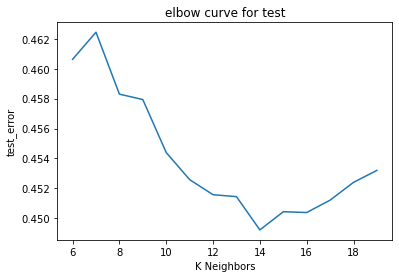

In [48]:
import matplotlib.pyplot as plt
plt.plot(k,test)
plt.xlabel("K Neighbors")
plt.ylabel('test_error')
plt.title("elbow curve for test")

In [66]:
knn=KNeighborsClassifier(n_neighbors=14)
knn.fit(x_trn,y_trn)

C:\Users\shraj\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=14)

In [72]:
y_trn_prdct=knn.predict(x_trn)
y_tst_prdct=knn.predict(x_tst)

In [73]:
print("Train acrcy",f1_score(y_trn_prdct,y_trn,average='micro').round(4))
print("Test acrcy",f1_score(y_tst_prdct,y_tst,average='micro').round(4))

Train acrcy 0.6015
Test acrcy 0.5508


In [82]:
analysis(y_trn,y_trn_prdct)


Classification report               precision    recall  f1-score   support

         0.0       0.64      0.90      0.75     61857
         1.0       0.50      0.37      0.42     35351
         2.0       0.39      0.07      0.12     10561
         3.0       0.38      0.02      0.04      4109
         4.0       0.41      0.01      0.02      1863
         5.0       0.52      0.08      0.14      2265

    accuracy                           0.60    116006
   macro avg       0.47      0.24      0.25    116006
weighted avg       0.56      0.60      0.54    116006

accuracy 0.6014602692964157
precision 0.6014602692964157
recall 0.6014602692964157


NameError: name 'sns' is not defined

In [85]:
analysis(y_tst,y_tst_prdct)

Classification report               precision    recall  f1-score   support

         0.0       0.61      0.86      0.71     20619
         1.0       0.39      0.29      0.33     11784
         2.0       0.19      0.04      0.06      3521
         3.0       0.19      0.01      0.02      1369
         4.0       0.23      0.00      0.01       621
         5.0       0.25      0.03      0.05       755

    accuracy                           0.55     38669
   macro avg       0.31      0.20      0.20     38669
weighted avg       0.48      0.55      0.49     38669

accuracy 0.5507771082779488
precision 0.5507771082779488
recall 0.5507771082779488


NameError: name 'sns' is not defined

#### after droping tags

In [94]:
def train_and_evaluate_model(model):
    model.fit(train_X,train_y)
    y_pred=model.predict(train_X)
    classification_report(train_y,y_pred)
    acc=accuracy_score(train_y,y_pred)
    precision=precision_score(train_y,y_pred,average="micro")
    recall=recall_score(train_y,y_pred,average="micro")
    f1=f1_score(train_y,y_pred,average="micro")
    print('f1 micro:'," ",f1)
   

In [95]:
def test_and_evaluate_model(model):
    model.fit(train_X,train_y)
    y_pred=model.predict(test_X)
    classification_report(test_y,y_pred)
    acc=accuracy_score(test_y,y_pred)
    precision=precision_score(test_y,y_pred,average="macro")
    recall=recall_score(test_y,y_pred,average="macro")
    f1=f1_score(test_y,y_pred,average="micro")
    print('f1_micro is'," ",f1)
    

In [136]:
x_trn=hstack((x_train_tags,x_train_rank,x_train_type,x_train_sbmsn,x_train_solved,x_train_flwr,x_train_rating,x_train_points,x_train_days)).tocsr()
x_tst=hstack((x_test_tags,x_test_rank,x_test_type,x_test_sbmsn,x_test_solved,x_test_flwr,x_test_rating,x_test_points,x_test_days)).tocsr()


In [135]:

from flaml import AutoML
automl1=AutoML()
automl1.fit(x_trn,y_trn,task='classification',time_budget=3600)

[flaml.automl.logger: 07-18 18:39:11] {1693} INFO - task = classification
[flaml.automl.logger: 07-18 18:39:11] {1700} INFO - Data split method: stratified
[flaml.automl.logger: 07-18 18:39:11] {1703} INFO - Evaluation method: holdout
[flaml.automl.logger: 07-18 18:39:11] {1801} INFO - Minimizing error metric: log_loss
[flaml.automl.logger: 07-18 18:39:11] {1911} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 07-18 18:39:11] {2221} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 07-18 18:39:11] {2347} INFO - Estimated sufficient time budget=3241s. Estimated necessary time budget=75s.
[flaml.automl.logger: 07-18 18:39:11] {2394} INFO -  at 0.1s,	estimator lgbm's best error=1.0275,	best estimator lgbm's best error=1.0275
[flaml.automl.logger: 07-18 18:39:11] {2221} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 07-18 18:39:11] {2394} INFO -  at 0.2s,	estimator lgbm's best err

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:39:11] {2394} INFO -  at 0.5s,	estimator xgboost's best error=1.4443,	best estimator lgbm's best error=0.9241
[flaml.automl.logger: 07-18 18:39:11] {2221} INFO - iteration 10, current learner xgboost
[flaml.automl.logger: 07-18 18:39:11] {2394} INFO -  at 0.5s,	estimator xgboost's best error=1.1680,	best estimator lgbm's best error=0.9241
[flaml.automl.logger: 07-18 18:39:11] {2221} INFO - iteration 11, current learner extra_tree
[flaml.automl.logger: 07-18 18:39:12] {2394} INFO -  at 0.6s,	estimator extra_tree's best error=1.1664,	best estimator lgbm's best error=0.9241
[flaml.automl.logger: 07-18 18:39:12] {2221} INFO - iteration 12, current learner extra_tree
[flaml.automl.logger: 07-18 18:39:12] {2394} INFO -  at 0.6s,	estimator extra_tree's best error=1.1587,	best estimator lgbm's best error=0.9241
[flaml.automl.logger: 07-18 18:39:12] {2221} INFO - iteration 13, current learner rf


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:39:12] {2394} INFO -  at 0.7s,	estimator rf's best error=1.1334,	best estimator lgbm's best error=0.9241
[flaml.automl.logger: 07-18 18:39:12] {2221} INFO - iteration 14, current learner rf
[flaml.automl.logger: 07-18 18:39:12] {2394} INFO -  at 0.8s,	estimator rf's best error=1.0652,	best estimator lgbm's best error=0.9241
[flaml.automl.logger: 07-18 18:39:12] {2221} INFO - iteration 15, current learner xgboost
[flaml.automl.logger: 07-18 18:39:12] {2394} INFO -  at 0.8s,	estimator xgboost's best error=0.9331,	best estimator lgbm's best error=0.9241
[flaml.automl.logger: 07-18 18:39:12] {2221} INFO - iteration 16, current learner lgbm
[flaml.automl.logger: 07-18 18:39:12] {2394} INFO -  at 0.9s,	estimator lgbm's best error=0.9208,	best estimator lgbm's best error=0.9208
[flaml.automl.logger: 07-18 18:39:12] {2221} INFO - iteration 17, current learner xgboost
[flaml.automl.logger: 07-18 18:39:12] {2394} INFO -  at 0.9s,	estimator xgboost's best error=0.93

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:39:12] {2394} INFO -  at 1.3s,	estimator lgbm's best error=0.9208,	best estimator lgbm's best error=0.9208
[flaml.automl.logger: 07-18 18:39:12] {2221} INFO - iteration 21, current learner xgboost
[flaml.automl.logger: 07-18 18:39:12] {2394} INFO -  at 1.4s,	estimator xgboost's best error=0.9293,	best estimator lgbm's best error=0.9208
[flaml.automl.logger: 07-18 18:39:12] {2221} INFO - iteration 22, current learner lgbm


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:39:13] {2394} INFO -  at 1.6s,	estimator lgbm's best error=0.9000,	best estimator lgbm's best error=0.9000
[flaml.automl.logger: 07-18 18:39:13] {2221} INFO - iteration 23, current learner lgbm
[flaml.automl.logger: 07-18 18:39:13] {2394} INFO -  at 1.9s,	estimator lgbm's best error=0.9000,	best estimator lgbm's best error=0.9000
[flaml.automl.logger: 07-18 18:39:13] {2221} INFO - iteration 24, current learner rf
[flaml.automl.logger: 07-18 18:39:13] {2394} INFO -  at 2.0s,	estimator rf's best error=1.0652,	best estimator lgbm's best error=0.9000
[flaml.automl.logger: 07-18 18:39:13] {2221} INFO - iteration 25, current learner extra_tree
[flaml.automl.logger: 07-18 18:39:13] {2394} INFO -  at 2.0s,	estimator extra_tree's best error=1.1587,	best estimator lgbm's best error=0.9000
[flaml.automl.logger: 07-18 18:39:13] {2221} INFO - iteration 26, current learner lgbm
[flaml.automl.logger: 07-18 18:39:13] {2394} INFO -  at 2.2s,	estimator lgbm's best error=0.

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:39:14] {2394} INFO -  at 2.8s,	estimator lgbm's best error=0.8955,	best estimator lgbm's best error=0.8955
[flaml.automl.logger: 07-18 18:39:14] {2221} INFO - iteration 31, current learner lgbm
[flaml.automl.logger: 07-18 18:39:14] {2394} INFO -  at 3.1s,	estimator lgbm's best error=0.8877,	best estimator lgbm's best error=0.8877
[flaml.automl.logger: 07-18 18:39:14] {2221} INFO - iteration 32, current learner lgbm
[flaml.automl.logger: 07-18 18:39:15] {2394} INFO -  at 3.7s,	estimator lgbm's best error=0.8877,	best estimator lgbm's best error=0.8877
[flaml.automl.logger: 07-18 18:39:15] {2221} INFO - iteration 33, current learner xgboost
[flaml.automl.logger: 07-18 18:39:15] {2394} INFO -  at 3.8s,	estimator xgboost's best error=0.9199,	best estimator lgbm's best error=0.8877
[flaml.automl.logger: 07-18 18:39:15] {2221} INFO - iteration 34, current learner lgbm


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:39:15] {2394} INFO -  at 4.0s,	estimator lgbm's best error=0.8877,	best estimator lgbm's best error=0.8877
[flaml.automl.logger: 07-18 18:39:15] {2221} INFO - iteration 35, current learner lgbm
[flaml.automl.logger: 07-18 18:39:15] {2394} INFO -  at 4.5s,	estimator lgbm's best error=0.8877,	best estimator lgbm's best error=0.8877
[flaml.automl.logger: 07-18 18:39:15] {2221} INFO - iteration 36, current learner xgboost
[flaml.automl.logger: 07-18 18:39:16] {2394} INFO -  at 4.5s,	estimator xgboost's best error=0.9199,	best estimator lgbm's best error=0.8877
[flaml.automl.logger: 07-18 18:39:16] {2221} INFO - iteration 37, current learner rf
[flaml.automl.logger: 07-18 18:39:16] {2394} INFO -  at 4.6s,	estimator rf's best error=1.0652,	best estimator lgbm's best error=0.8877
[flaml.automl.logger: 07-18 18:39:16] {2221} INFO - iteration 38, current learner rf


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:39:16] {2394} INFO -  at 4.7s,	estimator rf's best error=1.0652,	best estimator lgbm's best error=0.8877
[flaml.automl.logger: 07-18 18:39:16] {2221} INFO - iteration 39, current learner lgbm
[flaml.automl.logger: 07-18 18:39:16] {2394} INFO -  at 5.0s,	estimator lgbm's best error=0.8877,	best estimator lgbm's best error=0.8877
[flaml.automl.logger: 07-18 18:39:16] {2221} INFO - iteration 40, current learner xgboost
[flaml.automl.logger: 07-18 18:39:16] {2394} INFO -  at 5.0s,	estimator xgboost's best error=0.9199,	best estimator lgbm's best error=0.8877
[flaml.automl.logger: 07-18 18:39:16] {2221} INFO - iteration 41, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:39:16] {2394} INFO -  at 5.3s,	estimator xgboost's best error=0.9199,	best estimator lgbm's best error=0.8877
[flaml.automl.logger: 07-18 18:39:16] {2221} INFO - iteration 42, current learner lgbm
[flaml.automl.logger: 07-18 18:39:16] {2394} INFO -  at 5.4s,	estimator lgbm's best error=0.8877,	best estimator lgbm's best error=0.8877
[flaml.automl.logger: 07-18 18:39:16] {2221} INFO - iteration 43, current learner rf
[flaml.automl.logger: 07-18 18:39:17] {2394} INFO -  at 5.7s,	estimator rf's best error=1.0460,	best estimator lgbm's best error=0.8877
[flaml.automl.logger: 07-18 18:39:17] {2221} INFO - iteration 44, current learner extra_tree
[flaml.automl.logger: 07-18 18:39:17] {2394} INFO -  at 5.7s,	estimator extra_tree's best error=1.1458,	best estimator lgbm's best error=0.8877
[flaml.automl.logger: 07-18 18:39:17] {2221} INFO - iteration 45, current learner xgboost
[flaml.automl.logger: 07-18 18:39:17] {2394} INFO -  at 5.8s,	estimator xgboost's best

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:39:17] {2394} INFO -  at 6.5s,	estimator lgbm's best error=0.8808,	best estimator lgbm's best error=0.8808
[flaml.automl.logger: 07-18 18:39:17] {2221} INFO - iteration 47, current learner xgb_limitdepth
[flaml.automl.logger: 07-18 18:39:18] {2394} INFO -  at 6.7s,	estimator xgb_limitdepth's best error=0.9445,	best estimator lgbm's best error=0.8808


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:39:18] {2221} INFO - iteration 48, current learner xgb_limitdepth
[flaml.automl.logger: 07-18 18:39:18] {2394} INFO -  at 6.8s,	estimator xgb_limitdepth's best error=0.9445,	best estimator lgbm's best error=0.8808
[flaml.automl.logger: 07-18 18:39:18] {2221} INFO - iteration 49, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:39:18] {2394} INFO -  at 7.0s,	estimator xgboost's best error=0.9199,	best estimator lgbm's best error=0.8808
[flaml.automl.logger: 07-18 18:39:18] {2221} INFO - iteration 50, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:39:18] {2394} INFO -  at 7.2s,	estimator xgb_limitdepth's best error=0.9445,	best estimator lgbm's best error=0.8808
[flaml.automl.logger: 07-18 18:39:18] {2221} INFO - iteration 51, current learner xgb_limitdepth
[flaml.automl.logger: 07-18 18:39:18] {2394} INFO -  at 7.4s,	estimator xgb_limitdepth's best error=0.9351,	best estimator lgbm's best error=0.8808
[flaml.automl.logger: 07-18 18:39:18] {2221} INFO - iteration 52, current learner lgbm


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:39:19] {2394} INFO -  at 8.3s,	estimator lgbm's best error=0.8806,	best estimator lgbm's best error=0.8806
[flaml.automl.logger: 07-18 18:39:19] {2221} INFO - iteration 53, current learner lgbm
[flaml.automl.logger: 07-18 18:39:20] {2394} INFO -  at 9.0s,	estimator lgbm's best error=0.8802,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:20] {2221} INFO - iteration 54, current learner lgbm
[flaml.automl.logger: 07-18 18:39:21] {2394} INFO -  at 9.6s,	estimator lgbm's best error=0.8802,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:21] {2221} INFO - iteration 55, current learner lgbm
[flaml.automl.logger: 07-18 18:39:21] {2394} INFO -  at 10.4s,	estimator lgbm's best error=0.8802,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:21] {2221} INFO - iteration 56, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:39:22] {2394} INFO -  at 10.9s,	estimator xgboost's best error=0.8941,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:22] {2221} INFO - iteration 57, current learner lgbm
[flaml.automl.logger: 07-18 18:39:23] {2394} INFO -  at 12.5s,	estimator lgbm's best error=0.8802,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:23] {2221} INFO - iteration 58, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:39:24] {2394} INFO -  at 12.7s,	estimator xgboost's best error=0.8941,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:24] {2221} INFO - iteration 59, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:39:24] {2394} INFO -  at 13.5s,	estimator xgboost's best error=0.8941,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:24] {2221} INFO - iteration 60, current learner lgbm
[flaml.automl.logger: 07-18 18:39:25] {2394} INFO -  at 14.0s,	estimator lgbm's best error=0.8802,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:25] {2221} INFO - iteration 61, current learner xgboost
[flaml.automl.logger: 07-18 18:39:25] {2394} INFO -  at 14.1s,	estimator xgboost's best error=0.8941,	best estimator lgbm's best error=0.8802


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:39:25] {2221} INFO - iteration 62, current learner lgbm
[flaml.automl.logger: 07-18 18:39:27] {2394} INFO -  at 15.9s,	estimator lgbm's best error=0.8802,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:27] {2221} INFO - iteration 63, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:39:28] {2394} INFO -  at 17.0s,	estimator xgboost's best error=0.8941,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:28] {2221} INFO - iteration 64, current learner extra_tree
[flaml.automl.logger: 07-18 18:39:28] {2394} INFO -  at 17.1s,	estimator extra_tree's best error=1.1458,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:28] {2221} INFO - iteration 65, current learner lgbm
[flaml.automl.logger: 07-18 18:39:28] {2394} INFO -  at 17.5s,	estimator lgbm's best error=0.8802,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:28] {2221} INFO - iteration 66, current learner xgboost
[flaml.automl.logger: 07-18 18:39:29] {2394} INFO -  at 17.7s,	estimator xgboost's best error=0.8941,	best estimator lgbm's best error=0.8802


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:39:29] {2221} INFO - iteration 67, current learner extra_tree
[flaml.automl.logger: 07-18 18:39:29] {2394} INFO -  at 17.8s,	estimator extra_tree's best error=1.1458,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:29] {2221} INFO - iteration 68, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:39:31] {2394} INFO -  at 19.7s,	estimator xgboost's best error=0.8810,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:31] {2221} INFO - iteration 69, current learner lgbm
[flaml.automl.logger: 07-18 18:39:31] {2394} INFO -  at 20.1s,	estimator lgbm's best error=0.8802,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:31] {2221} INFO - iteration 70, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:39:32] {2394} INFO -  at 21.2s,	estimator xgboost's best error=0.8810,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:32] {2221} INFO - iteration 71, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:39:35] {2394} INFO -  at 23.8s,	estimator xgboost's best error=0.8810,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:35] {2221} INFO - iteration 72, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:39:36] {2394} INFO -  at 25.1s,	estimator xgboost's best error=0.8810,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:36] {2221} INFO - iteration 73, current learner lrl1
[flaml.automl.logger: 07-18 18:39:37] {2394} INFO -  at 26.1s,	estimator lrl1's best error=1.1501,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:37] {2221} INFO - iteration 74, current learner lrl1


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-18 18:39:38] {2394} INFO -  at 26.8s,	estimator lrl1's best error=1.1500,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:38] {2221} INFO - iteration 75, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:39:41] {2394} INFO -  at 29.6s,	estimator xgboost's best error=0.8810,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:41] {2221} INFO - iteration 76, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:39:41] {2394} INFO -  at 29.8s,	estimator xgb_limitdepth's best error=0.9351,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:41] {2221} INFO - iteration 77, current learner lgbm
[flaml.automl.logger: 07-18 18:39:43] {2394} INFO -  at 32.2s,	estimator lgbm's best error=0.8802,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:43] {2221} INFO - iteration 78, current learner lgbm
[flaml.automl.logger: 07-18 18:39:44] {2394} INFO -  at 32.7s,	estimator lgbm's best error=0.8802,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:44] {2221} INFO - iteration 79, current learner xgb_limitdepth
[flaml.automl.logger: 07-18 18:39:44] {2394} INFO -  at 32.7s,	estimator xgb_limitdepth's best error=0.9351,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:44] {2221} INFO - iteration 80, current learner rf


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:39:44] {2394} INFO -  at 33.2s,	estimator rf's best error=1.0460,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:44] {2221} INFO - iteration 81, current learner lgbm
[flaml.automl.logger: 07-18 18:39:45] {2394} INFO -  at 34.4s,	estimator lgbm's best error=0.8802,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:45] {2221} INFO - iteration 82, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:39:46] {2394} INFO -  at 34.8s,	estimator xgb_limitdepth's best error=0.9351,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:46] {2221} INFO - iteration 83, current learner rf
[flaml.automl.logger: 07-18 18:39:46] {2394} INFO -  at 35.0s,	estimator rf's best error=1.0460,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:46] {2221} INFO - iteration 84, current learner extra_tree
[flaml.automl.logger: 07-18 18:39:46] {2394} INFO -  at 35.1s,	estimator extra_tree's best error=1.1458,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:46] {2221} INFO - iteration 85, current learner extra_tree
[flaml.automl.logger: 07-18 18:39:46] {2394} INFO -  at 35.2s,	estimator extra_tree's best error=1.1443,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:46] {2221} INFO - iteration 86, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:39:47] {2394} INFO -  at 36.2s,	estimator xgb_limitdepth's best error=0.8901,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:47] {2221} INFO - iteration 87, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:39:49] {2394} INFO -  at 37.6s,	estimator xgb_limitdepth's best error=0.8899,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:49] {2221} INFO - iteration 88, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:39:49] {2394} INFO -  at 38.0s,	estimator xgboost's best error=0.8810,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:49] {2221} INFO - iteration 89, current learner lgbm
[flaml.automl.logger: 07-18 18:39:50] {2394} INFO -  at 38.8s,	estimator lgbm's best error=0.8802,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:50] {2221} INFO - iteration 90, current learner lgbm
[flaml.automl.logger: 07-18 18:39:51] {2394} INFO -  at 39.8s,	estimator lgbm's best error=0.8802,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:39:51] {2221} INFO - iteration 91, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:40:03] {2394} INFO -  at 51.6s,	estimator xgboost's best error=0.8810,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:40:03] {2221} INFO - iteration 92, current learner lgbm
[flaml.automl.logger: 07-18 18:40:06] {2394} INFO -  at 55.1s,	estimator lgbm's best error=0.8802,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:40:06] {2221} INFO - iteration 93, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:40:07] {2394} INFO -  at 56.5s,	estimator xgb_limitdepth's best error=0.8899,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:40:07] {2221} INFO - iteration 94, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:40:09] {2394} INFO -  at 57.9s,	estimator xgboost's best error=0.8810,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:40:09] {2221} INFO - iteration 95, current learner rf
[flaml.automl.logger: 07-18 18:40:09] {2394} INFO -  at 58.2s,	estimator rf's best error=1.0460,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:40:09] {2221} INFO - iteration 96, current learner lgbm
[flaml.automl.logger: 07-18 18:40:09] {2394} INFO -  at 58.5s,	estimator lgbm's best error=0.8802,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:40:09] {2221} INFO - iteration 97, current learner extra_tree
[flaml.automl.logger: 07-18 18:40:10] {2394} INFO -  at 58.6s,	estimator extra_tree's best error=1.1443,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:40:10] {2221} INFO - iteration 98, current learner rf
[flaml.automl.logger: 07-18 18:40:10] {2394} INFO -  at 59.0s,	estimator rf's best erro

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:40:16] {2394} INFO -  at 65.1s,	estimator xgboost's best error=0.8810,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:40:16] {2221} INFO - iteration 103, current learner rf
[flaml.automl.logger: 07-18 18:40:17] {2394} INFO -  at 65.6s,	estimator rf's best error=0.9750,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:40:17] {2221} INFO - iteration 104, current learner lgbm
[flaml.automl.logger: 07-18 18:40:17] {2394} INFO -  at 66.3s,	estimator lgbm's best error=0.8802,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:40:17] {2221} INFO - iteration 105, current learner rf
[flaml.automl.logger: 07-18 18:40:18] {2394} INFO -  at 67.2s,	estimator rf's best error=0.9750,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:40:18] {2221} INFO - iteration 106, current learner lgbm
[flaml.automl.logger: 07-18 18:40:31] {2394} INFO -  at 80.3s,	estimator lgbm's best error=0.8802

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:40:33] {2394} INFO -  at 81.7s,	estimator xgboost's best error=0.8810,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:40:33] {2221} INFO - iteration 109, current learner lgbm
[flaml.automl.logger: 07-18 18:40:33] {2394} INFO -  at 82.1s,	estimator lgbm's best error=0.8802,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:40:33] {2221} INFO - iteration 110, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:40:44] {2394} INFO -  at 92.8s,	estimator xgboost's best error=0.8810,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:40:44] {2221} INFO - iteration 111, current learner rf
[flaml.automl.logger: 07-18 18:40:44] {2394} INFO -  at 93.3s,	estimator rf's best error=0.9750,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:40:44] {2221} INFO - iteration 112, current learner lgbm
[flaml.automl.logger: 07-18 18:40:45] {2394} INFO -  at 93.7s,	estimator lgbm's best error=0.8802,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:40:45] {2221} INFO - iteration 113, current learner extra_tree
[flaml.automl.logger: 07-18 18:40:45] {2394} INFO -  at 93.8s,	estimator extra_tree's best error=1.1443,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:40:45] {2221} INFO - iteration 114, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:40:48] {2394} INFO -  at 96.9s,	estimator xgboost's best error=0.8810,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:40:48] {2221} INFO - iteration 115, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:40:50] {2394} INFO -  at 98.7s,	estimator xgb_limitdepth's best error=0.8892,	best estimator lgbm's best error=0.8802
[flaml.automl.logger: 07-18 18:40:50] {2221} INFO - iteration 116, current learner lgbm
[flaml.automl.logger: 07-18 18:41:00] {2394} INFO -  at 108.6s,	estimator lgbm's best error=0.8768,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:41:00] {2221} INFO - iteration 117, current learner lgbm
[flaml.automl.logger: 07-18 18:41:29] {2394} INFO -  at 137.8s,	estimator lgbm's best error=0.8768,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:41:29] {2221} INFO - iteration 118, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:41:30] {2394} INFO -  at 139.3s,	estimator xgb_limitdepth's best error=0.8892,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:41:30] {2221} INFO - iteration 119, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:41:32] {2394} INFO -  at 140.7s,	estimator xgboost's best error=0.8810,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:41:32] {2221} INFO - iteration 120, current learner lgbm
[flaml.automl.logger: 07-18 18:41:36] {2394} INFO -  at 145.1s,	estimator lgbm's best error=0.8768,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:41:36] {2221} INFO - iteration 121, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:41:40] {2394} INFO -  at 148.7s,	estimator xgboost's best error=0.8810,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:41:40] {2221} INFO - iteration 122, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:41:41] {2394} INFO -  at 150.0s,	estimator xgboost's best error=0.8810,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:41:41] {2221} INFO - iteration 123, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:41:43] {2394} INFO -  at 151.5s,	estimator xgb_limitdepth's best error=0.8892,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:41:43] {2221} INFO - iteration 124, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:41:58] {2394} INFO -  at 166.8s,	estimator xgboost's best error=0.8810,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:41:58] {2221} INFO - iteration 125, current learner lgbm
[flaml.automl.logger: 07-18 18:42:00] {2394} INFO -  at 168.8s,	estimator lgbm's best error=0.8768,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:42:00] {2221} INFO - iteration 126, current learner lgbm
[flaml.automl.logger: 07-18 18:43:07] {2394} INFO -  at 235.8s,	estimator lgbm's best error=0.8768,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:43:07] {2221} INFO - iteration 127, current learner lgbm
[flaml.automl.logger: 07-18 18:43:08] {2394} INFO -  at 237.3s,	estimator lgbm's best error=0.8768,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:43:08] {2221} INFO - iteration 128, current learner lgbm
[flaml.automl.logger: 07-18 18:44:11] {2394} INFO -  at 300.3s,	estimator lgbm's best

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:44:13] {2394} INFO -  at 301.6s,	estimator xgboost's best error=0.8810,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:44:13] {2221} INFO - iteration 135, current learner extra_tree
[flaml.automl.logger: 07-18 18:44:13] {2394} INFO -  at 301.9s,	estimator extra_tree's best error=1.0934,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:44:13] {2221} INFO - iteration 136, current learner extra_tree
[flaml.automl.logger: 07-18 18:44:13] {2394} INFO -  at 302.2s,	estimator extra_tree's best error=1.0926,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:44:13] {2221} INFO - iteration 137, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:44:17] {2394} INFO -  at 306.5s,	estimator xgb_limitdepth's best error=0.8875,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:44:17] {2221} INFO - iteration 138, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:44:20] {2394} INFO -  at 309.5s,	estimator xgboost's best error=0.8810,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:44:20] {2221} INFO - iteration 139, current learner lgbm
[flaml.automl.logger: 07-18 18:44:22] {2394} INFO -  at 310.7s,	estimator lgbm's best error=0.8768,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:44:22] {2221} INFO - iteration 140, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:44:24] {2394} INFO -  at 312.6s,	estimator xgb_limitdepth's best error=0.8875,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:44:24] {2221} INFO - iteration 141, current learner rf
[flaml.automl.logger: 07-18 18:44:25] {2394} INFO -  at 313.6s,	estimator rf's best error=0.9750,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:44:25] {2221} INFO - iteration 142, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:44:36] {2394} INFO -  at 324.8s,	estimator xgb_limitdepth's best error=0.8871,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:44:36] {2221} INFO - iteration 143, current learner rf
[flaml.automl.logger: 07-18 18:44:37] {2394} INFO -  at 325.7s,	estimator rf's best error=0.9462,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:44:37] {2221} INFO - iteration 144, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:44:39] {2394} INFO -  at 328.0s,	estimator xgboost's best error=0.8810,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:44:39] {2221} INFO - iteration 145, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:44:42] {2394} INFO -  at 330.8s,	estimator xgboost's best error=0.8810,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:44:42] {2221} INFO - iteration 146, current learner rf
[flaml.automl.logger: 07-18 18:44:42] {2394} INFO -  at 331.3s,	estimator rf's best error=0.9462,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:44:42] {2221} INFO - iteration 147, current learner rf
[flaml.automl.logger: 07-18 18:44:44] {2394} INFO -  at 332.6s,	estimator rf's best error=0.9462,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:44:44] {2221} INFO - iteration 148, current learner lgbm
[flaml.automl.logger: 07-18 18:46:34] {2394} INFO -  at 443.5s,	estimator lgbm's best error=0.8768,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:46:34] {2221} INFO - iteration 149, current learner rf
[flaml.automl.logger: 07-18 18:46:35] {2394} INFO -  at 444.4s,	estimator rf's best error=0.946

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:47:37] {2394} INFO -  at 505.6s,	estimator xgboost's best error=0.8810,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:47:37] {2221} INFO - iteration 154, current learner rf
[flaml.automl.logger: 07-18 18:47:38] {2394} INFO -  at 506.6s,	estimator rf's best error=0.9462,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:47:38] {2221} INFO - iteration 155, current learner lgbm
[flaml.automl.logger: 07-18 18:47:40] {2394} INFO -  at 508.7s,	estimator lgbm's best error=0.8768,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:47:40] {2221} INFO - iteration 156, current learner lgbm
[flaml.automl.logger: 07-18 18:48:46] {2394} INFO -  at 574.7s,	estimator lgbm's best error=0.8768,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:48:46] {2221} INFO - iteration 157, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:48:52] {2394} INFO -  at 581.1s,	estimator xgb_limitdepth's best error=0.8871,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:48:52] {2221} INFO - iteration 158, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:48:53] {2394} INFO -  at 581.9s,	estimator xgboost's best error=0.8810,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:48:53] {2221} INFO - iteration 159, current learner rf
[flaml.automl.logger: 07-18 18:48:54] {2394} INFO -  at 583.3s,	estimator rf's best error=0.9462,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:48:54] {2221} INFO - iteration 160, current learner rf
[flaml.automl.logger: 07-18 18:48:55] {2394} INFO -  at 584.1s,	estimator rf's best error=0.9462,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:48:55] {2221} INFO - iteration 161, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:49:02] {2394} INFO -  at 591.4s,	estimator xgboost's best error=0.8810,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:49:02] {2221} INFO - iteration 162, current learner rf
[flaml.automl.logger: 07-18 18:49:04] {2394} INFO -  at 592.8s,	estimator rf's best error=0.9462,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:49:04] {2221} INFO - iteration 163, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:49:07] {2394} INFO -  at 595.6s,	estimator xgboost's best error=0.8810,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:49:07] {2221} INFO - iteration 164, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:49:26] {2394} INFO -  at 615.3s,	estimator xgb_limitdepth's best error=0.8860,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:49:26] {2221} INFO - iteration 165, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:49:28] {2394} INFO -  at 616.7s,	estimator xgboost's best error=0.8810,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:49:28] {2221} INFO - iteration 166, current learner rf
[flaml.automl.logger: 07-18 18:49:29] {2394} INFO -  at 617.7s,	estimator rf's best error=0.9462,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:49:29] {2221} INFO - iteration 167, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:49:33] {2394} INFO -  at 622.1s,	estimator xgboost's best error=0.8810,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:49:33] {2221} INFO - iteration 168, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:49:34] {2394} INFO -  at 623.2s,	estimator xgboost's best error=0.8810,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:49:34] {2221} INFO - iteration 169, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:49:36] {2394} INFO -  at 625.3s,	estimator xgboost's best error=0.8810,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:49:36] {2221} INFO - iteration 170, current learner rf
[flaml.automl.logger: 07-18 18:49:37] {2394} INFO -  at 626.1s,	estimator rf's best error=0.9462,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:49:37] {2221} INFO - iteration 171, current learner lgbm
[flaml.automl.logger: 07-18 18:49:39] {2394} INFO -  at 628.2s,	estimator lgbm's best error=0.8768,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:49:39] {2221} INFO - iteration 172, current learner lgbm
[flaml.automl.logger: 07-18 18:49:58] {2394} INFO -  at 647.4s,	estimator lgbm's best error=0.8768,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:49:58] {2221} INFO - iteration 173, current learner rf
[flaml.automl.logger: 07-18 18:50:00] {2394} INFO -  at 649.0s,	estimator rf's best error=0

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:50:03] {2394} INFO -  at 651.7s,	estimator xgboost's best error=0.8810,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:50:03] {2221} INFO - iteration 175, current learner xgboost


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:50:06] {2394} INFO -  at 654.9s,	estimator xgboost's best error=0.8809,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:50:06] {2221} INFO - iteration 176, current learner rf
[flaml.automl.logger: 07-18 18:50:07] {2394} INFO -  at 655.9s,	estimator rf's best error=0.9462,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:50:07] {2221} INFO - iteration 177, current learner lrl1
[flaml.automl.logger: 07-18 18:50:07] {2394} INFO -  at 656.4s,	estimator lrl1's best error=1.1500,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:50:07] {2221} INFO - iteration 178, current learner rf


C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-18 18:50:08] {2394} INFO -  at 657.2s,	estimator rf's best error=0.9462,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:50:08] {2221} INFO - iteration 179, current learner rf
[flaml.automl.logger: 07-18 18:50:10] {2394} INFO -  at 658.6s,	estimator rf's best error=0.9462,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:50:10] {2221} INFO - iteration 180, current learner rf
[flaml.automl.logger: 07-18 18:50:12] {2394} INFO -  at 660.8s,	estimator rf's best error=0.9462,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:50:12] {2221} INFO - iteration 181, current learner extra_tree
[flaml.automl.logger: 07-18 18:50:12] {2394} INFO -  at 661.0s,	estimator extra_tree's best error=1.0926,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:50:12] {2221} INFO - iteration 182, current learner rf
[flaml.automl.logger: 07-18 18:50:13] {2394} INFO -  at 661.9s,	estimator rf's best erro

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:51:03] {2394} INFO -  at 712.1s,	estimator xgb_limitdepth's best error=0.8860,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:51:03] {2221} INFO - iteration 192, current learner lgbm
[flaml.automl.logger: 07-18 18:51:07] {2394} INFO -  at 715.8s,	estimator lgbm's best error=0.8768,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:51:07] {2221} INFO - iteration 193, current learner extra_tree
[flaml.automl.logger: 07-18 18:51:07] {2394} INFO -  at 716.3s,	estimator extra_tree's best error=1.0671,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:51:07] {2221} INFO - iteration 194, current learner extra_tree
[flaml.automl.logger: 07-18 18:51:08] {2394} INFO -  at 717.2s,	estimator extra_tree's best error=1.0253,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:51:08] {2221} INFO - iteration 195, current learner extra_tree
[flaml.automl.logger: 07-18 18:51:09] {2394} INF

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:52:54] {2394} INFO -  at 822.6s,	estimator xgb_limitdepth's best error=0.8804,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:52:54] {2221} INFO - iteration 201, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:53:11] {2394} INFO -  at 840.5s,	estimator xgb_limitdepth's best error=0.8804,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:53:11] {2221} INFO - iteration 202, current learner lgbm
[flaml.automl.logger: 07-18 18:54:20] {2394} INFO -  at 908.7s,	estimator lgbm's best error=0.8768,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:54:20] {2221} INFO - iteration 203, current learner rf
[flaml.automl.logger: 07-18 18:54:21] {2394} INFO -  at 910.0s,	estimator rf's best error=0.9364,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:54:21] {2221} INFO - iteration 204, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:56:58] {2394} INFO -  at 1066.6s,	estimator xgb_limitdepth's best error=0.8804,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:56:58] {2221} INFO - iteration 205, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:57:45] {2394} INFO -  at 1114.2s,	estimator xgb_limitdepth's best error=0.8804,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:57:45] {2221} INFO - iteration 206, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:58:58] {2394} INFO -  at 1186.7s,	estimator xgb_limitdepth's best error=0.8804,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:58:58] {2221} INFO - iteration 207, current learner extra_tree
[flaml.automl.logger: 07-18 18:58:58] {2394} INFO -  at 1187.4s,	estimator extra_tree's best error=1.0146,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:58:58] {2221} INFO - iteration 208, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 18:59:29] {2394} INFO -  at 1218.3s,	estimator xgb_limitdepth's best error=0.8804,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:59:29] {2221} INFO - iteration 209, current learner extra_tree
[flaml.automl.logger: 07-18 18:59:30] {2394} INFO -  at 1219.1s,	estimator extra_tree's best error=1.0146,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:59:30] {2221} INFO - iteration 210, current learner extra_tree
[flaml.automl.logger: 07-18 18:59:31] {2394} INFO -  at 1220.4s,	estimator extra_tree's best error=1.0146,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:59:31] {2221} INFO - iteration 211, current learner extra_tree
[flaml.automl.logger: 07-18 18:59:32] {2394} INFO -  at 1220.9s,	estimator extra_tree's best error=1.0119,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 18:59:32] {2221} INFO - iteration 212, current learner extra_tree
[flaml.automl.logger: 07-18 18:5

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 19:01:37] {2394} INFO -  at 1346.0s,	estimator xgb_limitdepth's best error=0.8804,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:01:37] {2221} INFO - iteration 218, current learner extra_tree
[flaml.automl.logger: 07-18 19:01:38] {2394} INFO -  at 1346.5s,	estimator extra_tree's best error=0.9664,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:01:38] {2221} INFO - iteration 219, current learner rf
[flaml.automl.logger: 07-18 19:01:41] {2394} INFO -  at 1350.2s,	estimator rf's best error=0.9281,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:01:41] {2221} INFO - iteration 220, current learner rf
[flaml.automl.logger: 07-18 19:01:48] {2394} INFO -  at 1357.3s,	estimator rf's best error=0.9281,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:01:48] {2221} INFO - iteration 221, current learner extra_tree
[flaml.automl.logger: 07-18 19:01:50] {2394} INFO -  at 1358.6s,

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 19:02:03] {2394} INFO -  at 1371.7s,	estimator xgb_limitdepth's best error=0.8804,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:02:03] {2221} INFO - iteration 224, current learner extra_tree
[flaml.automl.logger: 07-18 19:02:05] {2394} INFO -  at 1373.6s,	estimator extra_tree's best error=0.9492,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:02:05] {2221} INFO - iteration 225, current learner lgbm
[flaml.automl.logger: 07-18 19:02:34] {2394} INFO -  at 1403.4s,	estimator lgbm's best error=0.8768,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:02:34] {2221} INFO - iteration 226, current learner rf
[flaml.automl.logger: 07-18 19:02:36] {2394} INFO -  at 1404.7s,	estimator rf's best error=0.9281,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:02:36] {2221} INFO - iteration 227, current learner extra_tree
[flaml.automl.logger: 07-18 19:02:36] {2394} INFO -  at 1405

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 19:07:16] {2394} INFO -  at 1684.6s,	estimator xgb_limitdepth's best error=0.8804,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:07:16] {2221} INFO - iteration 232, current learner extra_tree
[flaml.automl.logger: 07-18 19:07:21] {2394} INFO -  at 1689.7s,	estimator extra_tree's best error=0.9454,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:07:21] {2221} INFO - iteration 233, current learner extra_tree
[flaml.automl.logger: 07-18 19:07:22] {2394} INFO -  at 1691.4s,	estimator extra_tree's best error=0.9454,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:07:22] {2221} INFO - iteration 234, current learner extra_tree
[flaml.automl.logger: 07-18 19:07:25] {2394} INFO -  at 1694.2s,	estimator extra_tree's best error=0.9454,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:07:25] {2221} INFO - iteration 235, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 19:07:56] {2394} INFO -  at 1724.8s,	estimator xgb_limitdepth's best error=0.8804,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:07:56] {2221} INFO - iteration 236, current learner rf
[flaml.automl.logger: 07-18 19:07:59] {2394} INFO -  at 1727.7s,	estimator rf's best error=0.9281,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:07:59] {2221} INFO - iteration 237, current learner rf
[flaml.automl.logger: 07-18 19:08:02] {2394} INFO -  at 1730.9s,	estimator rf's best error=0.9281,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:08:02] {2221} INFO - iteration 238, current learner extra_tree
[flaml.automl.logger: 07-18 19:08:11] {2394} INFO -  at 1739.7s,	estimator extra_tree's best error=0.9390,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:08:11] {2221} INFO - iteration 239, current learner rf
[flaml.automl.logger: 07-18 19:08:13] {2394} INFO -  at 1742.1s,	estimat

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 19:08:15] {2394} INFO -  at 1744.3s,	estimator xgboost's best error=0.8809,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:08:15] {2221} INFO - iteration 241, current learner extra_tree
[flaml.automl.logger: 07-18 19:08:34] {2394} INFO -  at 1763.1s,	estimator extra_tree's best error=0.9390,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:08:34] {2221} INFO - iteration 242, current learner lgbm
[flaml.automl.logger: 07-18 19:08:40] {2394} INFO -  at 1768.6s,	estimator lgbm's best error=0.8768,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:08:40] {2221} INFO - iteration 243, current learner rf
[flaml.automl.logger: 07-18 19:08:41] {2394} INFO -  at 1770.4s,	estimator rf's best error=0.9061,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:08:41] {2221} INFO - iteration 244, current learner rf
[flaml.automl.logger: 07-18 19:08:45] {2394} INFO -  at 1773.8s,	estimator 

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 19:09:23] {2394} INFO -  at 1812.0s,	estimator xgboost's best error=0.8809,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:09:23] {2221} INFO - iteration 255, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 19:10:59] {2394} INFO -  at 1908.3s,	estimator xgb_limitdepth's best error=0.8804,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:10:59] {2221} INFO - iteration 256, current learner lgbm
[flaml.automl.logger: 07-18 19:11:15] {2394} INFO -  at 1923.8s,	estimator lgbm's best error=0.8768,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:11:15] {2221} INFO - iteration 257, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 19:11:24] {2394} INFO -  at 1933.2s,	estimator xgb_limitdepth's best error=0.8804,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:11:24] {2221} INFO - iteration 258, current learner rf
[flaml.automl.logger: 07-18 19:11:30] {2394} INFO -  at 1938.7s,	estimator rf's best error=0.8972,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:11:30] {2221} INFO - iteration 259, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 19:16:38] {2394} INFO -  at 2247.1s,	estimator xgb_limitdepth's best error=0.8804,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:16:38] {2221} INFO - iteration 260, current learner rf
[flaml.automl.logger: 07-18 19:16:41] {2394} INFO -  at 2250.5s,	estimator rf's best error=0.8972,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:16:41] {2221} INFO - iteration 261, current learner rf
[flaml.automl.logger: 07-18 19:16:51] {2394} INFO -  at 2260.1s,	estimator rf's best error=0.8932,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:16:51] {2221} INFO - iteration 262, current learner rf
[flaml.automl.logger: 07-18 19:16:56] {2394} INFO -  at 2265.1s,	estimator rf's best error=0.8881,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:16:56] {2221} INFO - iteration 263, current learner rf
[flaml.automl.logger: 07-18 19:17:07] {2394} INFO -  at 2275.7s,	estimator rf's best err

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 19:20:10] {2394} INFO -  at 2458.8s,	estimator xgb_limitdepth's best error=0.8776,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:20:10] {2221} INFO - iteration 281, current learner rf
[flaml.automl.logger: 07-18 19:20:28] {2394} INFO -  at 2476.7s,	estimator rf's best error=0.8812,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:20:28] {2221} INFO - iteration 282, current learner lgbm
[flaml.automl.logger: 07-18 19:20:36] {2394} INFO -  at 2484.7s,	estimator lgbm's best error=0.8768,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:20:36] {2221} INFO - iteration 283, current learner rf
[flaml.automl.logger: 07-18 19:20:45] {2394} INFO -  at 2494.1s,	estimator rf's best error=0.8812,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:20:45] {2221} INFO - iteration 284, current learner rf
[flaml.automl.logger: 07-18 19:21:26] {2394} INFO -  at 2535.0s,	estimator rf's best

C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 19:22:28] {2394} INFO -  at 2597.4s,	estimator xgb_limitdepth's best error=0.8776,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:22:28] {2221} INFO - iteration 287, current learner xgb_limitdepth


C:\Users\shraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 07-18 19:23:13] {2394} INFO -  at 2642.0s,	estimator xgb_limitdepth's best error=0.8776,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:23:13] {2221} INFO - iteration 288, current learner extra_tree
[flaml.automl.logger: 07-18 19:24:45] {2394} INFO -  at 2734.5s,	estimator extra_tree's best error=0.8934,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:24:45] {2221} INFO - iteration 289, current learner extra_tree
[flaml.automl.logger: 07-18 19:25:25] {2394} INFO -  at 2773.6s,	estimator extra_tree's best error=0.8934,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:25:25] {2221} INFO - iteration 290, current learner rf
[flaml.automl.logger: 07-18 19:25:33] {2394} INFO -  at 2781.9s,	estimator rf's best error=0.8812,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:25:33] {2221} INFO - iteration 291, current learner extra_tree
[flaml.automl.logger: 07-18 19:28:05] {2394} INF

C:\Users\shraj\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


[flaml.automl.logger: 07-18 19:30:55] {2394} INFO -  at 3104.2s,	estimator extra_tree's best error=0.8837,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:30:55] {2221} INFO - iteration 294, current learner extra_tree
[flaml.automl.logger: 07-18 19:32:15] {2394} INFO -  at 3184.0s,	estimator extra_tree's best error=0.8837,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:32:15] {2221} INFO - iteration 295, current learner extra_tree
[flaml.automl.logger: 07-18 19:33:20] {2394} INFO -  at 3249.2s,	estimator extra_tree's best error=0.8837,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:33:20] {2221} INFO - iteration 296, current learner rf
[flaml.automl.logger: 07-18 19:33:28] {2394} INFO -  at 3257.2s,	estimator rf's best error=0.8812,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:33:28] {2221} INFO - iteration 297, current learner extra_tree
[flaml.automl.logger: 07-18 19:33:47] {2394} INFO - 

C:\Users\shraj\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


[flaml.automl.logger: 07-18 19:38:54] {2394} INFO -  at 3583.4s,	estimator lgbm's best error=0.8768,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:38:54] {2221} INFO - iteration 300, current learner lgbm
[flaml.automl.logger: 07-18 19:39:13] {2394} INFO -  at 3601.6s,	estimator lgbm's best error=0.8768,	best estimator lgbm's best error=0.8768
[flaml.automl.logger: 07-18 19:39:25] {2630} INFO - retrain lgbm for 12.7s
[flaml.automl.logger: 07-18 19:39:25] {2633} INFO - retrained model: LGBMClassifier(colsample_bytree=0.7826388421872007,
               learning_rate=0.03345809818074701, max_bin=1023,
               min_child_samples=16, n_estimators=1, n_jobs=-1, num_leaves=48,
               reg_alpha=0.001975258376030875, reg_lambda=3.119487171996251,
               verbose=-1)
[flaml.automl.logger: 07-18 19:39:25] {1941} INFO - fit succeeded
[flaml.automl.logger: 07-18 19:39:25] {1942} INFO - Time taken to find the best model: 108.56011772155762


In [137]:
y_test_predct1=automl1.predict(x_tst)
y_train_predct1=automl1.predict(x_trn)
print("Train acrcy",f1_score(y_train_predct1,y_trn,average='micro').round(4))
print("Test acrcy",f1_score(y_test_predct1,y_tst,average='micro').round(4))

Train acrcy 0.6668
Test acrcy 0.6373


# VIF

In [33]:
x_trn=np.hstack((x_train_rank,x_train_type,x_train_sbmsn,x_train_solved,x_train_flwr,x_train_maxrating,x_train_rating,x_train_points,x_train_days))



In [40]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X=pd.DataFrame(x_trn)
X.shape

(116006, 9)

In [41]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

   feature         VIF
0        0    2.751591
1        1    2.151854
2        2  258.074618
3        3  255.897124
4        4         inf
5        5         inf
6        6    2.650742
7        7    1.427630
8        8    1.614158


C:\Users\shraj\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [45]:
modelxg=XGBClassifier()

In [58]:
x_trn=np.hstack((x_train_rank,x_train_type,x_train_sbmsn,x_train_solved,x_train_rating,x_train_points,x_train_days))



In [60]:
modelxg.fit(x_trn , y_trn)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [61]:
x_tst=np.hstack((x_test_rank,x_test_type,x_test_sbmsn,x_test_solved,x_test_rating,x_test_points,x_test_days))


In [54]:
#removed followers
f1_score(modelxg.predict(x_tst),y_tst,average='micro')

0.6267552820088443

In [62]:
#removd both max_rtng and flwrs
f1_score(modelxg.predict(x_tst),y_tst,average='micro')

0.6267552820088443

In [64]:
x_trn=np.hstack((x_train_rank,x_train_type,x_train_sbmsn,x_train_solved,x_train_flwr,x_train_rating,x_train_points,x_train_days))

x_tst=np.hstack((x_test_rank,x_test_type,x_test_sbmsn,x_test_solved,x_test_flwr,x_test_rating,x_test_points,x_test_days))


In [65]:
modelxg.fit(x_trn , y_trn)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [66]:
f1_score(modelxg.predict(x_tst),y_tst,average='micro')

0.6267552820088443

### Ridge classification

In [48]:
rdg=RidgeClassifier()

In [49]:
rdg.fit(x_trn,y_trn)

C:\Users\shraj\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:1190: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RidgeClassifier()

In [50]:
print("Train accuracy"," ",f1_score(rdg.predict(x_trn),y_trn,average='micro'))
print("Train accuracy"," ",f1_score(rdg.predict(x_tst),y_tst,average='micro'))

Train accuracy   0.5349206075547817
Train accuracy   0.5335022886549949


In [51]:
print("For test data / Random forest")
print()
print(classification_report(y_tst,rdg.predict(x_tst)))

For test data / Random forest

              precision    recall  f1-score   support

         0.0       0.55      0.94      0.70     20619
         1.0       0.34      0.11      0.17     11784
         2.0       0.00      0.00      0.00      3521
         3.0       0.00      0.00      0.00      1369
         4.0       0.00      0.00      0.00       621
         5.0       0.00      0.00      0.00       755

    accuracy                           0.53     38669
   macro avg       0.15      0.17      0.14     38669
weighted avg       0.40      0.53      0.42     38669



C:\Users\shraj\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shraj\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shraj\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
#CREating class weight for random forest
v=pd.DataFrame(y_trn).value_counts()
vls=v.values
print(v)
print(vls)


0.0    61857
1.0    35351
2.0    10561
3.0     4109
5.0     2265
4.0     1863
dtype: int64
[61857 35351 10561  4109  2265  1863]


In [35]:
i=vls[4]
j=vls[5]
vls[4]=j
vls[5]=i
vls


array([61857, 35351, 10561,  4109,  1863,  2265], dtype=int64)

In [36]:
weights={}
label=[0,1,2,3,4,5]
for i in label:
    global vls
    j= 116006/(6*vls[i])
    weights[i]=j
weights

{0: 0.31256500207467763,
 1: 0.5469246508821061,
 2: 1.8307294132500078,
 3: 4.7053622130283115,
 4: 10.378064054392556,
 5: 8.536129506990434}

In [37]:
model2=RandomForestClassifier(class_weight=weights)


In [38]:
model2.fit(x_trn,y_trn)

C:\Users\shraj\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(class_weight={0: 0.31256500207467763,
                                     1: 0.5469246508821061,
                                     2: 1.8307294132500078,
                                     3: 4.7053622130283115,
                                     4: 10.378064054392556,
                                     5: 8.536129506990434})

In [41]:
y_test_prdct2=model2.predict(x_tst)
y_train_prdct2=model2.predict(x_trn)

In [42]:

print("Train acrcy",f1_score(y_trn,y_train_prdct2,average='micro').round(4))
print("Test acrcy",f1_score(y_tst,y_test_prdct2,average='micro').round(4))


Train acrcy 0.9392
Test acrcy 0.5937


Classification report               precision    recall  f1-score   support

         0.0       0.97      0.94      0.95     61857
         1.0       0.94      0.93      0.93     35351
         2.0       0.88      0.96      0.92     10561
         3.0       0.83      0.99      0.90      4109
         4.0       0.81      1.00      0.90      1863
         5.0       0.89      1.00      0.94      2265

    accuracy                           0.94    116006
   macro avg       0.89      0.97      0.92    116006
weighted avg       0.94      0.94      0.94    116006

accuracy 0.9392014206161751
precision 0.9392014206161751
recall 0.9392014206161751


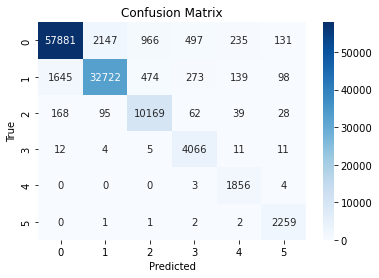

In [46]:
analysis(y_trn,y_train_prdct2)

Classification report               precision    recall  f1-score   support

         0.0       0.65      0.80      0.72     20619
         1.0       0.50      0.43      0.46     11784
         2.0       0.45      0.24      0.32      3521
         3.0       0.47      0.25      0.32      1369
         4.0       0.43      0.20      0.27       621
         5.0       0.48      0.26      0.34       755

    accuracy                           0.59     38669
   macro avg       0.50      0.36      0.40     38669
weighted avg       0.57      0.59      0.57     38669

accuracy 0.5937055522511573
precision 0.5937055522511573
recall 0.5937055522511573


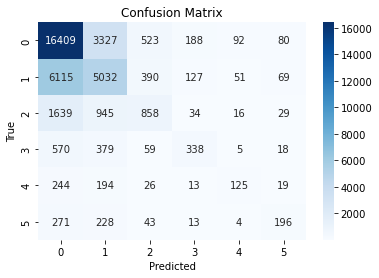

In [47]:
analysis(y_tst,y_test_prdct2)

In [84]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.
